# Q1

In [1]:
# Import 
import os
import random
from tqdm.notebook import tqdm

# Imaging Library
import cv2
from PIL import Image
import albumentations as A

# Data-handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


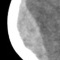

In [2]:
# check for files
dataset3 = "/kaggle/input/aimiassigmnet2/DataSet3"

train_files_dir = os.path.join(dataset3, "TrainFiles")

image_files = [f for f in os.listdir(train_files_dir) if os.path.isfile(os.path.join(train_files_dir, f))]

random_image_file = random.choice(image_files)
image = Image.open(os.path.join(train_files_dir, random_image_file))

#check the image
image

In [3]:
def file_to_numpy(directory_path, mask_path):
    file_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]  # Handle different image extensions
    images = []
    masks = []
    
    for file_path in file_paths:
        mask_file_name = os.path.basename(file_path).replace(".jpg", ".png")
        # get relevant mask path
        mask_file_path = os.path.join(mask_path, mask_file_name)

        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)

        
        if image is None:
            print(f"Error reading image: {file_path}")
            continue
        if mask is None:
            print(f"Error reading mask: {mask_file_path}")
            continue
            
        # if both image and mask have the correct shape (60,60)
        if image.shape == (60, 60) and mask.shape == (60, 60):
            images.append(image)
            masks.append(mask)
        else:
            print(f"Image or mask shape is not (60, 60): {file_path}, {mask_file_path}")
    
    return np.array(images), np.array(masks) # Return numpy arrays of images and masks

In [4]:
def count_non_zero_mask(mask_numpy):
    count = 0
    # Count the number of masks with at least one non-zero pixel
    for mask in mask_numpy:
        if np.count_nonzero(mask) > 0:
            count += 1
    return count

In [5]:
def process_image_with_neighbors(image, mask):
    h, w = image.shape
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant', constant_values=0)
    
    # Get the 8 neighbors of each pixel
    rows, cols = np.indices((h, w))
    neighbors = np.array([
        padded_image[rows, cols],
        padded_image[rows, cols+1],
        padded_image[rows, cols+2],
        padded_image[rows+1, cols],
        padded_image[rows+1, cols+2],
        padded_image[rows+2, cols],
        padded_image[rows+2, cols+1],
        padded_image[rows+2, cols+2]
    ])

    mask = mask.ravel()
    mask = (mask > 128).astype(np.uint8)  # Convert mask to binary    
    
    # Return a DataFrame with the image, 8 neighbors, and mask
    return pd.DataFrame({
        'Image': image.ravel(),
        'Image1': neighbors[0].ravel(),
        'Image2': neighbors[1].ravel(),
        'Image3': neighbors[2].ravel(),
        'Image4': neighbors[3].ravel(),
        'Image5': neighbors[4].ravel(),
        'Image6': neighbors[5].ravel(),
        'Image7': neighbors[6].ravel(),
        'Image8': neighbors[7].ravel(),
        'Mask': mask.ravel()
    })


In [6]:
# metrics
def calculate_metrics(y_true, y_pred):
    if np.all(y_pred == 0) or np.all(y_pred == 1):
        print("All predictions are 0 or 1, cannot calculate metrics")
    dice_score = 2 * np.sum(y_true * y_pred) / (np.sum(y_true) + np.sum(y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    accuracy = (tp+fp)/(tn+tp+fp+fn) 
    # Return a dictionary of metrics
    return {
        "TPR" :tpr,
        "DICE Score": dice_score,
        "Accuracy" : accuracy,
    }

In [7]:
#dataset paths
train_files_dir = os.path.join(dataset3, "TrainFiles")
train_mask_dir = os.path.join(dataset3, "TrainMask")
val_files_dir = os.path.join(dataset3, "ValFiles")
val_mask_dir = os.path.join(dataset3, "ValMask")
test_files_dir = os.path.join(dataset3, "TestFiles")
test_mask_dir = os.path.join(dataset3, "TestMask")

#Load the Dataset
train_dataset_numpy, train_mask_numpy = file_to_numpy(train_files_dir, train_mask_dir)
val_dataset_numpy, val_mask_numpy = file_to_numpy(val_files_dir, val_mask_dir)
test_dataset_numpy, test_mask_numpy = file_to_numpy(test_files_dir, test_mask_dir)

#check the shape of the dataset
print(train_dataset_numpy.shape, train_mask_numpy.shape)
print(val_dataset_numpy.shape, val_mask_numpy.shape)
print(test_dataset_numpy.shape, test_mask_numpy.shape)

Image or mask shape is not (60, 60): /kaggle/input/aimiassigmnet2/DataSet3/TrainFiles/88.jpg, /kaggle/input/aimiassigmnet2/DataSet3/TrainMask/88.png
Image or mask shape is not (60, 60): /kaggle/input/aimiassigmnet2/DataSet3/TrainFiles/86.jpg, /kaggle/input/aimiassigmnet2/DataSet3/TrainMask/86.png
(264, 60, 60) (264, 60, 60)
(65, 60, 60) (65, 60, 60)
(73, 60, 60) (73, 60, 60)


In [8]:
print(f"Non-zero mask count in train: {count_non_zero_mask(train_mask_numpy)}")
print(f"Non-zero mask count in val: {count_non_zero_mask(val_mask_numpy)}")
print(f"Non-zero mask count in test: {count_non_zero_mask(test_mask_numpy)}")

Non-zero mask count in train: 264
Non-zero mask count in val: 65
Non-zero mask count in test: 73


In [9]:
#idea2 : to have nearby neighbours so we can have spatial depenency/information
df2 = pd.concat([process_image_with_neighbors(img, mask) for img, mask in tqdm(zip(train_dataset_numpy, train_mask_numpy))], ignore_index=True)

df2_val = pd.concat([process_image_with_neighbors(img, mask) for img, mask in tqdm(zip(val_dataset_numpy, val_mask_numpy))], ignore_index=True)

df2_test = pd.concat([process_image_with_neighbors(img, mask) for img, mask in tqdm(zip(test_dataset_numpy, test_mask_numpy))], ignore_index=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
#idea1 : to have sigle pixel without spatial depenency/information
df = df2[['Image', 'Mask']]
df_val = df2_val[['Image', 'Mask']]
df_test = df2_test[['Image', 'Mask']]

In [11]:
df.shape, df_val.shape, df_test.shape

((950400, 2), (234000, 2), (262800, 2))

In [12]:
df['Mask'].value_counts(), df_val['Mask'].value_counts(), df_test['Mask'].value_counts()

(Mask
 0    838567
 1    111833
 Name: count, dtype: int64,
 Mask
 0    220636
 1     13364
 Name: count, dtype: int64,
 Mask
 0    235102
 1     27698
 Name: count, dtype: int64)

In [13]:
111833 / (838567 + 111833)

0.11766940235690236

In [14]:
#I donot have the computation power to fit a svm on a dataset with 1 million rows, 
# so i have taken a subset of the data.
df= pd.concat([
    df[df['Mask'] == 0].sample(n=50000, random_state=42),
    df[df['Mask'] == 1].sample(n=80000, random_state=42)
])

print("Sampled df shape:", df.shape)
print("Sampled df_val shape:", df_val.shape)
print("Sampled df_test shape:", df_test.shape)

Sampled df shape: (130000, 2)
Sampled df_val shape: (234000, 2)
Sampled df_test shape: (262800, 2)


In [15]:
#I donot have the computation power to fit a svm on a dataset with 1 million rows,
# so i have taken a subset of the data.
df2= pd.concat([
    df2[df2['Mask'] == 0].sample(n=50000, random_state=42),
    df2[df2['Mask'] == 1].sample(n=80000, random_state=42)
])

print("Sampled df shape:", df2.shape)
print("Sampled df_val shape:", df2_val.shape)
print("Sampled df_test shape:", df2_test.shape)


Sampled df shape: (130000, 10)
Sampled df_val shape: (234000, 10)
Sampled df_test shape: (262800, 10)


In [16]:
# train, test and val split with X and y
X_train = df.drop('Mask', axis=1)
y_train = df['Mask']
X_val = df_val.drop('Mask', axis=1)
y_val = df_val['Mask']
X_test = df_test.drop('Mask', axis=1)
y_test = df_test['Mask']

In [17]:
X_train_2 = df2.drop('Mask', axis=1)
y_train_2 = df2['Mask']
X_val_2 = df2_val.drop('Mask', axis=1)
y_val_2 = df2_val['Mask']
X_test_2 = df2_test.drop('Mask', axis=1)
y_test_2 = df2_test['Mask']

In [18]:
# scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [19]:
scaler_2 = StandardScaler()

X_train_scaled_2 = scaler_2.fit_transform(X_train_2)
X_val_scaled_2 = scaler_2.transform(X_val_2)
X_test_scaled_2 = scaler_2.transform(X_test_2)

In [20]:
# shape of the dataset
X_train_scaled.shape, y_train.shape, X_val_scaled.shape, y_val.shape, X_test_scaled.shape, y_test.shape

((130000, 1), (130000,), (234000, 1), (234000,), (262800, 1), (262800,))

In [21]:
# shape of the dataset
X_train_scaled_2.shape, y_train_2.shape, X_val_scaled_2.shape, y_val_2.shape, X_test_scaled_2.shape, y_test_2.shape

((130000, 9), (130000,), (234000, 9), (234000,), (262800, 9), (262800,))

In [22]:
#train a SVM
svm = SVC(kernel = 'rbf', C=1, verbose=True)
svm.fit(X_train_scaled, y_train)

[LibSVM]...............................................................
*..
*.
*
optimization finished, #iter = 65866
obj = -44238.680378, rho = -0.136016
nSV = 44413, nBSV = 44345
Total nSV = 44413


SVC(C=1, verbose=True)

In [23]:
#train a SVM
svm2 = SVC(kernel = 'rbf', C=1, verbose=True)
svm2.fit(X_train_scaled_2, y_train_2)

[LibSVM]...........................
*..*...*
optimization finished, #iter = 32169
obj = -35486.474506, rho = -4.453257
nSV = 36615, nBSV = 36426
Total nSV = 36615


SVC(C=1, verbose=True)

In [24]:
#predict
y_val_pred = svm.predict(X_val_scaled)
y_test_pred = svm.predict(X_test_scaled)

In [25]:
#predict
y_val_pred_2 = svm2.predict(X_val_scaled_2)
y_test_pred_2 = svm2.predict(X_test_scaled_2)

In [26]:
#metrics
metric =  calculate_metrics(y_val, y_val_pred)
metric

{'TPR': 0.8966626758455553,
 'DICE Score': 0.36545792796364635,
 'Accuracy': 0.22313675213675213}

In [27]:
#metrics
metric =  calculate_metrics(y_val_2, y_val_pred_2)
metric

{'TPR': 0.9129003292427417,
 'DICE Score': 0.4239423160455217,
 'Accuracy': 0.18885042735042734}

In [28]:
metric =  calculate_metrics(y_test, y_test_pred)
metric

{'TPR': 0.8029821647772403,
 'DICE Score': 0.4576149129665446,
 'Accuracy': 0.26448249619482495}

In [29]:
metric =  calculate_metrics(y_test_2, y_test_pred_2)
metric

{'TPR': 0.8179290923532385,
 'DICE Score': 0.5199201358608344,
 'Accuracy': 0.22621765601217655}

In [30]:
#train a random forest classifier
rf = RandomForestClassifier(n_estimators=500, max_depth=70, random_state=42, verbose=True, criterion="entropy")
rf.fit(X_train_scaled, y_train)

#train a random forest classifier
rf2 = RandomForestClassifier(n_estimators=500, max_depth=70, random_state=42, verbose=True, criterion="entropy")
rf2.fit(X_train_scaled_2, y_train_2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   17.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   39.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   19.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  3.0min


RandomForestClassifier(criterion='entropy', max_depth=70, n_estimators=500,
                       random_state=42, verbose=True)

In [31]:
# predict the model output on val and test set
y_val_pred = rf.predict(X_val_scaled)
y_test_pred = rf.predict(X_test_scaled)
y_val_pred_2 = rf2.predict(X_val_scaled_2)
y_test_pred_2 = rf2.predict(X_test_scaled_2)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   11.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   19.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   23.6s


In [32]:
# metrics
metric =  calculate_metrics(y_val, y_val_pred)
metric

{'TPR': 0.8989075127207423,
 'DICE Score': 0.3604963464221945,
 'Accuracy': 0.2277051282051282}

In [33]:
# metrics
metric =  calculate_metrics(y_val_2, y_val_pred_2)
metric

{'TPR': 0.9058665070338222,
 'DICE Score': 0.4303896473265074,
 'Accuracy': 0.1832991452991453}

In [34]:
# metrics
metric =  calculate_metrics(y_test, y_test_pred)
metric


{'TPR': 0.805870459961008,
 'DICE Score': 0.45396951300121013,
 'Accuracy': 0.2687937595129376}

In [35]:
# metrics
metric =  calculate_metrics(y_test_2, y_test_pred_2)
metric

{'TPR': 0.824788793414687,
 'DICE Score': 0.533948813836625,
 'Accuracy': 0.2202130898021309}

In [36]:
# sample a image from the test dataset, train dataset and val dataset
i = random.randint(0, len(train_dataset_numpy))
j = random.randint(0, len(val_dataset_numpy))
k = random.randint(0, len(test_dataset_numpy))

train_image = train_dataset_numpy[i]
train_mask = train_mask_numpy[i]
val_image = val_dataset_numpy[j]
val_mask = val_mask_numpy[j]
test_image = test_dataset_numpy[k]
test_mask = test_mask_numpy[k]

#process the image
train_df2 = process_image_with_neighbors(train_image, train_mask)
val_df2 = process_image_with_neighbors(val_image, val_mask)
test_df2 = process_image_with_neighbors(test_image, test_mask)

#prepare the dataset for svm and rf
train_df = train_df2[['Image', 'Mask']]
val_df = val_df2[['Image', 'Mask']]
test_df = test_df2[['Image', 'Mask']]

In [37]:
# transform the data
train_image_2 = scaler_2.transform(train_df2.drop('Mask', axis=1))
val_image_2 = scaler_2.transform(val_df2.drop('Mask', axis=1))
test_image_2 = scaler_2.transform(test_df2.drop('Mask', axis=1))

train_image = scaler.transform(train_df.drop('Mask', axis=1))
val_image = scaler.transform(val_df.drop('Mask', axis=1))
test_image = scaler.transform(test_df.drop('Mask', axis=1))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
/tmp/ipykernel_30/4235580840.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PredictedMask_svm'] = svm.predict(train_image)
/tmp/ipykernel_30/4235580840.py:15: SettingWithCopyWarning: 
A value

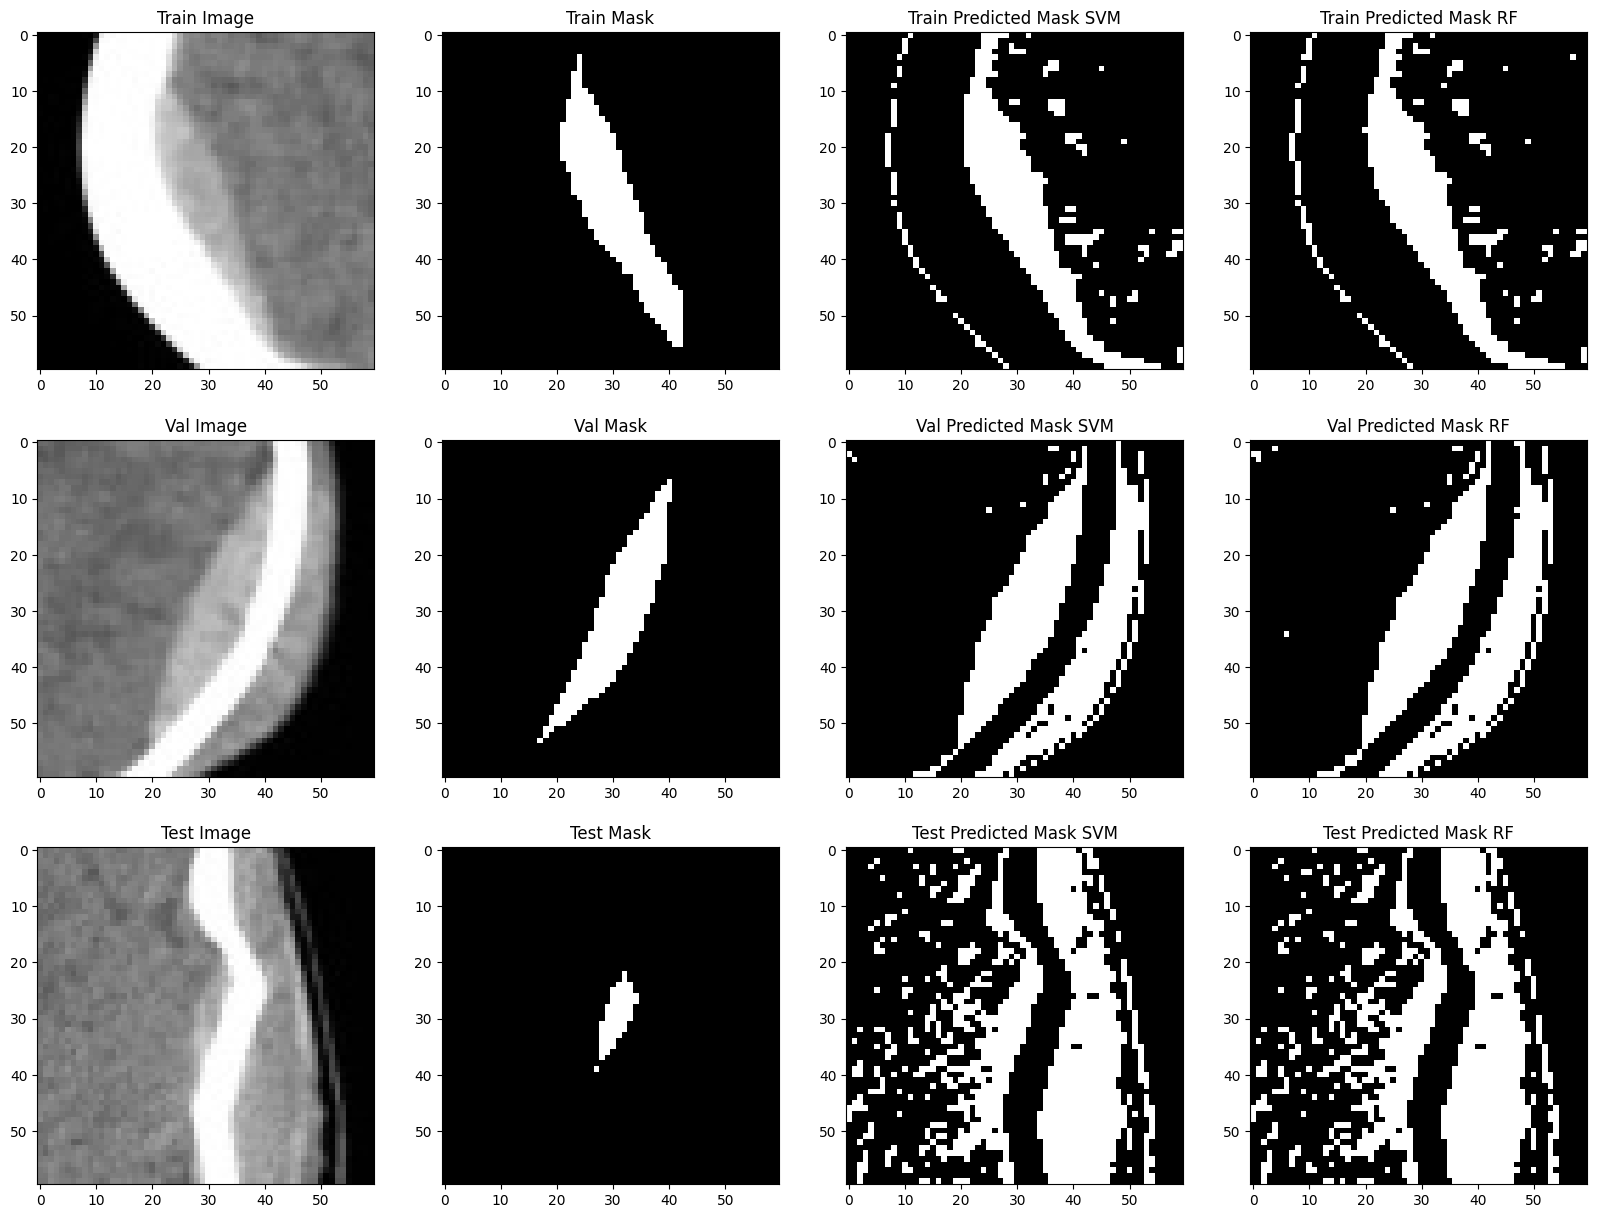

In [38]:

#predict the mask
train_df2['PredictedMask_svm2'] = svm2.predict(train_image_2)
val_df2['PredictedMask_svm2'] = svm2.predict(val_image_2)
test_df2['PredictedMask_svm2'] = svm2.predict(test_image_2)

#predict the mask
train_df2['PredictedMask_rf2'] = rf2.predict(train_image_2)
val_df2['PredictedMask_rf2'] = rf2.predict(val_image_2)
test_df2['PredictedMask_rf2'] = rf2.predict(test_image_2)



# predict the mask
train_df['PredictedMask_svm'] = svm.predict(train_image)
val_df['PredictedMask_svm'] = svm.predict(val_image)
test_df['PredictedMask_svm'] = svm.predict(test_image)

# predict the mask
train_df['PredictedMask_rf'] = rf.predict(train_image)
val_df['PredictedMask_rf'] = rf.predict(val_image)
test_df['PredictedMask_rf'] = rf.predict(test_image)

# convert df back to image and mask
train_image = train_df['Image'].values.reshape(60, 60)
train_mask = train_df['Mask'].values.reshape(60, 60)
train_pred_svm = train_df['PredictedMask_svm'].values.reshape(60, 60)
train_pred_rf = train_df['PredictedMask_rf'].values.reshape(60, 60)

val_image = val_df['Image'].values.reshape(60, 60)
val_mask = val_df['Mask'].values.reshape(60, 60)
val_pred_svm = val_df['PredictedMask_svm'].values.reshape(60, 60)
val_pred_rf = val_df['PredictedMask_rf'].values.reshape(60, 60)

test_image = test_df['Image'].values.reshape(60, 60)
test_mask = test_df['Mask'].values.reshape(60, 60)
test_pred_svm = test_df['PredictedMask_svm'].values.reshape(60, 60)
test_pred_rf = test_df['PredictedMask_rf'].values.reshape(60, 60)



#plot the images
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes[0, 0].imshow(train_image, cmap='gray')
axes[0, 0].set_title("Train Image")
axes[0, 1].imshow(train_mask, cmap='gray')
axes[0, 1].set_title("Train Mask")
axes[0, 2].imshow(train_pred_svm, cmap='gray')
axes[0, 2].set_title("Train Predicted Mask SVM")
axes[0, 3].imshow(train_pred_rf, cmap='gray')
axes[0, 3].set_title("Train Predicted Mask RF")

axes[1, 0].imshow(val_image, cmap='gray')
axes[1, 0].set_title("Val Image")
axes[1, 1].imshow(val_mask, cmap='gray')
axes[1, 1].set_title("Val Mask")
axes[1, 2].imshow(val_pred_svm, cmap='gray')
axes[1, 2].set_title("Val Predicted Mask SVM")
axes[1, 3].imshow(val_pred_rf, cmap='gray')
axes[1, 3].set_title("Val Predicted Mask RF")

axes[2, 0].imshow(test_image, cmap='gray')
axes[2, 0].set_title("Test Image")
axes[2, 1].imshow(test_mask, cmap='gray')
axes[2, 1].set_title("Test Mask")
axes[2, 2].imshow(test_pred_svm, cmap='gray')
axes[2, 2].set_title("Test Predicted Mask SVM")
axes[2, 3].imshow(test_pred_rf, cmap='gray')
axes[2, 3].set_title("Test Predicted Mask RF")

plt.show()

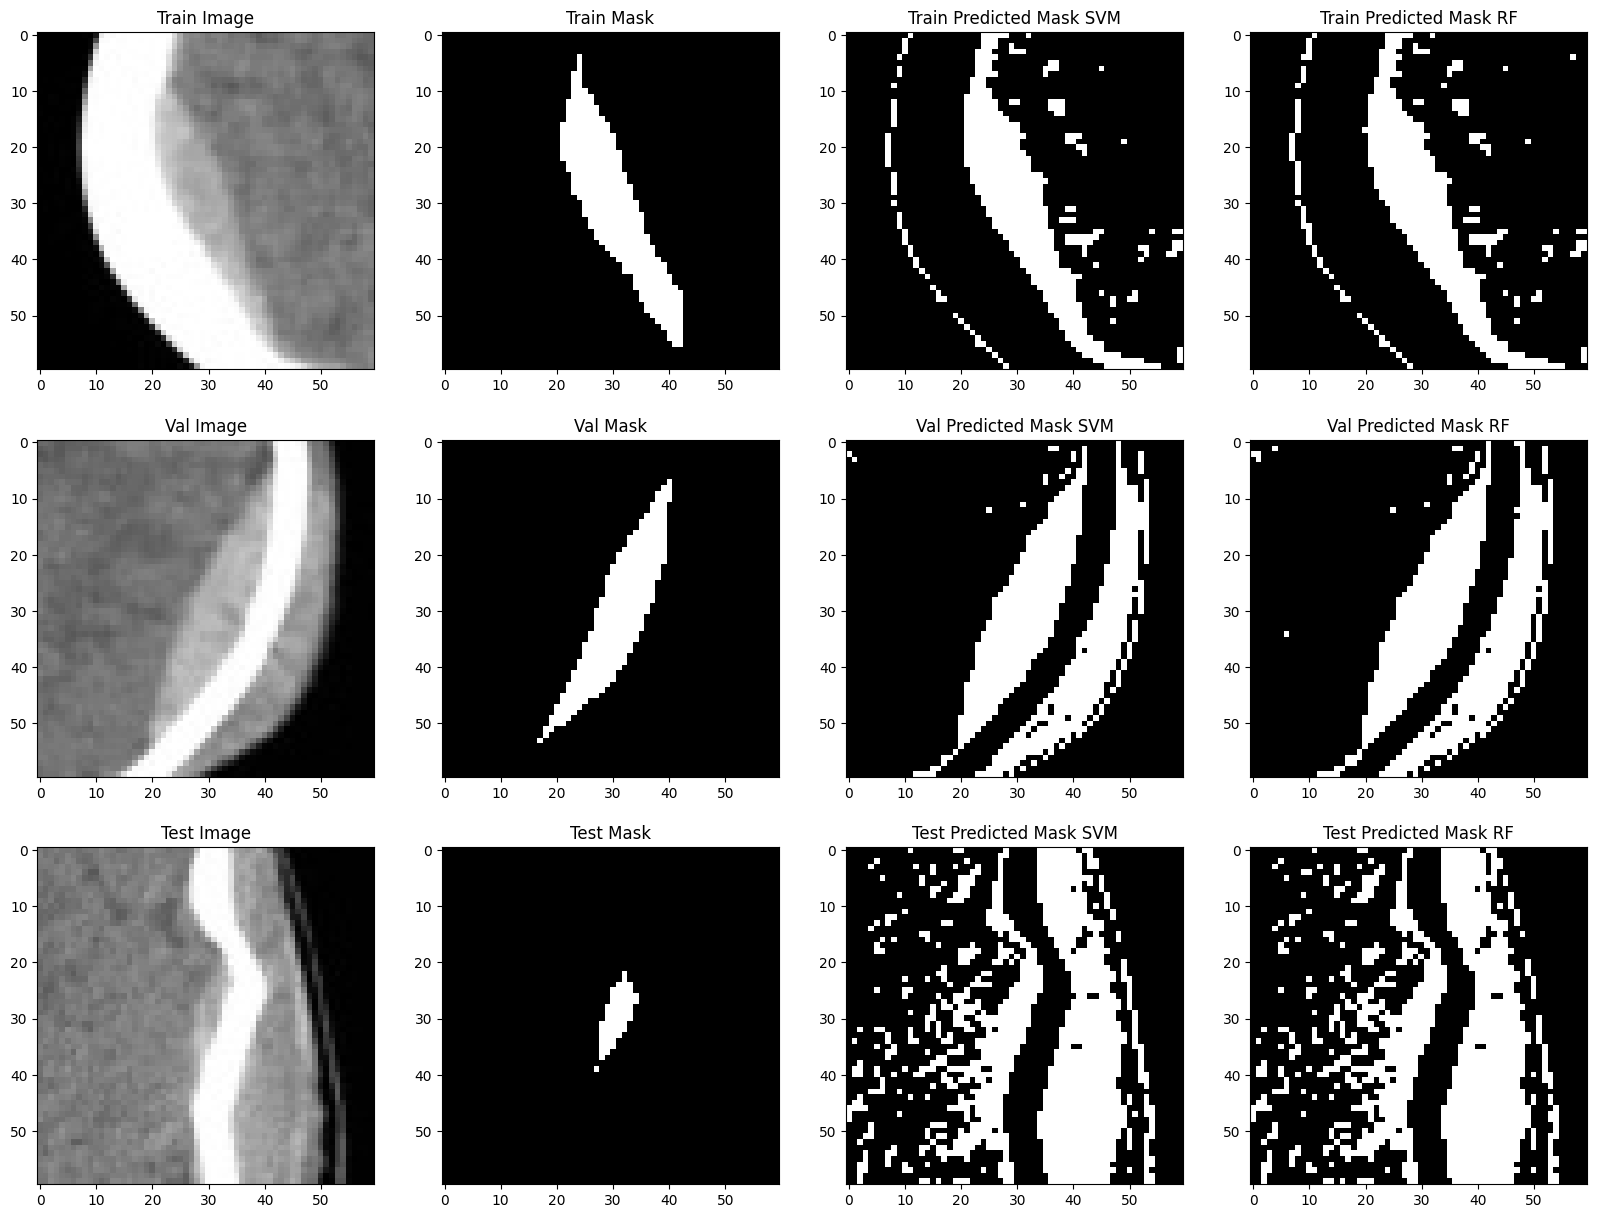

In [39]:
# convert df back to image and mask
train_image = train_df2['Image'].values.reshape(60, 60)
train_mask = train_df2['Mask'].values.reshape(60, 60)
train_pred_svm2 = train_df2['PredictedMask_svm2'].values.reshape(60, 60)
train_pred_rf2 = train_df2['PredictedMask_rf2'].values.reshape(60, 60)

val_image = val_df2['Image'].values.reshape(60, 60)
val_mask = val_df2['Mask'].values.reshape(60, 60)
val_pred_svm2 = val_df2['PredictedMask_svm2'].values.reshape(60, 60)
val_pred_rf2 = val_df2['PredictedMask_rf2'].values.reshape(60, 60)

test_image = test_df2['Image'].values.reshape(60, 60)
test_mask = test_df2['Mask'].values.reshape(60, 60)
test_pred_svm2 = test_df2['PredictedMask_svm2'].values.reshape(60, 60)
test_pred_rf2 = test_df2['PredictedMask_rf2'].values.reshape(60, 60)

#plot the images
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes[0, 0].imshow(train_image, cmap='gray')
axes[0, 0].set_title("Train Image")
axes[0, 1].imshow(train_mask, cmap='gray')
axes[0, 1].set_title("Train Mask")
axes[0, 2].imshow(train_pred_svm, cmap='gray')
axes[0, 2].set_title("Train Predicted Mask SVM")
axes[0, 3].imshow(train_pred_rf, cmap='gray')
axes[0, 3].set_title("Train Predicted Mask RF")

axes[1, 0].imshow(val_image, cmap='gray')
axes[1, 0].set_title("Val Image")
axes[1, 1].imshow(val_mask, cmap='gray')
axes[1, 1].set_title("Val Mask")
axes[1, 2].imshow(val_pred_svm, cmap='gray')
axes[1, 2].set_title("Val Predicted Mask SVM")
axes[1, 3].imshow(val_pred_rf, cmap='gray')
axes[1, 3].set_title("Val Predicted Mask RF")

axes[2, 0].imshow(test_image, cmap='gray')
axes[2, 0].set_title("Test Image")
axes[2, 1].imshow(test_mask, cmap='gray')
axes[2, 1].set_title("Test Mask")
axes[2, 2].imshow(test_pred_svm, cmap='gray')
axes[2, 2].set_title("Test Predicted Mask SVM")
axes[2, 3].imshow(test_pred_rf, cmap='gray')
axes[2, 3].set_title("Test Predicted Mask RF")

plt.show()

In [40]:
#From comparing idea 1 to idea 2, we observe a decrease in accuracy alongside an increase in TPR and dice score. 
#However, it's important to note that idea 2 is merely a heuristic that can occasionally enhance model performance, 
#but it does not do so in our case.


# Q2, Q3, Q5

## Utils

In [1]:
!pip install monai segmentation-models-pytorch -q

In [2]:
# import libraries
import os
import cv2
import random
import numpy as np

# torch libraries 
import torch
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from monai.metrics import GeneralizedDiceScore
from monai.metrics import compute_generalized_dice

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Augmentation for the dataset
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
], p=1.0)

def augment_data(image, mask):
    augmented = augmentation(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [4]:
def file_to_tensor(directory_path, mask_path, augment=False, num_aug=1):
    file_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

    images = []
    masks = []

    for file_path in file_paths:
        mask_file_name = os.path.basename(file_path).replace(".jpg", ".png")
        mask_file_path = os.path.join(mask_path, mask_file_name)

        # read the image and mask
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        if image.shape == (256, 256) and mask.shape == (256, 256):
            #check if mask is all 0
            if np.all(mask == 0):
                continue
            if augment:
                t = num_aug
                while t:
                    # augment the data
                    image_aug, mask_aug = augment_data(image, mask)
                    image_aug = image_aug.astype('float32') / 255.0
                    mask_aug = mask_aug.astype('float32') /255.0
                    images.append(image_aug)
                    masks.append(mask_aug)
                    t -= 1

            image = image.astype('float32') / 255.0
            mask = mask.astype('float32') /255.0

            images.append(image)
            masks.append(mask)
    # reshape the images and masks
    images = np.array(images).reshape(-1, 1, 256, 256)
    masks = np.array(masks).reshape(-1, 1, 256, 256)

    images_tensor = torch.tensor(images, dtype=torch.float32)
    masks_tensor = torch.tensor(masks, dtype=torch.float32)

    return images_tensor, masks_tensor

In [5]:
class basicCNN(nn.Module):
    def __init__(self):
        super(basicCNN, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(32)   # Batch Normalization
        self.relu1 = nn.ReLU()

        self.encoder_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(64)   # Batch Normalization
        self.relu2 = nn.ReLU()

        self.encoder_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.encoder_pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        self.relu3 = nn.ReLU()

        self.encoder_conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # Decoder
        self.decoder_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.bn4 = nn.BatchNorm2d(128)  # Batch Normalization
        self.relu5 = nn.ReLU()

        self.decoder_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.bn5 = nn.BatchNorm2d(64)   # Batch Normalization
        self.relu6 = nn.ReLU()

        self.decoder_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.decoder_upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.bn6 = nn.BatchNorm2d(32)   # Batch Normalization
        self.relu7 = nn.ReLU()

        self.decoder_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = self.encoder_pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.encoder_conv2(x)
        x = self.encoder_pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.encoder_conv3(x)
        x = self.encoder_pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.encoder_conv4(x)
        x = self.relu4(x)

        # Decoder
        x = self.decoder_conv1(x)
        x = self.decoder_upsample1(x)
        x = self.bn4(x)
        x = self.relu5(x)

        x = self.decoder_conv2(x)
        x = self.decoder_upsample2(x)
        x = self.bn5(x)
        x = self.relu6(x)

        x = self.decoder_conv3(x)
        x = self.decoder_upsample3(x)
        x = self.bn6(x)
        x = self.relu7(x)

        x = self.decoder_conv4(x)

        return x


In [6]:
class UNetResNet50Grayscale(nn.Module):
    def __init__(self):
        super(UNetResNet50Grayscale, self).__init__()
        # Load the pre-trained U-Net with ResNet50 as the backbone
        self.model = smp.Unet(
            encoder_name="resnet50",        # Use ResNet50 as backbone
            encoder_weights="imagenet",     # Use pre-trained weights from ImageNet
            in_channels=1,                  
            classes=1,                      
        )
        
        
    
    def forward(self, x):
        return self.model(x)

In [7]:
#inspired by pytorch example and various blogs
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.005, path='checkpoint.pt', trace_func=print):
        # Initialization of class variables
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_score = None
        self.last_score = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss
        # check if the model just started training
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta: # check if the score is less than the best score
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        self.last_score = min(val_loss, self.best_score)

    def save_checkpoint(self, val_loss, model): # save the model
        if self.verbose:
            if self.last_score == np.inf:
                self.trace_func(f'fist save with Validation loss --> {val_loss:.6f}).  Saving model ...')
            else:
                self.trace_func(f'Validation loss decreased ({-1*self.last_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss


In [8]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    # Convert tensors to CPU and then to numpy arrays
    train_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in train_losses]
    val_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in val_losses]
    train_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in train_accuracies]
    val_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in val_accuracies]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot training and validation loss
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].legend()

    # Plot training and validation accuracy
    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].legend()

    plt.show()

In [114]:
def true_positive_rate(y_true, y_pred, device):
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    
    tp = torch.sum((y_true == 1) & (y_pred == 1))
    fn = torch.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn)

def accuracy(y_true, y_pred, device):
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    tp = torch.sum((y_true == 1) & (y_pred == 1))
    tn = torch.sum((y_true == 0) & (y_pred == 0))
    fp = torch.sum((y_true == 0) & (y_pred == 1))
    fn = torch.sum((y_true == 1) & (y_pred == 0))
    return (tp + tn) / (tp + tn + fp + fn)

In [10]:
def plot_sample(image, true_mask, pred_mask, title):
    # Plot the image, true mask, and predicted mask
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.set_title('Input Image')
    ax2.imshow(true_mask.squeeze(), cmap='gray')
    ax2.set_title('True Mask')
    ax3.imshow(pred_mask.squeeze(), cmap='gray')
    ax3.set_title('Predicted Mask')
    plt.suptitle(title)
    plt.show()

In [11]:
def calculate_metrics(model, data_loader,loss_function, plot_image, device):
    model.eval()

    dice_metric = GeneralizedDiceScore(include_background=True, reduction="mean_batch")

    commulative_tpr = 0
    commulative_accuracy = 0
    commulative_dice = 0
    commulative_loss = 0

    total_valid_samples = 0
    invalid_samples = 0

    # Iterate over the data and calculate metrics

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = loss_function(outputs, masks)

            output_sig = nn.functional.sigmoid(outputs)

            preds = (output_sig > 0.5).float()

            if plot_image:
                j = random.randint(0, images.shape[0] - 1)

                plot_sample(images[j].cpu(), masks[j].cpu(), preds[j].cpu(), "Sample Prediction")

            # check if all predictions are 0 or 1
            if torch.all(preds == 0) or torch.all(preds == 1):
                invalid_samples += 1
                print("All predictions are 0 or 1, cannot calculate metrics")
                continue

            tpr = true_positive_rate(masks, preds, device)
            acc = accuracy(masks, preds, device)
            dice = compute_generalized_dice(preds, masks, include_background=True)

            commulative_tpr += tpr
            commulative_accuracy += acc
            commulative_dice += dice.mean().item()
            commulative_loss += loss.item()

            total_valid_samples += 1
        
        if total_valid_samples == 0:
            print("No valid samples to calculate metrics")
            return {}
        
        avg_tpr = commulative_tpr / total_valid_samples
        avg_accuracy = commulative_accuracy / total_valid_samples
        avg_dice = commulative_dice / total_valid_samples
        avg_loss = commulative_loss / total_valid_samples

        return {
            "TPR": avg_tpr.item(),
            "Accuracy": avg_accuracy.item(),
            "Dice": avg_dice,
            "Loss": avg_loss
        }

In [12]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=100, patience=10, l1_lambda=0.0):
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='checkpoint.pt')

    # Move the model to the specified device (CPU or GPU)
    model.to(device)

    # Initialize lists to store loss and accuracy values for plotting
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    # Main training loop
    for epoch in range(num_epochs):
        # Initialize variables for tracking loss and accuracy
        running_loss, running_accuracy = 0.0, 0.0
        model.train()  # Set model to training mode

        # Training phase
        for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(outputs, masks)

            if l1_lambda > 0:
                l1_loss = 0
                for param in model.parameters():
                    l1_loss += torch.norm(param, 1)
                loss += l1_lambda * l1_loss

            output_sig = nn.functional.sigmoid(outputs)  # Apply sigmoid activation
            preds = (output_sig > 0.5).float()
            running_accuracy += accuracy(masks, preds, device)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss and accuracy across all training batches
        train_loss = running_loss / len(train_loader)
        train_accuracy = running_accuracy / len(train_loader)

        # Validation phase
        val_metrics = calculate_metrics(model, val_loader, loss_fn, False, device)
        # check if empty dictionary revert to last best model
        if not val_metrics:
            model.load_state_dict(torch.load('checkpoint.pt'))
            continue
        val_loss = val_metrics['Loss']
        val_accuracy = val_metrics['Accuracy']

        # Update lists for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Check for early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    # Plot the training and validation loss and accuracy
    plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

    # Calculate metrics on the validation set
    val_metrics = calculate_metrics(model, val_loader, loss_fn, False, device)
    print(f"Validation Metrics: {val_metrics}")
    print("\n")
    print("------------------------------------------------------------------------------------------------------------------")
    print(f"Train Metrics: {calculate_metrics(model, train_loader, loss_fn, False, device)}")
    print("\n")
    print("------------------------------------------------------------------------------------------------------------------")

    return model

## Q2

In [13]:
dataset1 = "/kaggle/input/aimiassigmnet2/Dataset1"

train_files_dir = os.path.join(dataset1, "TrainFiles")
train_mask_dir = os.path.join(dataset1, "TrainMask")
val_files_dir = os.path.join(dataset1, "ValFiles")
val_mask_dir = os.path.join(dataset1, "ValMask")
test_files_dir = os.path.join(dataset1, "TestFiles")
test_mask_dir = os.path.join(dataset1, "TestMask")

train_dataset_tensor, train_mask_tensor = file_to_tensor(train_files_dir, train_mask_dir, augment=False, num_aug= 3)
val_dataset_tensor, val_mask_tensor = file_to_tensor(val_files_dir, val_mask_dir, augment=False)
test_dataset_tensor, test_mask_tensor = file_to_tensor(test_files_dir, test_mask_dir, augment=False)

print(train_dataset_tensor.shape, train_mask_tensor.shape)
print(val_dataset_tensor.shape, val_mask_tensor.shape)
print(test_dataset_tensor.shape, test_mask_tensor.shape)

torch.Size([202, 1, 256, 256]) torch.Size([202, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])


In [14]:
train_dataset = TensorDataset(train_dataset_tensor, train_mask_tensor)
val_dataset = TensorDataset(val_dataset_tensor, val_mask_tensor)
test_dataset = TensorDataset(test_dataset_tensor, test_mask_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
model = basicCNN()
#model = UNetResNet50Grayscale()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = smp.losses.DiceLoss("binary")

#optimizer = optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 1000
patience = 30

l1_lambda = 0.0

Epoch 1/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.9650, Train Accuracy: 0.5704, Val Loss: 0.9930, Val Accuracy: 0.9963
fist save with Validation loss --> 0.992991).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.9461, Train Accuracy: 0.7680, Val Loss: 0.9883, Val Accuracy: 0.9771
EarlyStopping counter: 1 out of 30


Epoch 3/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.9216, Train Accuracy: 0.8614, Val Loss: 0.9797, Val Accuracy: 0.9118
Validation loss decreased (0.992991 --> 0.979717).  Saving model ...


Epoch 4/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.8990, Train Accuracy: 0.9063, Val Loss: 0.9629, Val Accuracy: 0.9121
Validation loss decreased (0.979717 --> 0.962931).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.8816, Train Accuracy: 0.9285, Val Loss: 0.9557, Val Accuracy: 0.9212
Validation loss decreased (0.962931 --> 0.955667).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.8662, Train Accuracy: 0.9411, Val Loss: 0.9487, Val Accuracy: 0.9474
Validation loss decreased (0.955667 --> 0.948726).  Saving model ...


Epoch 7/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.8408, Train Accuracy: 0.9543, Val Loss: 0.9458, Val Accuracy: 0.9713
EarlyStopping counter: 1 out of 30


Epoch 8/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.8146, Train Accuracy: 0.9664, Val Loss: 0.9375, Val Accuracy: 0.9851
Validation loss decreased (0.948726 --> 0.937515).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.7824, Train Accuracy: 0.9741, Val Loss: 0.9184, Val Accuracy: 0.9802
Validation loss decreased (0.937515 --> 0.918391).  Saving model ...


Epoch 10/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.7641, Train Accuracy: 0.9773, Val Loss: 0.9137, Val Accuracy: 0.9834
EarlyStopping counter: 1 out of 30


Epoch 11/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.7072, Train Accuracy: 0.9845, Val Loss: 0.9146, Val Accuracy: 0.9910
EarlyStopping counter: 2 out of 30


Epoch 12/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.6777, Train Accuracy: 0.9882, Val Loss: 0.9101, Val Accuracy: 0.9907
Validation loss decreased (0.918391 --> 0.910110).  Saving model ...


Epoch 13/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.6192, Train Accuracy: 0.9908, Val Loss: 0.9218, Val Accuracy: 0.9948
EarlyStopping counter: 1 out of 30


Epoch 14/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.5721, Train Accuracy: 0.9922, Val Loss: 0.8317, Val Accuracy: 0.9946
Validation loss decreased (0.910110 --> 0.831703).  Saving model ...


Epoch 15/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.5617, Train Accuracy: 0.9927, Val Loss: 0.8007, Val Accuracy: 0.9927
Validation loss decreased (0.831703 --> 0.800747).  Saving model ...


Epoch 16/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.5409, Train Accuracy: 0.9921, Val Loss: 0.7995, Val Accuracy: 0.9933
EarlyStopping counter: 1 out of 30


Epoch 17/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.4486, Train Accuracy: 0.9948, Val Loss: 0.8063, Val Accuracy: 0.9948
EarlyStopping counter: 2 out of 30


Epoch 18/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.4221, Train Accuracy: 0.9954, Val Loss: 0.7365, Val Accuracy: 0.9946
Validation loss decreased (0.800747 --> 0.736467).  Saving model ...


Epoch 19/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.3880, Train Accuracy: 0.9955, Val Loss: 0.7483, Val Accuracy: 0.9965
EarlyStopping counter: 1 out of 30


Epoch 20/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.3615, Train Accuracy: 0.9960, Val Loss: 0.9106, Val Accuracy: 0.9948
EarlyStopping counter: 2 out of 30


Epoch 21/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.3457, Train Accuracy: 0.9963, Val Loss: 0.8037, Val Accuracy: 0.9951
EarlyStopping counter: 3 out of 30


Epoch 22/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.3370, Train Accuracy: 0.9962, Val Loss: 0.7823, Val Accuracy: 0.9958
EarlyStopping counter: 4 out of 30


Epoch 23/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.2981, Train Accuracy: 0.9965, Val Loss: 0.7839, Val Accuracy: 0.9942
EarlyStopping counter: 5 out of 30


Epoch 24/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.2875, Train Accuracy: 0.9965, Val Loss: 0.7052, Val Accuracy: 0.9942
Validation loss decreased (0.736467 --> 0.705186).  Saving model ...


Epoch 25/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.2537, Train Accuracy: 0.9970, Val Loss: 0.8676, Val Accuracy: 0.9943
EarlyStopping counter: 1 out of 30


Epoch 26/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.2368, Train Accuracy: 0.9970, Val Loss: 0.8062, Val Accuracy: 0.9941
EarlyStopping counter: 2 out of 30


Epoch 27/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.2608, Train Accuracy: 0.9972, Val Loss: 0.8393, Val Accuracy: 0.9953
EarlyStopping counter: 3 out of 30


Epoch 28/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.2824, Train Accuracy: 0.9965, Val Loss: 0.6712, Val Accuracy: 0.9939
Validation loss decreased (0.705186 --> 0.671158).  Saving model ...


Epoch 29/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.2441, Train Accuracy: 0.9968, Val Loss: 0.6137, Val Accuracy: 0.9955
Validation loss decreased (0.671158 --> 0.613735).  Saving model ...


Epoch 30/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.2122, Train Accuracy: 0.9973, Val Loss: 0.8098, Val Accuracy: 0.9944
EarlyStopping counter: 1 out of 30


Epoch 31/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.2215, Train Accuracy: 0.9973, Val Loss: 0.8697, Val Accuracy: 0.9952
EarlyStopping counter: 2 out of 30


Epoch 32/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.1983, Train Accuracy: 0.9974, Val Loss: 0.8421, Val Accuracy: 0.9952
EarlyStopping counter: 3 out of 30


Epoch 33/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.2113, Train Accuracy: 0.9972, Val Loss: 0.8471, Val Accuracy: 0.9953
EarlyStopping counter: 4 out of 30


Epoch 34/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.2142, Train Accuracy: 0.9973, Val Loss: 0.8600, Val Accuracy: 0.9954
EarlyStopping counter: 5 out of 30


Epoch 35/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.2274, Train Accuracy: 0.9971, Val Loss: 0.6839, Val Accuracy: 0.9946
EarlyStopping counter: 6 out of 30


Epoch 36/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.2000, Train Accuracy: 0.9974, Val Loss: 0.7119, Val Accuracy: 0.9953
EarlyStopping counter: 7 out of 30


Epoch 37/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.1783, Train Accuracy: 0.9976, Val Loss: 0.6905, Val Accuracy: 0.9949
EarlyStopping counter: 8 out of 30


Epoch 38/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.1738, Train Accuracy: 0.9978, Val Loss: 0.7305, Val Accuracy: 0.9954
EarlyStopping counter: 9 out of 30


Epoch 39/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.1579, Train Accuracy: 0.9979, Val Loss: 0.7279, Val Accuracy: 0.9953
EarlyStopping counter: 10 out of 30


Epoch 40/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.1582, Train Accuracy: 0.9980, Val Loss: 0.7914, Val Accuracy: 0.9958
EarlyStopping counter: 11 out of 30


Epoch 41/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.1565, Train Accuracy: 0.9979, Val Loss: 0.8041, Val Accuracy: 0.9955
EarlyStopping counter: 12 out of 30


Epoch 42/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.1581, Train Accuracy: 0.9978, Val Loss: 0.7484, Val Accuracy: 0.9957
EarlyStopping counter: 13 out of 30


Epoch 43/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.1753, Train Accuracy: 0.9977, Val Loss: 0.7049, Val Accuracy: 0.9954
EarlyStopping counter: 14 out of 30


Epoch 44/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.1775, Train Accuracy: 0.9976, Val Loss: 0.6428, Val Accuracy: 0.9956
EarlyStopping counter: 15 out of 30


Epoch 45/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.1699, Train Accuracy: 0.9976, Val Loss: 0.7460, Val Accuracy: 0.9954
EarlyStopping counter: 16 out of 30


Epoch 46/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.1600, Train Accuracy: 0.9979, Val Loss: 0.8398, Val Accuracy: 0.9953
EarlyStopping counter: 17 out of 30


Epoch 47/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.1531, Train Accuracy: 0.9979, Val Loss: 0.7216, Val Accuracy: 0.9959
EarlyStopping counter: 18 out of 30


Epoch 48/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.1404, Train Accuracy: 0.9981, Val Loss: 0.6648, Val Accuracy: 0.9950
EarlyStopping counter: 19 out of 30


Epoch 49/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.1310, Train Accuracy: 0.9982, Val Loss: 0.6467, Val Accuracy: 0.9952
EarlyStopping counter: 20 out of 30


Epoch 50/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.1277, Train Accuracy: 0.9983, Val Loss: 0.7246, Val Accuracy: 0.9956
EarlyStopping counter: 21 out of 30


Epoch 51/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.1252, Train Accuracy: 0.9983, Val Loss: 0.6927, Val Accuracy: 0.9953
EarlyStopping counter: 22 out of 30


Epoch 52/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.1301, Train Accuracy: 0.9982, Val Loss: 0.6229, Val Accuracy: 0.9955
EarlyStopping counter: 23 out of 30


Epoch 53/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.1345, Train Accuracy: 0.9982, Val Loss: 0.6495, Val Accuracy: 0.9958
EarlyStopping counter: 24 out of 30


Epoch 54/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.1352, Train Accuracy: 0.9983, Val Loss: 0.6265, Val Accuracy: 0.9959
EarlyStopping counter: 25 out of 30


Epoch 55/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.1250, Train Accuracy: 0.9983, Val Loss: 0.6480, Val Accuracy: 0.9956
EarlyStopping counter: 26 out of 30


Epoch 56/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.1188, Train Accuracy: 0.9984, Val Loss: 0.6974, Val Accuracy: 0.9954
EarlyStopping counter: 27 out of 30


Epoch 57/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.1153, Train Accuracy: 0.9984, Val Loss: 0.6599, Val Accuracy: 0.9959
EarlyStopping counter: 28 out of 30


Epoch 58/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.1071, Train Accuracy: 0.9985, Val Loss: 0.6923, Val Accuracy: 0.9959
EarlyStopping counter: 29 out of 30


Epoch 59/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/1000], Train Loss: 0.1049, Train Accuracy: 0.9986, Val Loss: 0.6375, Val Accuracy: 0.9955
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2137310240.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


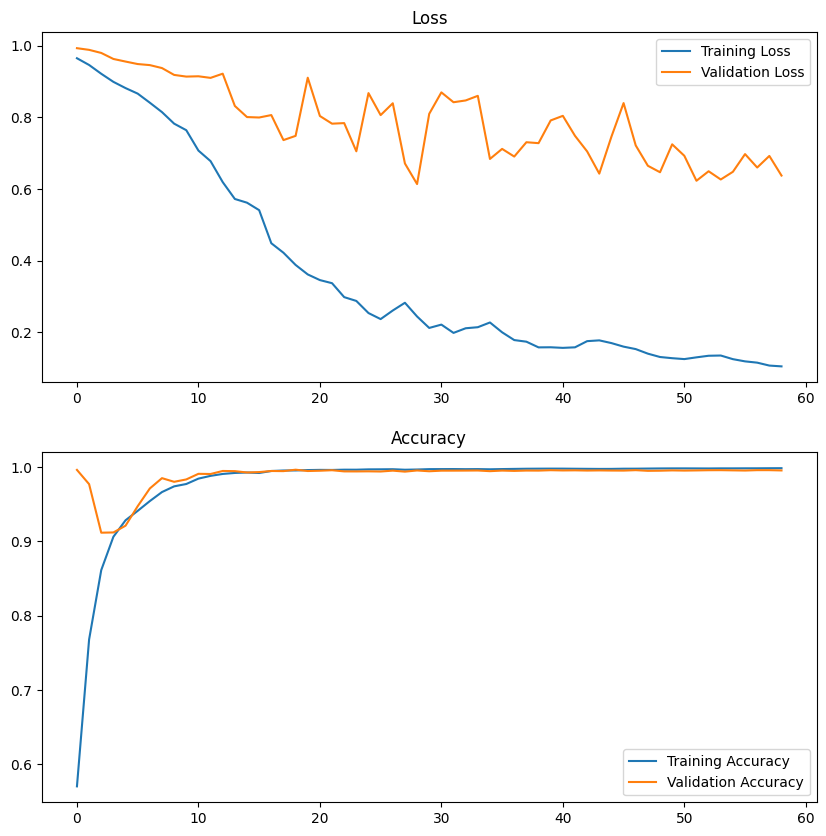

Validation Metrics: {'TPR': 0.48944321274757385, 'Accuracy': 0.9954848289489746, 'Dice': 0.32110532000660896, 'Loss': 0.6137346923351288}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.8682935833930969, 'Accuracy': 0.9968336820602417, 'Dice': 0.6272081411801852, 'Loss': 0.23773842591505784}


------------------------------------------------------------------------------------------------------------------


In [18]:
# Train the model
model = train_model(model, train_loader, val_loader, loss_function, optimizer, device, num_epochs, patience, l1_lambda)

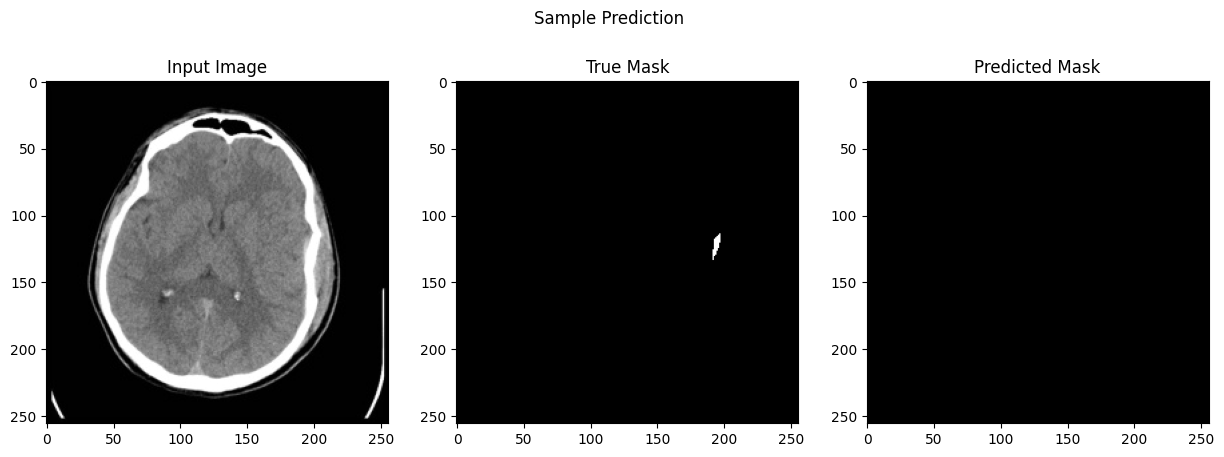

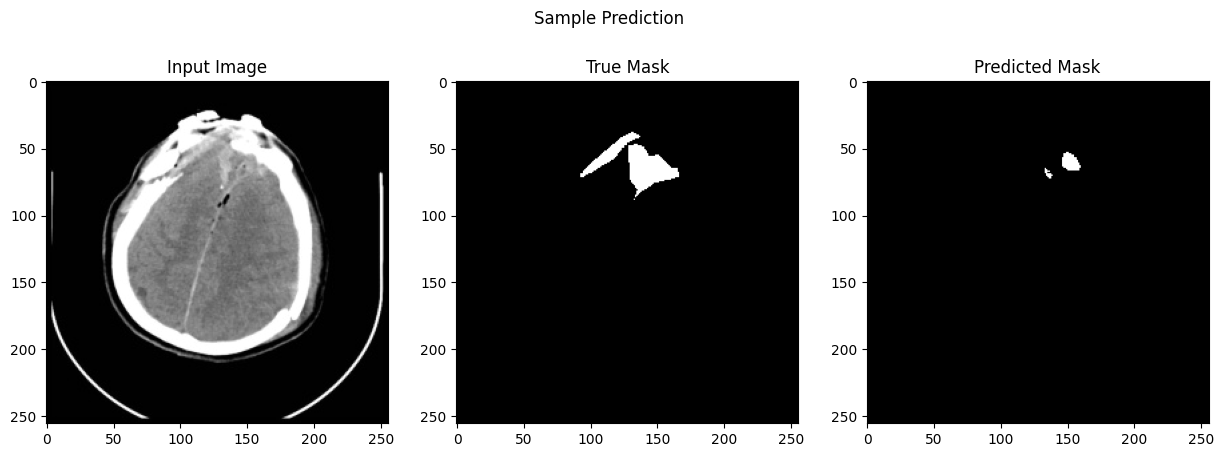

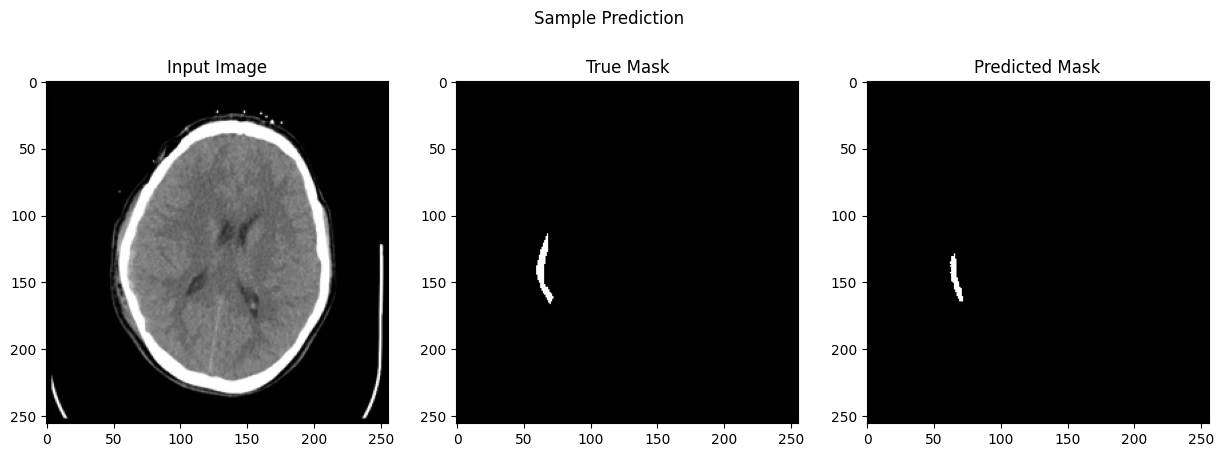

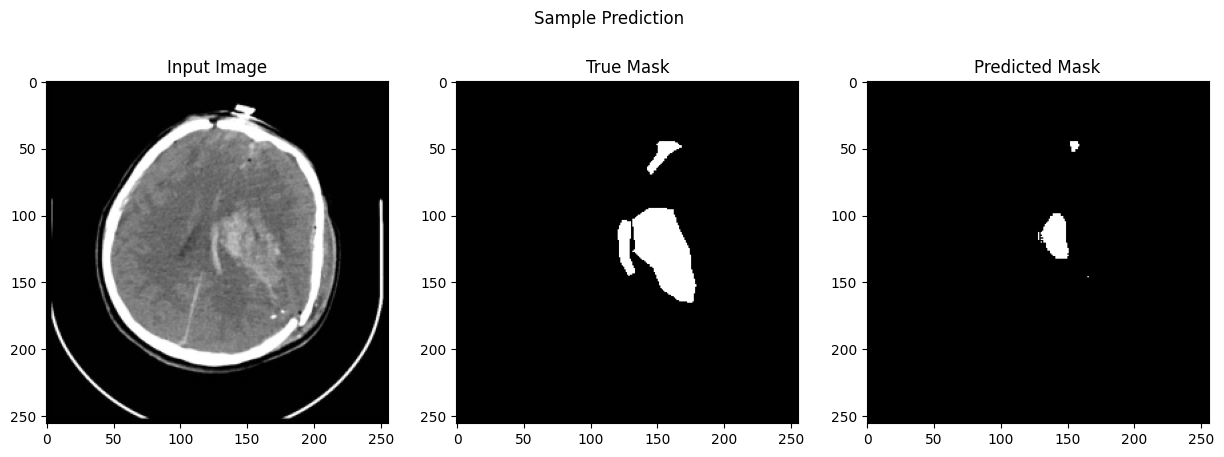

Test Metrics: {'TPR': 0.36062297224998474, 'Accuracy': 0.990433931350708, 'Dice': 0.35408706218004227, 'Loss': 0.578143835067749}


In [20]:
# Calculate metrics on the test set
test_metrics = calculate_metrics(model, test_loader, loss_function, True, device)
print(f"Test Metrics: {test_metrics}")

## Q3

In [21]:
dataset1 = "/kaggle/input/aimiassigmnet2/Dataset1"

# Load the dataset
train_files_dir = os.path.join(dataset1, "TrainFiles")
train_mask_dir = os.path.join(dataset1, "TrainMask")
val_files_dir = os.path.join(dataset1, "ValFiles")
val_mask_dir = os.path.join(dataset1, "ValMask")
test_files_dir = os.path.join(dataset1, "TestFiles")
test_mask_dir = os.path.join(dataset1, "TestMask")

train_dataset_tensor, train_mask_tensor = file_to_tensor(train_files_dir, train_mask_dir, augment=False, num_aug= 3)
val_dataset_tensor, val_mask_tensor = file_to_tensor(val_files_dir, val_mask_dir, augment=False)
test_dataset_tensor, test_mask_tensor = file_to_tensor(test_files_dir, test_mask_dir, augment=False)

print(train_dataset_tensor.shape, train_mask_tensor.shape)
print(val_dataset_tensor.shape, val_mask_tensor.shape)
print(test_dataset_tensor.shape, test_mask_tensor.shape)

torch.Size([202, 1, 256, 256]) torch.Size([202, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])


In [22]:
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_dataset_tensor, train_mask_tensor)
val_dataset = TensorDataset(val_dataset_tensor, val_mask_tensor)
test_dataset = TensorDataset(test_dataset_tensor, test_mask_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
# Define a composite loss function
class CompositeLoss(nn.Module):
    def __init__(self):
        super(CompositeLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss("binary")
        self.focal_loss = smp.losses.FocalLoss("binary")

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        focal = self.focal_loss(y_pred, y_true)
        return 0.75* dice  + 0.25*focal # 75% dice loss and 25% focal loss

In [24]:
# Define a list of loss functions
loss_functions = [
    smp.losses.DiceLoss("binary"),
    smp.losses.JaccardLoss("binary"),
    smp.losses.FocalLoss("binary"),
    CompositeLoss()
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = [basicCNN() for _ in range(len(loss_functions))] # Create a list of models for each loss function

optimizers = [optim.Adam(model.parameters(), lr=0.0001) for model in models] # Create a list of optimizers for each model

final_trained_model = [] # List to store the final trained model for each loss function

num_epochs = 1000
patience = 30

------------------------------------------------------------------------------------------------------------------
Training Model 1 with DiceLoss


Epoch 1/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
No valid samples to calculate metrics


/tmp/ipykernel_30/2137310240.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.2344, Train Accuracy: 0.9970, Val Loss: 0.8982, Val Accuracy: 0.9963
fist save with Validation loss --> 0.898232).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.2217, Train Accuracy: 0.9971, Val Loss: 0.9064, Val Accuracy: 0.9954
EarlyStopping counter: 1 out of 30


Epoch 4/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.2062, Train Accuracy: 0.9974, Val Loss: 0.6306, Val Accuracy: 0.9958
Validation loss decreased (0.898232 --> 0.630618).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.1918, Train Accuracy: 0.9974, Val Loss: 0.7379, Val Accuracy: 0.9949
EarlyStopping counter: 1 out of 30


Epoch 6/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.1926, Train Accuracy: 0.9975, Val Loss: 0.8423, Val Accuracy: 0.9954
EarlyStopping counter: 2 out of 30


Epoch 7/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.1849, Train Accuracy: 0.9973, Val Loss: 0.7916, Val Accuracy: 0.9954
EarlyStopping counter: 3 out of 30


Epoch 8/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.1934, Train Accuracy: 0.9973, Val Loss: 0.9411, Val Accuracy: 0.9953
EarlyStopping counter: 4 out of 30


Epoch 9/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.1869, Train Accuracy: 0.9975, Val Loss: 0.8632, Val Accuracy: 0.9949
EarlyStopping counter: 5 out of 30


Epoch 10/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.1712, Train Accuracy: 0.9977, Val Loss: 0.6731, Val Accuracy: 0.9956
EarlyStopping counter: 6 out of 30


Epoch 11/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.1632, Train Accuracy: 0.9978, Val Loss: 0.6817, Val Accuracy: 0.9955
EarlyStopping counter: 7 out of 30


Epoch 12/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.1533, Train Accuracy: 0.9979, Val Loss: 0.7579, Val Accuracy: 0.9951
EarlyStopping counter: 8 out of 30


Epoch 13/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.1387, Train Accuracy: 0.9981, Val Loss: 0.6679, Val Accuracy: 0.9957
EarlyStopping counter: 9 out of 30


Epoch 14/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.1410, Train Accuracy: 0.9981, Val Loss: 0.7330, Val Accuracy: 0.9955
EarlyStopping counter: 10 out of 30


Epoch 15/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.1465, Train Accuracy: 0.9981, Val Loss: 0.7344, Val Accuracy: 0.9942
EarlyStopping counter: 11 out of 30


Epoch 16/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.1402, Train Accuracy: 0.9980, Val Loss: 0.6667, Val Accuracy: 0.9955
EarlyStopping counter: 12 out of 30


Epoch 17/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.1518, Train Accuracy: 0.9979, Val Loss: 0.8195, Val Accuracy: 0.9950
EarlyStopping counter: 13 out of 30


Epoch 18/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.1433, Train Accuracy: 0.9981, Val Loss: 0.7591, Val Accuracy: 0.9959
EarlyStopping counter: 14 out of 30


Epoch 19/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.1324, Train Accuracy: 0.9981, Val Loss: 0.7208, Val Accuracy: 0.9951
EarlyStopping counter: 15 out of 30


Epoch 20/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.1139, Train Accuracy: 0.9983, Val Loss: 0.6848, Val Accuracy: 0.9955
EarlyStopping counter: 16 out of 30


Epoch 21/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.1128, Train Accuracy: 0.9983, Val Loss: 0.6183, Val Accuracy: 0.9954
Validation loss decreased (0.630618 --> 0.618294).  Saving model ...


Epoch 22/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.1086, Train Accuracy: 0.9984, Val Loss: 0.6858, Val Accuracy: 0.9957
EarlyStopping counter: 1 out of 30


Epoch 23/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.1323, Train Accuracy: 0.9982, Val Loss: 0.6389, Val Accuracy: 0.9954
EarlyStopping counter: 2 out of 30


Epoch 24/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.1141, Train Accuracy: 0.9984, Val Loss: 0.7469, Val Accuracy: 0.9955
EarlyStopping counter: 3 out of 30


Epoch 25/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.1210, Train Accuracy: 0.9983, Val Loss: 0.6415, Val Accuracy: 0.9949
EarlyStopping counter: 4 out of 30


Epoch 26/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.1223, Train Accuracy: 0.9982, Val Loss: 0.7322, Val Accuracy: 0.9945
EarlyStopping counter: 5 out of 30


Epoch 27/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.1065, Train Accuracy: 0.9984, Val Loss: 0.6650, Val Accuracy: 0.9954
EarlyStopping counter: 6 out of 30


Epoch 28/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.1000, Train Accuracy: 0.9985, Val Loss: 0.5821, Val Accuracy: 0.9954
Validation loss decreased (0.618294 --> 0.582113).  Saving model ...


Epoch 29/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.1042, Train Accuracy: 0.9985, Val Loss: 0.7064, Val Accuracy: 0.9955
EarlyStopping counter: 1 out of 30


Epoch 30/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.1054, Train Accuracy: 0.9984, Val Loss: 0.6635, Val Accuracy: 0.9954
EarlyStopping counter: 2 out of 30


Epoch 31/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.1093, Train Accuracy: 0.9985, Val Loss: 0.7863, Val Accuracy: 0.9954
EarlyStopping counter: 3 out of 30


Epoch 32/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.1017, Train Accuracy: 0.9986, Val Loss: 0.6350, Val Accuracy: 0.9955
EarlyStopping counter: 4 out of 30


Epoch 33/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.1029, Train Accuracy: 0.9986, Val Loss: 0.7854, Val Accuracy: 0.9955
EarlyStopping counter: 5 out of 30


Epoch 34/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.1090, Train Accuracy: 0.9985, Val Loss: 0.7522, Val Accuracy: 0.9953
EarlyStopping counter: 6 out of 30


Epoch 35/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.1016, Train Accuracy: 0.9985, Val Loss: 0.7023, Val Accuracy: 0.9957
EarlyStopping counter: 7 out of 30


Epoch 36/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.1036, Train Accuracy: 0.9985, Val Loss: 0.7598, Val Accuracy: 0.9953
EarlyStopping counter: 8 out of 30


Epoch 37/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.0991, Train Accuracy: 0.9986, Val Loss: 0.5975, Val Accuracy: 0.9960
EarlyStopping counter: 9 out of 30


Epoch 38/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.0918, Train Accuracy: 0.9986, Val Loss: 0.6980, Val Accuracy: 0.9951
EarlyStopping counter: 10 out of 30


Epoch 39/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.0858, Train Accuracy: 0.9988, Val Loss: 0.7270, Val Accuracy: 0.9956
EarlyStopping counter: 11 out of 30


Epoch 40/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.0851, Train Accuracy: 0.9987, Val Loss: 0.7017, Val Accuracy: 0.9954
EarlyStopping counter: 12 out of 30


Epoch 41/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.0810, Train Accuracy: 0.9988, Val Loss: 0.6763, Val Accuracy: 0.9957
EarlyStopping counter: 13 out of 30


Epoch 42/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.0821, Train Accuracy: 0.9988, Val Loss: 0.6187, Val Accuracy: 0.9957
EarlyStopping counter: 14 out of 30


Epoch 43/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.0823, Train Accuracy: 0.9988, Val Loss: 0.7559, Val Accuracy: 0.9955
EarlyStopping counter: 15 out of 30


Epoch 44/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.0879, Train Accuracy: 0.9987, Val Loss: 0.7309, Val Accuracy: 0.9954
EarlyStopping counter: 16 out of 30


Epoch 45/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.0836, Train Accuracy: 0.9988, Val Loss: 0.6911, Val Accuracy: 0.9957
EarlyStopping counter: 17 out of 30


Epoch 46/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.0752, Train Accuracy: 0.9989, Val Loss: 0.6917, Val Accuracy: 0.9952
EarlyStopping counter: 18 out of 30


Epoch 47/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.0755, Train Accuracy: 0.9989, Val Loss: 0.7402, Val Accuracy: 0.9953
EarlyStopping counter: 19 out of 30


Epoch 48/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.0801, Train Accuracy: 0.9989, Val Loss: 0.7690, Val Accuracy: 0.9949
EarlyStopping counter: 20 out of 30


Epoch 49/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.0772, Train Accuracy: 0.9989, Val Loss: 0.7017, Val Accuracy: 0.9954
EarlyStopping counter: 21 out of 30


Epoch 50/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.0710, Train Accuracy: 0.9989, Val Loss: 0.6484, Val Accuracy: 0.9954
EarlyStopping counter: 22 out of 30


Epoch 51/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.0740, Train Accuracy: 0.9989, Val Loss: 0.7037, Val Accuracy: 0.9958
EarlyStopping counter: 23 out of 30


Epoch 52/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.0750, Train Accuracy: 0.9989, Val Loss: 0.6565, Val Accuracy: 0.9954
EarlyStopping counter: 24 out of 30


Epoch 53/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.0700, Train Accuracy: 0.9990, Val Loss: 0.7427, Val Accuracy: 0.9956
EarlyStopping counter: 25 out of 30


Epoch 54/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.0684, Train Accuracy: 0.9990, Val Loss: 0.6701, Val Accuracy: 0.9954
EarlyStopping counter: 26 out of 30


Epoch 55/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.0745, Train Accuracy: 0.9989, Val Loss: 0.8188, Val Accuracy: 0.9953
EarlyStopping counter: 27 out of 30


Epoch 56/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.0819, Train Accuracy: 0.9988, Val Loss: 0.6900, Val Accuracy: 0.9953
EarlyStopping counter: 28 out of 30


Epoch 57/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.0858, Train Accuracy: 0.9987, Val Loss: 0.6152, Val Accuracy: 0.9950
EarlyStopping counter: 29 out of 30


Epoch 58/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.0745, Train Accuracy: 0.9989, Val Loss: 0.6357, Val Accuracy: 0.9960
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2137310240.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


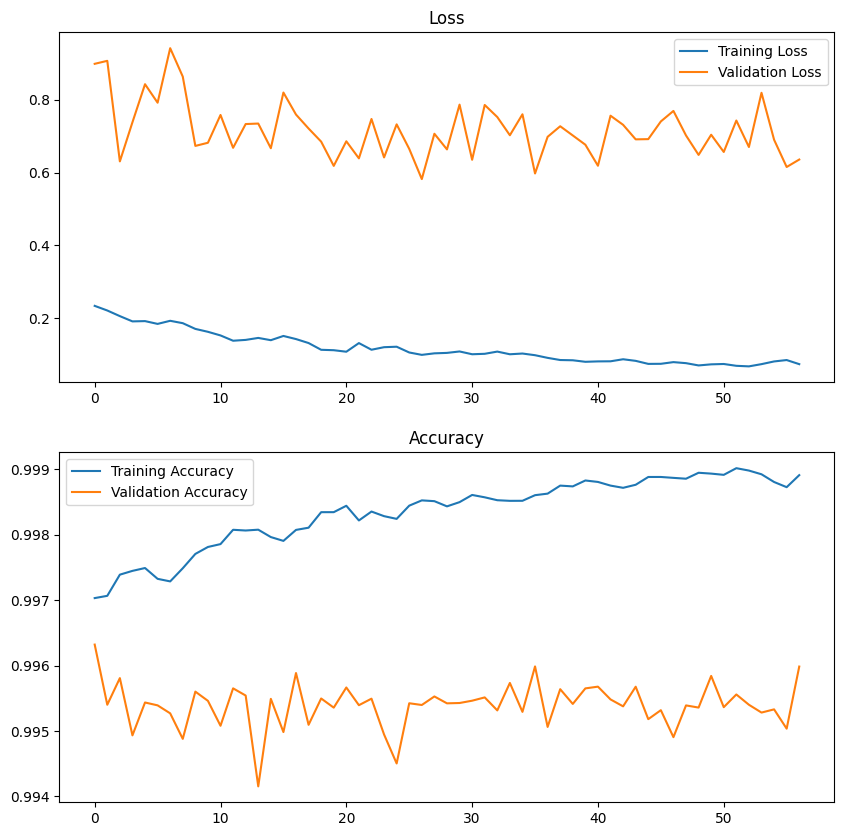

Validation Metrics: {'TPR': 0.47197043895721436, 'Accuracy': 0.9953982830047607, 'Dice': 0.3380393423140049, 'Loss': 0.5821131467819214}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.9360529184341431, 'Accuracy': 0.9981042742729187, 'Dice': 0.7480290211164035, 'Loss': 0.12125112460209773}


------------------------------------------------------------------------------------------------------------------
Model 1 training complete.


------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Training Model 2 with JaccardLoss


Epoch 1/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
No valid samples to calculate metrics


Epoch 2/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.2051, Train Accuracy: 0.9983, Val Loss: 0.8386, Val Accuracy: 0.9956
fist save with Validation loss --> 0.838649).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.1949, Train Accuracy: 0.9984, Val Loss: 0.8481, Val Accuracy: 0.9952
EarlyStopping counter: 1 out of 30


Epoch 4/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.1906, Train Accuracy: 0.9985, Val Loss: 0.8214, Val Accuracy: 0.9945
Validation loss decreased (0.838649 --> 0.821354).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.1942, Train Accuracy: 0.9984, Val Loss: 0.7751, Val Accuracy: 0.9951
Validation loss decreased (0.821354 --> 0.775137).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.1991, Train Accuracy: 0.9983, Val Loss: 0.8592, Val Accuracy: 0.9950
EarlyStopping counter: 1 out of 30


Epoch 7/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.1934, Train Accuracy: 0.9984, Val Loss: 0.8709, Val Accuracy: 0.9951
EarlyStopping counter: 2 out of 30


Epoch 8/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.1728, Train Accuracy: 0.9986, Val Loss: 0.8170, Val Accuracy: 0.9956
EarlyStopping counter: 3 out of 30


Epoch 9/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.1623, Train Accuracy: 0.9987, Val Loss: 0.8331, Val Accuracy: 0.9953
EarlyStopping counter: 4 out of 30


Epoch 10/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.1615, Train Accuracy: 0.9987, Val Loss: 0.7603, Val Accuracy: 0.9957
Validation loss decreased (0.775137 --> 0.760325).  Saving model ...


Epoch 11/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.1637, Train Accuracy: 0.9987, Val Loss: 0.7954, Val Accuracy: 0.9953
EarlyStopping counter: 1 out of 30


Epoch 12/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.1618, Train Accuracy: 0.9987, Val Loss: 0.8284, Val Accuracy: 0.9957
EarlyStopping counter: 2 out of 30


Epoch 13/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.1856, Train Accuracy: 0.9985, Val Loss: 0.7812, Val Accuracy: 0.9954
EarlyStopping counter: 3 out of 30


Epoch 14/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.1644, Train Accuracy: 0.9986, Val Loss: 0.7996, Val Accuracy: 0.9955
EarlyStopping counter: 4 out of 30


Epoch 15/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.1587, Train Accuracy: 0.9988, Val Loss: 0.8676, Val Accuracy: 0.9954
EarlyStopping counter: 5 out of 30


Epoch 16/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.1541, Train Accuracy: 0.9987, Val Loss: 0.7878, Val Accuracy: 0.9956
EarlyStopping counter: 6 out of 30


Epoch 17/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.1411, Train Accuracy: 0.9988, Val Loss: 0.8216, Val Accuracy: 0.9955
EarlyStopping counter: 7 out of 30


Epoch 18/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.1398, Train Accuracy: 0.9989, Val Loss: 0.7919, Val Accuracy: 0.9954
EarlyStopping counter: 8 out of 30


Epoch 19/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.1493, Train Accuracy: 0.9988, Val Loss: 0.8934, Val Accuracy: 0.9955
EarlyStopping counter: 9 out of 30


Epoch 20/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.1424, Train Accuracy: 0.9988, Val Loss: 0.7819, Val Accuracy: 0.9956
EarlyStopping counter: 10 out of 30


Epoch 21/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.1340, Train Accuracy: 0.9989, Val Loss: 0.8173, Val Accuracy: 0.9955
EarlyStopping counter: 11 out of 30


Epoch 22/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.1380, Train Accuracy: 0.9989, Val Loss: 0.7812, Val Accuracy: 0.9955
EarlyStopping counter: 12 out of 30


Epoch 23/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.1401, Train Accuracy: 0.9989, Val Loss: 0.8774, Val Accuracy: 0.9954
EarlyStopping counter: 13 out of 30


Epoch 24/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.1559, Train Accuracy: 0.9988, Val Loss: 0.7327, Val Accuracy: 0.9951
Validation loss decreased (0.760325 --> 0.732709).  Saving model ...


Epoch 25/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.1455, Train Accuracy: 0.9988, Val Loss: 0.8202, Val Accuracy: 0.9951
EarlyStopping counter: 1 out of 30


Epoch 26/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.1316, Train Accuracy: 0.9990, Val Loss: 0.7787, Val Accuracy: 0.9952
EarlyStopping counter: 2 out of 30


Epoch 27/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.1484, Train Accuracy: 0.9988, Val Loss: 0.8641, Val Accuracy: 0.9953
EarlyStopping counter: 3 out of 30


Epoch 28/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.1334, Train Accuracy: 0.9990, Val Loss: 0.8394, Val Accuracy: 0.9955
EarlyStopping counter: 4 out of 30


Epoch 29/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.1206, Train Accuracy: 0.9991, Val Loss: 0.8314, Val Accuracy: 0.9953
EarlyStopping counter: 5 out of 30


Epoch 30/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.1152, Train Accuracy: 0.9991, Val Loss: 0.8235, Val Accuracy: 0.9954
EarlyStopping counter: 6 out of 30


Epoch 31/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.1131, Train Accuracy: 0.9991, Val Loss: 0.8005, Val Accuracy: 0.9954
EarlyStopping counter: 7 out of 30


Epoch 32/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.1327, Train Accuracy: 0.9990, Val Loss: 0.8319, Val Accuracy: 0.9955
EarlyStopping counter: 8 out of 30


Epoch 33/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.1200, Train Accuracy: 0.9990, Val Loss: 0.8047, Val Accuracy: 0.9958
EarlyStopping counter: 9 out of 30


Epoch 34/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.1224, Train Accuracy: 0.9991, Val Loss: 0.7470, Val Accuracy: 0.9956
EarlyStopping counter: 10 out of 30


Epoch 35/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.1262, Train Accuracy: 0.9990, Val Loss: 0.7984, Val Accuracy: 0.9958
EarlyStopping counter: 11 out of 30


Epoch 36/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.1177, Train Accuracy: 0.9991, Val Loss: 0.8552, Val Accuracy: 0.9954
EarlyStopping counter: 12 out of 30


Epoch 37/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.1184, Train Accuracy: 0.9990, Val Loss: 0.8397, Val Accuracy: 0.9955
EarlyStopping counter: 13 out of 30


Epoch 38/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.1057, Train Accuracy: 0.9991, Val Loss: 0.8223, Val Accuracy: 0.9954
EarlyStopping counter: 14 out of 30


Epoch 39/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.1070, Train Accuracy: 0.9992, Val Loss: 0.8129, Val Accuracy: 0.9951
EarlyStopping counter: 15 out of 30


Epoch 40/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.1072, Train Accuracy: 0.9992, Val Loss: 0.8357, Val Accuracy: 0.9954
EarlyStopping counter: 16 out of 30


Epoch 41/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.1063, Train Accuracy: 0.9992, Val Loss: 0.8407, Val Accuracy: 0.9951
EarlyStopping counter: 17 out of 30


Epoch 42/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.1068, Train Accuracy: 0.9992, Val Loss: 0.8127, Val Accuracy: 0.9958
EarlyStopping counter: 18 out of 30


Epoch 43/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.0973, Train Accuracy: 0.9992, Val Loss: 0.8005, Val Accuracy: 0.9956
EarlyStopping counter: 19 out of 30


Epoch 44/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.0989, Train Accuracy: 0.9992, Val Loss: 0.8455, Val Accuracy: 0.9954
EarlyStopping counter: 20 out of 30


Epoch 45/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.1030, Train Accuracy: 0.9992, Val Loss: 0.8414, Val Accuracy: 0.9954
EarlyStopping counter: 21 out of 30


Epoch 46/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.1058, Train Accuracy: 0.9992, Val Loss: 0.7948, Val Accuracy: 0.9954
EarlyStopping counter: 22 out of 30


Epoch 47/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.1003, Train Accuracy: 0.9992, Val Loss: 0.8497, Val Accuracy: 0.9954
EarlyStopping counter: 23 out of 30


Epoch 48/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.1013, Train Accuracy: 0.9992, Val Loss: 0.8206, Val Accuracy: 0.9951
EarlyStopping counter: 24 out of 30


Epoch 49/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.1081, Train Accuracy: 0.9992, Val Loss: 0.7955, Val Accuracy: 0.9955
EarlyStopping counter: 25 out of 30


Epoch 50/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.1053, Train Accuracy: 0.9992, Val Loss: 0.8425, Val Accuracy: 0.9957
EarlyStopping counter: 26 out of 30


Epoch 51/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.1019, Train Accuracy: 0.9992, Val Loss: 0.8226, Val Accuracy: 0.9954
EarlyStopping counter: 27 out of 30


Epoch 52/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.0978, Train Accuracy: 0.9992, Val Loss: 0.8663, Val Accuracy: 0.9953
EarlyStopping counter: 28 out of 30


Epoch 53/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.1002, Train Accuracy: 0.9992, Val Loss: 0.8444, Val Accuracy: 0.9955
EarlyStopping counter: 29 out of 30


Epoch 54/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.0966, Train Accuracy: 0.9993, Val Loss: 0.8629, Val Accuracy: 0.9951
EarlyStopping counter: 30 out of 30
Early stopping


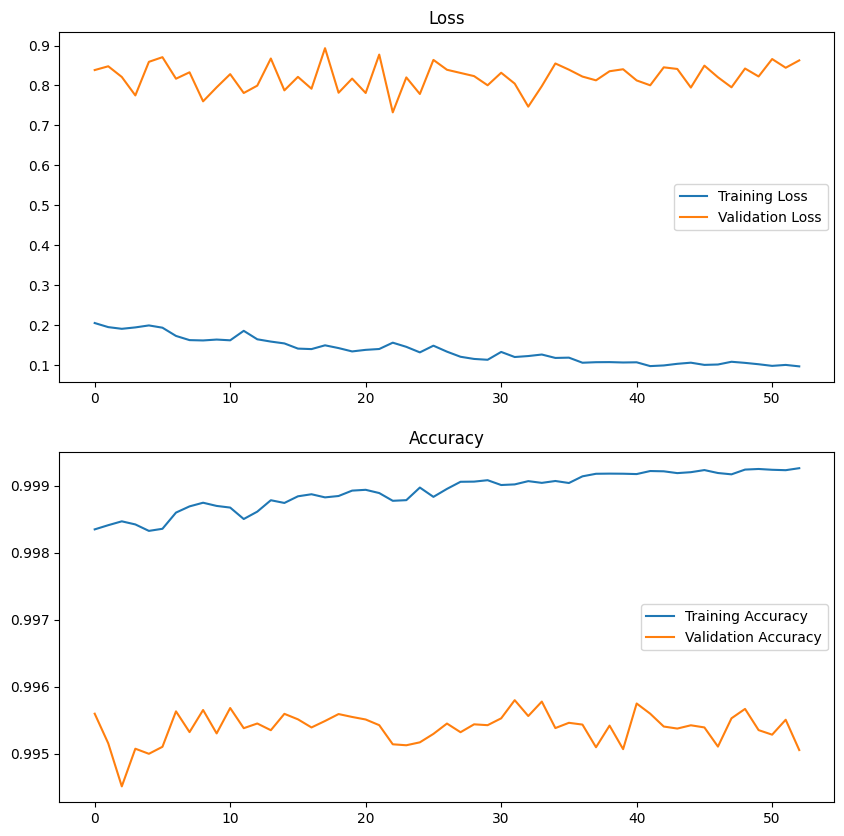

Validation Metrics: {'TPR': 0.45996737480163574, 'Accuracy': 0.9951419830322266, 'Dice': 0.3199515286833048, 'Loss': 0.7327085435390472}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.9598075747489929, 'Accuracy': 0.9983798861503601, 'Dice': 0.7956367272597092, 'Loss': 0.17672812938690186}


------------------------------------------------------------------------------------------------------------------
Model 2 training complete.


------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Training Model 3 with FocalLoss


Epoch 1/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.1173, Train Accuracy: 0.8452, Val Loss: 0.0986, Val Accuracy: 0.9927
fist save with Validation loss --> 0.098642).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.0342, Train Accuracy: 0.9759, Val Loss: 0.0383, Val Accuracy: 0.9963
Validation loss decreased (0.098642 --> 0.038255).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.0206, Train Accuracy: 0.9892, Val Loss: 0.0431, Val Accuracy: 0.9367
EarlyStopping counter: 1 out of 30


Epoch 4/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.0154, Train Accuracy: 0.9912, Val Loss: 0.0212, Val Accuracy: 0.9935
Validation loss decreased (0.038255 --> 0.021220).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.0128, Train Accuracy: 0.9918, Val Loss: 0.0131, Val Accuracy: 0.9955
Validation loss decreased (0.021220 --> 0.013108).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.0110, Train Accuracy: 0.9923, Val Loss: 0.0096, Val Accuracy: 0.9962
EarlyStopping counter: 1 out of 30


Epoch 7/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.0098, Train Accuracy: 0.9929, Val Loss: 0.0087, Val Accuracy: 0.9962
EarlyStopping counter: 2 out of 30


Epoch 8/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.0090, Train Accuracy: 0.9934, Val Loss: 0.0077, Val Accuracy: 0.9962
Validation loss decreased (0.013108 --> 0.007712).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.0081, Train Accuracy: 0.9941, Val Loss: 0.0071, Val Accuracy: 0.9962
EarlyStopping counter: 1 out of 30


Epoch 10/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.0076, Train Accuracy: 0.9942, Val Loss: 0.0069, Val Accuracy: 0.9961
EarlyStopping counter: 2 out of 30


Epoch 11/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.0070, Train Accuracy: 0.9948, Val Loss: 0.0064, Val Accuracy: 0.9963
EarlyStopping counter: 3 out of 30


Epoch 12/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.0066, Train Accuracy: 0.9949, Val Loss: 0.0063, Val Accuracy: 0.9962
EarlyStopping counter: 4 out of 30


Epoch 13/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.0063, Train Accuracy: 0.9950, Val Loss: 0.0062, Val Accuracy: 0.9961
EarlyStopping counter: 5 out of 30


Epoch 14/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.0058, Train Accuracy: 0.9954, Val Loss: 0.0058, Val Accuracy: 0.9961
EarlyStopping counter: 6 out of 30


Epoch 15/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.0055, Train Accuracy: 0.9955, Val Loss: 0.0057, Val Accuracy: 0.9962
EarlyStopping counter: 7 out of 30


Epoch 16/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.0054, Train Accuracy: 0.9955, Val Loss: 0.0059, Val Accuracy: 0.9962
EarlyStopping counter: 8 out of 30


Epoch 17/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.0051, Train Accuracy: 0.9957, Val Loss: 0.0054, Val Accuracy: 0.9964
EarlyStopping counter: 9 out of 30


Epoch 18/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.0049, Train Accuracy: 0.9957, Val Loss: 0.0050, Val Accuracy: 0.9965
EarlyStopping counter: 10 out of 30


Epoch 19/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.0047, Train Accuracy: 0.9959, Val Loss: 0.0054, Val Accuracy: 0.9960
EarlyStopping counter: 11 out of 30


Epoch 20/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.0044, Train Accuracy: 0.9959, Val Loss: 0.0053, Val Accuracy: 0.9962
EarlyStopping counter: 12 out of 30


Epoch 21/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.0042, Train Accuracy: 0.9962, Val Loss: 0.0050, Val Accuracy: 0.9963
EarlyStopping counter: 13 out of 30


Epoch 22/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.0042, Train Accuracy: 0.9961, Val Loss: 0.0047, Val Accuracy: 0.9964
EarlyStopping counter: 14 out of 30


Epoch 23/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.0040, Train Accuracy: 0.9963, Val Loss: 0.0049, Val Accuracy: 0.9962
EarlyStopping counter: 15 out of 30


Epoch 24/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.0038, Train Accuracy: 0.9963, Val Loss: 0.0048, Val Accuracy: 0.9963
EarlyStopping counter: 16 out of 30


Epoch 25/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.0038, Train Accuracy: 0.9962, Val Loss: 0.0047, Val Accuracy: 0.9963
EarlyStopping counter: 17 out of 30


Epoch 26/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.0036, Train Accuracy: 0.9965, Val Loss: 0.0050, Val Accuracy: 0.9961
EarlyStopping counter: 18 out of 30


Epoch 27/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.0035, Train Accuracy: 0.9964, Val Loss: 0.0043, Val Accuracy: 0.9965
EarlyStopping counter: 19 out of 30


Epoch 28/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.0034, Train Accuracy: 0.9966, Val Loss: 0.0047, Val Accuracy: 0.9959
EarlyStopping counter: 20 out of 30


Epoch 29/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.0034, Train Accuracy: 0.9965, Val Loss: 0.0047, Val Accuracy: 0.9961
EarlyStopping counter: 21 out of 30


Epoch 30/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.0032, Train Accuracy: 0.9967, Val Loss: 0.0045, Val Accuracy: 0.9962
EarlyStopping counter: 22 out of 30


Epoch 31/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.0031, Train Accuracy: 0.9968, Val Loss: 0.0045, Val Accuracy: 0.9961
EarlyStopping counter: 23 out of 30


Epoch 32/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.0031, Train Accuracy: 0.9968, Val Loss: 0.0049, Val Accuracy: 0.9961
EarlyStopping counter: 24 out of 30


Epoch 33/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.0031, Train Accuracy: 0.9967, Val Loss: 0.0042, Val Accuracy: 0.9963
EarlyStopping counter: 25 out of 30


Epoch 34/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.0029, Train Accuracy: 0.9970, Val Loss: 0.0044, Val Accuracy: 0.9960
EarlyStopping counter: 26 out of 30


Epoch 35/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.0028, Train Accuracy: 0.9970, Val Loss: 0.0042, Val Accuracy: 0.9961
EarlyStopping counter: 27 out of 30


Epoch 36/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.0027, Train Accuracy: 0.9971, Val Loss: 0.0044, Val Accuracy: 0.9964
EarlyStopping counter: 28 out of 30


Epoch 37/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.0028, Train Accuracy: 0.9969, Val Loss: 0.0040, Val Accuracy: 0.9965
EarlyStopping counter: 29 out of 30


Epoch 38/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.0028, Train Accuracy: 0.9971, Val Loss: 0.0047, Val Accuracy: 0.9961
EarlyStopping counter: 30 out of 30
Early stopping


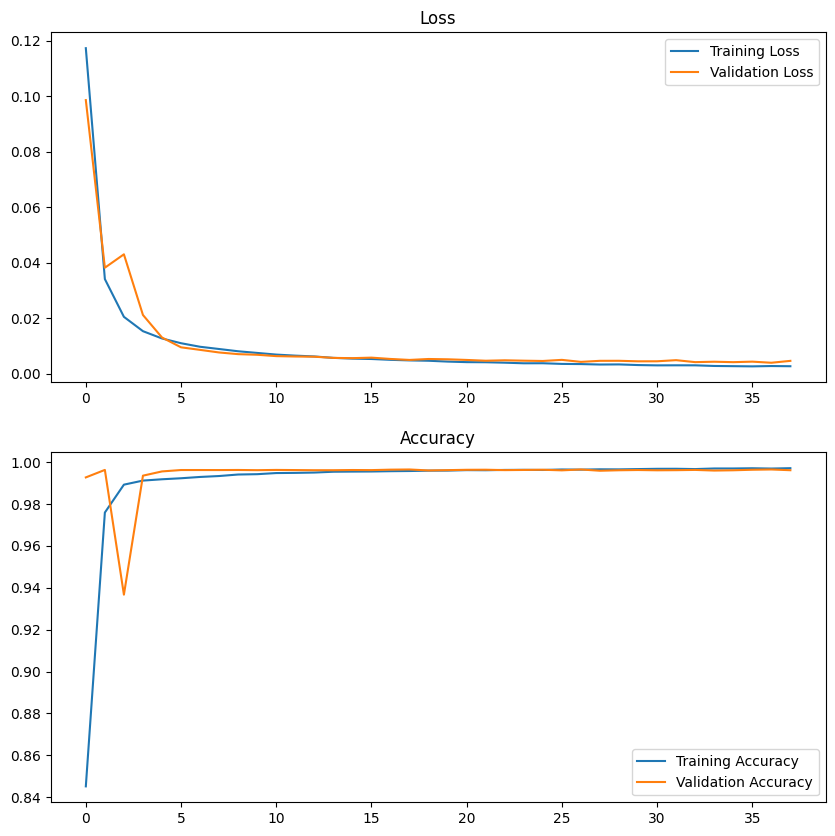

Validation Metrics: {'TPR': 0.01041986420750618, 'Accuracy': 0.9961960315704346, 'Dice': 0.015503864851780236, 'Loss': 0.00771232636179775}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.339363694190979, 'Accuracy': 0.9941455125808716, 'Dice': 0.1899440838740422, 'Loss': 0.008828403069995917}


------------------------------------------------------------------------------------------------------------------
Model 3 training complete.


------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Training Model 4 with CompositeLoss


Epoch 1/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.8087, Train Accuracy: 0.6305, Val Loss: 0.7969, Val Accuracy: 0.0103
fist save with Validation loss --> 0.796876).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.7431, Train Accuracy: 0.8992, Val Loss: 0.7572, Val Accuracy: 0.9696
Validation loss decreased (0.796876 --> 0.757150).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.7244, Train Accuracy: 0.9492, Val Loss: 0.7610, Val Accuracy: 0.8833
EarlyStopping counter: 1 out of 30


Epoch 4/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.7105, Train Accuracy: 0.9640, Val Loss: 0.7438, Val Accuracy: 0.9558
Validation loss decreased (0.757150 --> 0.743751).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.6953, Train Accuracy: 0.9741, Val Loss: 0.7375, Val Accuracy: 0.9803
Validation loss decreased (0.743751 --> 0.737517).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.6778, Train Accuracy: 0.9809, Val Loss: 0.7338, Val Accuracy: 0.9886
EarlyStopping counter: 1 out of 30


Epoch 7/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.6597, Train Accuracy: 0.9853, Val Loss: 0.7264, Val Accuracy: 0.9847
Validation loss decreased (0.737517 --> 0.726385).  Saving model ...


Epoch 8/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.6369, Train Accuracy: 0.9901, Val Loss: 0.7240, Val Accuracy: 0.9875
EarlyStopping counter: 1 out of 30


Epoch 9/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.6207, Train Accuracy: 0.9882, Val Loss: 0.7157, Val Accuracy: 0.9948
Validation loss decreased (0.726385 --> 0.715745).  Saving model ...


Epoch 10/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.5880, Train Accuracy: 0.9920, Val Loss: 0.7108, Val Accuracy: 0.9943
EarlyStopping counter: 1 out of 30


Epoch 11/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.5566, Train Accuracy: 0.9936, Val Loss: 0.7171, Val Accuracy: 0.9951
EarlyStopping counter: 2 out of 30


Epoch 12/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.5229, Train Accuracy: 0.9943, Val Loss: 0.6859, Val Accuracy: 0.9945
Validation loss decreased (0.715745 --> 0.685894).  Saving model ...


Epoch 13/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.4962, Train Accuracy: 0.9948, Val Loss: 0.6888, Val Accuracy: 0.9966
EarlyStopping counter: 1 out of 30


Epoch 14/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.4458, Train Accuracy: 0.9955, Val Loss: 0.6745, Val Accuracy: 0.9951
Validation loss decreased (0.685894 --> 0.674531).  Saving model ...


Epoch 15/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.4021, Train Accuracy: 0.9960, Val Loss: 0.6543, Val Accuracy: 0.9948
Validation loss decreased (0.674531 --> 0.654271).  Saving model ...


Epoch 16/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.3858, Train Accuracy: 0.9959, Val Loss: 0.6959, Val Accuracy: 0.9951
EarlyStopping counter: 1 out of 30


Epoch 17/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.3702, Train Accuracy: 0.9957, Val Loss: 0.6377, Val Accuracy: 0.9964
Validation loss decreased (0.654271 --> 0.637685).  Saving model ...


Epoch 18/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.3246, Train Accuracy: 0.9963, Val Loss: 0.6335, Val Accuracy: 0.9954
EarlyStopping counter: 1 out of 30


Epoch 19/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.3053, Train Accuracy: 0.9968, Val Loss: 0.6207, Val Accuracy: 0.9950
Validation loss decreased (0.637685 --> 0.620699).  Saving model ...


Epoch 20/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.2769, Train Accuracy: 0.9970, Val Loss: 0.6182, Val Accuracy: 0.9954
EarlyStopping counter: 1 out of 30


Epoch 21/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.2498, Train Accuracy: 0.9972, Val Loss: 0.6008, Val Accuracy: 0.9945
Validation loss decreased (0.620699 --> 0.600789).  Saving model ...


Epoch 22/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.2324, Train Accuracy: 0.9972, Val Loss: 0.6427, Val Accuracy: 0.9952
EarlyStopping counter: 1 out of 30


Epoch 23/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.2122, Train Accuracy: 0.9974, Val Loss: 0.5767, Val Accuracy: 0.9949
Validation loss decreased (0.600789 --> 0.576671).  Saving model ...


Epoch 24/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.2139, Train Accuracy: 0.9975, Val Loss: 0.5711, Val Accuracy: 0.9961
Validation loss decreased (0.576671 --> 0.571084).  Saving model ...


Epoch 25/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.2025, Train Accuracy: 0.9974, Val Loss: 0.6512, Val Accuracy: 0.9957
EarlyStopping counter: 1 out of 30


Epoch 26/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.1996, Train Accuracy: 0.9975, Val Loss: 0.5861, Val Accuracy: 0.9921
EarlyStopping counter: 2 out of 30


Epoch 27/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.1910, Train Accuracy: 0.9975, Val Loss: 0.6354, Val Accuracy: 0.9955
EarlyStopping counter: 3 out of 30


Epoch 28/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.1759, Train Accuracy: 0.9977, Val Loss: 0.5790, Val Accuracy: 0.9965
EarlyStopping counter: 4 out of 30


Epoch 29/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.1605, Train Accuracy: 0.9978, Val Loss: 0.6235, Val Accuracy: 0.9957
EarlyStopping counter: 5 out of 30


Epoch 30/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.1535, Train Accuracy: 0.9978, Val Loss: 0.5362, Val Accuracy: 0.9954
Validation loss decreased (0.571084 --> 0.536216).  Saving model ...


Epoch 31/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.1546, Train Accuracy: 0.9979, Val Loss: 0.6031, Val Accuracy: 0.9944
EarlyStopping counter: 1 out of 30


Epoch 32/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.1470, Train Accuracy: 0.9978, Val Loss: 0.6204, Val Accuracy: 0.9949
EarlyStopping counter: 2 out of 30


Epoch 33/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.1510, Train Accuracy: 0.9979, Val Loss: 0.6139, Val Accuracy: 0.9959
EarlyStopping counter: 3 out of 30


Epoch 34/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.1478, Train Accuracy: 0.9978, Val Loss: 0.5561, Val Accuracy: 0.9950
EarlyStopping counter: 4 out of 30


Epoch 35/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.1329, Train Accuracy: 0.9980, Val Loss: 0.5782, Val Accuracy: 0.9959
EarlyStopping counter: 5 out of 30


Epoch 36/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.1311, Train Accuracy: 0.9980, Val Loss: 0.6326, Val Accuracy: 0.9957
EarlyStopping counter: 6 out of 30


Epoch 37/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.1308, Train Accuracy: 0.9981, Val Loss: 0.5356, Val Accuracy: 0.9956
EarlyStopping counter: 7 out of 30


Epoch 38/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.1259, Train Accuracy: 0.9982, Val Loss: 0.5603, Val Accuracy: 0.9956
EarlyStopping counter: 8 out of 30


Epoch 39/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.1147, Train Accuracy: 0.9983, Val Loss: 0.5424, Val Accuracy: 0.9956
EarlyStopping counter: 9 out of 30


Epoch 40/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.1178, Train Accuracy: 0.9982, Val Loss: 0.6024, Val Accuracy: 0.9960
EarlyStopping counter: 10 out of 30


Epoch 41/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.1262, Train Accuracy: 0.9980, Val Loss: 0.5680, Val Accuracy: 0.9948
EarlyStopping counter: 11 out of 30


Epoch 42/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.1194, Train Accuracy: 0.9981, Val Loss: 0.5777, Val Accuracy: 0.9960
EarlyStopping counter: 12 out of 30


Epoch 43/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.1062, Train Accuracy: 0.9983, Val Loss: 0.5310, Val Accuracy: 0.9955
Validation loss decreased (0.536216 --> 0.531034).  Saving model ...


Epoch 44/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.1085, Train Accuracy: 0.9983, Val Loss: 0.5839, Val Accuracy: 0.9958
EarlyStopping counter: 1 out of 30


Epoch 45/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.1133, Train Accuracy: 0.9982, Val Loss: 0.5511, Val Accuracy: 0.9951
EarlyStopping counter: 2 out of 30


Epoch 46/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.1143, Train Accuracy: 0.9983, Val Loss: 0.6146, Val Accuracy: 0.9957
EarlyStopping counter: 3 out of 30


Epoch 47/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.1089, Train Accuracy: 0.9982, Val Loss: 0.5211, Val Accuracy: 0.9951
Validation loss decreased (0.531034 --> 0.521081).  Saving model ...


Epoch 48/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.1045, Train Accuracy: 0.9983, Val Loss: 0.5292, Val Accuracy: 0.9950
EarlyStopping counter: 1 out of 30


Epoch 49/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.0990, Train Accuracy: 0.9985, Val Loss: 0.5441, Val Accuracy: 0.9959
EarlyStopping counter: 2 out of 30


Epoch 50/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.0940, Train Accuracy: 0.9985, Val Loss: 0.5360, Val Accuracy: 0.9953
EarlyStopping counter: 3 out of 30


Epoch 51/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.0940, Train Accuracy: 0.9985, Val Loss: 0.5625, Val Accuracy: 0.9953
EarlyStopping counter: 4 out of 30


Epoch 52/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.0896, Train Accuracy: 0.9986, Val Loss: 0.5269, Val Accuracy: 0.9956
EarlyStopping counter: 5 out of 30


Epoch 53/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.0865, Train Accuracy: 0.9986, Val Loss: 0.5293, Val Accuracy: 0.9955
EarlyStopping counter: 6 out of 30


Epoch 54/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.0852, Train Accuracy: 0.9987, Val Loss: 0.5211, Val Accuracy: 0.9959
EarlyStopping counter: 7 out of 30


Epoch 55/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.0825, Train Accuracy: 0.9987, Val Loss: 0.5447, Val Accuracy: 0.9954
EarlyStopping counter: 8 out of 30


Epoch 56/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.0814, Train Accuracy: 0.9987, Val Loss: 0.5387, Val Accuracy: 0.9943
EarlyStopping counter: 9 out of 30


Epoch 57/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.0814, Train Accuracy: 0.9987, Val Loss: 0.5634, Val Accuracy: 0.9958
EarlyStopping counter: 10 out of 30


Epoch 58/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.0792, Train Accuracy: 0.9988, Val Loss: 0.5257, Val Accuracy: 0.9955
EarlyStopping counter: 11 out of 30


Epoch 59/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/1000], Train Loss: 0.0767, Train Accuracy: 0.9987, Val Loss: 0.5563, Val Accuracy: 0.9953
EarlyStopping counter: 12 out of 30


Epoch 60/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60/1000], Train Loss: 0.0782, Train Accuracy: 0.9987, Val Loss: 0.4965, Val Accuracy: 0.9956
Validation loss decreased (0.521081 --> 0.496544).  Saving model ...


Epoch 61/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61/1000], Train Loss: 0.0783, Train Accuracy: 0.9987, Val Loss: 0.5336, Val Accuracy: 0.9951
EarlyStopping counter: 1 out of 30


Epoch 62/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62/1000], Train Loss: 0.0692, Train Accuracy: 0.9989, Val Loss: 0.5427, Val Accuracy: 0.9954
EarlyStopping counter: 2 out of 30


Epoch 63/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63/1000], Train Loss: 0.0691, Train Accuracy: 0.9989, Val Loss: 0.5295, Val Accuracy: 0.9954
EarlyStopping counter: 3 out of 30


Epoch 64/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64/1000], Train Loss: 0.0718, Train Accuracy: 0.9989, Val Loss: 0.5197, Val Accuracy: 0.9952
EarlyStopping counter: 4 out of 30


Epoch 65/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65/1000], Train Loss: 0.0729, Train Accuracy: 0.9989, Val Loss: 0.5691, Val Accuracy: 0.9951
EarlyStopping counter: 5 out of 30


Epoch 66/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66/1000], Train Loss: 0.0701, Train Accuracy: 0.9989, Val Loss: 0.6064, Val Accuracy: 0.9957
EarlyStopping counter: 6 out of 30


Epoch 67/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67/1000], Train Loss: 0.0714, Train Accuracy: 0.9988, Val Loss: 0.5087, Val Accuracy: 0.9949
EarlyStopping counter: 7 out of 30


Epoch 68/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68/1000], Train Loss: 0.0656, Train Accuracy: 0.9989, Val Loss: 0.5268, Val Accuracy: 0.9953
EarlyStopping counter: 8 out of 30


Epoch 69/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69/1000], Train Loss: 0.0673, Train Accuracy: 0.9990, Val Loss: 0.5377, Val Accuracy: 0.9955
EarlyStopping counter: 9 out of 30


Epoch 70/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70/1000], Train Loss: 0.0653, Train Accuracy: 0.9989, Val Loss: 0.5261, Val Accuracy: 0.9958
EarlyStopping counter: 10 out of 30


Epoch 71/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71/1000], Train Loss: 0.0644, Train Accuracy: 0.9990, Val Loss: 0.4820, Val Accuracy: 0.9952
Validation loss decreased (0.496544 --> 0.482021).  Saving model ...


Epoch 72/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72/1000], Train Loss: 0.0655, Train Accuracy: 0.9990, Val Loss: 0.5233, Val Accuracy: 0.9953
EarlyStopping counter: 1 out of 30


Epoch 73/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73/1000], Train Loss: 0.0627, Train Accuracy: 0.9989, Val Loss: 0.5514, Val Accuracy: 0.9951
EarlyStopping counter: 2 out of 30


Epoch 74/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74/1000], Train Loss: 0.0636, Train Accuracy: 0.9990, Val Loss: 0.5507, Val Accuracy: 0.9952
EarlyStopping counter: 3 out of 30


Epoch 75/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75/1000], Train Loss: 0.0605, Train Accuracy: 0.9990, Val Loss: 0.5529, Val Accuracy: 0.9953
EarlyStopping counter: 4 out of 30


Epoch 76/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76/1000], Train Loss: 0.0575, Train Accuracy: 0.9991, Val Loss: 0.4995, Val Accuracy: 0.9956
EarlyStopping counter: 5 out of 30


Epoch 77/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77/1000], Train Loss: 0.0586, Train Accuracy: 0.9991, Val Loss: 0.5365, Val Accuracy: 0.9951
EarlyStopping counter: 6 out of 30


Epoch 78/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78/1000], Train Loss: 0.0591, Train Accuracy: 0.9990, Val Loss: 0.5248, Val Accuracy: 0.9950
EarlyStopping counter: 7 out of 30


Epoch 79/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79/1000], Train Loss: 0.0620, Train Accuracy: 0.9990, Val Loss: 0.4844, Val Accuracy: 0.9951
EarlyStopping counter: 8 out of 30


Epoch 80/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80/1000], Train Loss: 0.0577, Train Accuracy: 0.9990, Val Loss: 0.5456, Val Accuracy: 0.9950
EarlyStopping counter: 9 out of 30


Epoch 81/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81/1000], Train Loss: 0.0593, Train Accuracy: 0.9991, Val Loss: 0.5698, Val Accuracy: 0.9956
EarlyStopping counter: 10 out of 30


Epoch 82/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [82/1000], Train Loss: 0.0561, Train Accuracy: 0.9991, Val Loss: 0.4889, Val Accuracy: 0.9951
EarlyStopping counter: 11 out of 30


Epoch 83/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [83/1000], Train Loss: 0.0609, Train Accuracy: 0.9990, Val Loss: 0.5260, Val Accuracy: 0.9953
EarlyStopping counter: 12 out of 30


Epoch 84/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [84/1000], Train Loss: 0.0545, Train Accuracy: 0.9991, Val Loss: 0.5256, Val Accuracy: 0.9951
EarlyStopping counter: 13 out of 30


Epoch 85/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [85/1000], Train Loss: 0.0537, Train Accuracy: 0.9991, Val Loss: 0.5736, Val Accuracy: 0.9951
EarlyStopping counter: 14 out of 30


Epoch 86/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [86/1000], Train Loss: 0.0555, Train Accuracy: 0.9991, Val Loss: 0.5137, Val Accuracy: 0.9960
EarlyStopping counter: 15 out of 30


Epoch 87/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [87/1000], Train Loss: 0.0504, Train Accuracy: 0.9992, Val Loss: 0.5115, Val Accuracy: 0.9953
EarlyStopping counter: 16 out of 30


Epoch 88/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [88/1000], Train Loss: 0.0506, Train Accuracy: 0.9992, Val Loss: 0.5808, Val Accuracy: 0.9960
EarlyStopping counter: 17 out of 30


Epoch 89/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [89/1000], Train Loss: 0.0498, Train Accuracy: 0.9992, Val Loss: 0.4973, Val Accuracy: 0.9956
EarlyStopping counter: 18 out of 30


Epoch 90/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [90/1000], Train Loss: 0.0532, Train Accuracy: 0.9992, Val Loss: 0.5337, Val Accuracy: 0.9956
EarlyStopping counter: 19 out of 30


Epoch 91/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [91/1000], Train Loss: 0.0470, Train Accuracy: 0.9993, Val Loss: 0.5146, Val Accuracy: 0.9953
EarlyStopping counter: 20 out of 30


Epoch 92/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [92/1000], Train Loss: 0.0468, Train Accuracy: 0.9992, Val Loss: 0.5431, Val Accuracy: 0.9953
EarlyStopping counter: 21 out of 30


Epoch 93/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [93/1000], Train Loss: 0.0496, Train Accuracy: 0.9992, Val Loss: 0.4963, Val Accuracy: 0.9957
EarlyStopping counter: 22 out of 30


Epoch 94/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [94/1000], Train Loss: 0.0509, Train Accuracy: 0.9991, Val Loss: 0.5636, Val Accuracy: 0.9953
EarlyStopping counter: 23 out of 30


Epoch 95/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [95/1000], Train Loss: 0.0523, Train Accuracy: 0.9992, Val Loss: 0.5062, Val Accuracy: 0.9956
EarlyStopping counter: 24 out of 30


Epoch 96/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [96/1000], Train Loss: 0.0512, Train Accuracy: 0.9991, Val Loss: 0.5033, Val Accuracy: 0.9957
EarlyStopping counter: 25 out of 30


Epoch 97/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [97/1000], Train Loss: 0.0524, Train Accuracy: 0.9992, Val Loss: 0.5113, Val Accuracy: 0.9959
EarlyStopping counter: 26 out of 30


Epoch 98/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [98/1000], Train Loss: 0.0495, Train Accuracy: 0.9992, Val Loss: 0.5365, Val Accuracy: 0.9955
EarlyStopping counter: 27 out of 30


Epoch 99/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [99/1000], Train Loss: 0.0453, Train Accuracy: 0.9992, Val Loss: 0.5232, Val Accuracy: 0.9953
EarlyStopping counter: 28 out of 30


Epoch 100/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [100/1000], Train Loss: 0.0464, Train Accuracy: 0.9993, Val Loss: 0.5210, Val Accuracy: 0.9954
EarlyStopping counter: 29 out of 30


Epoch 101/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [101/1000], Train Loss: 0.0451, Train Accuracy: 0.9993, Val Loss: 0.5277, Val Accuracy: 0.9957
EarlyStopping counter: 30 out of 30
Early stopping


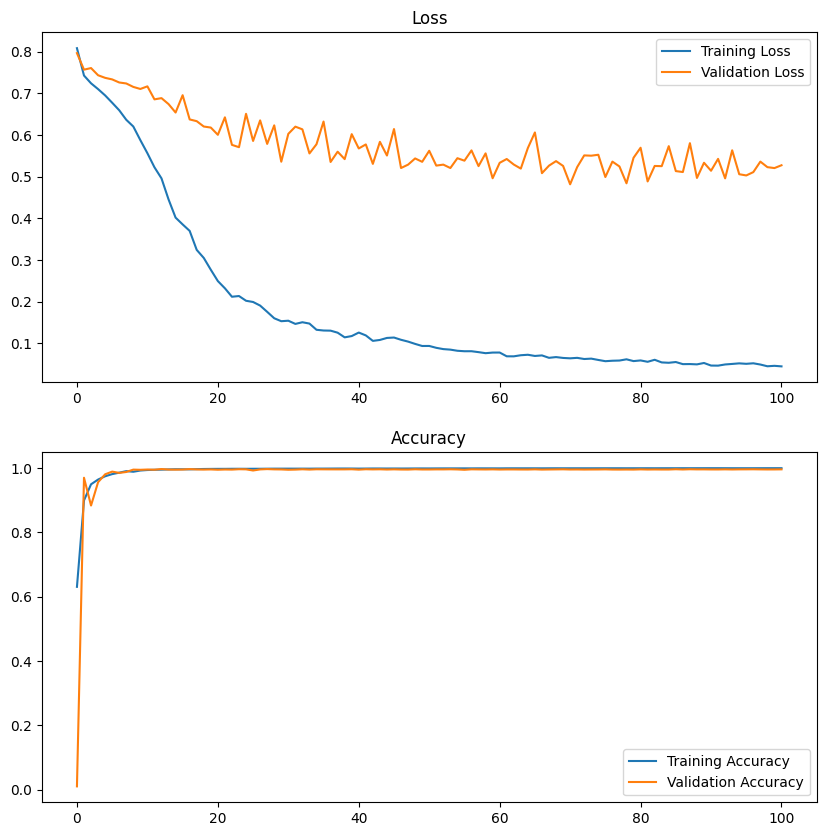

Validation Metrics: {'TPR': 0.3909761905670166, 'Accuracy': 0.9952239990234375, 'Dice': 0.2840703967958689, 'Loss': 0.4820213243365288}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.9541983008384705, 'Accuracy': 0.998843252658844, 'Dice': 0.817258738554441, 'Loss': 0.0678609199821949}


------------------------------------------------------------------------------------------------------------------
Model 4 training complete.


------------------------------------------------------------------------------------------------------------------


In [25]:
# Train each model with a different loss function
for i, (model, loss_fn, optimizer) in enumerate(zip(models, loss_functions, optimizers)):
    optimizer.zero_grad()
    print("------------------------------------------------------------------------------------------------------------------")
    print(f"Training Model {i+1} with {loss_fn.__class__.__name__}")
    model = train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs, patience, l1_lambda)
    final_trained_model.append(model)
    print(f"Model {i+1} training complete.\n\n")
    print("------------------------------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------------------------


Model 1 Metrics:


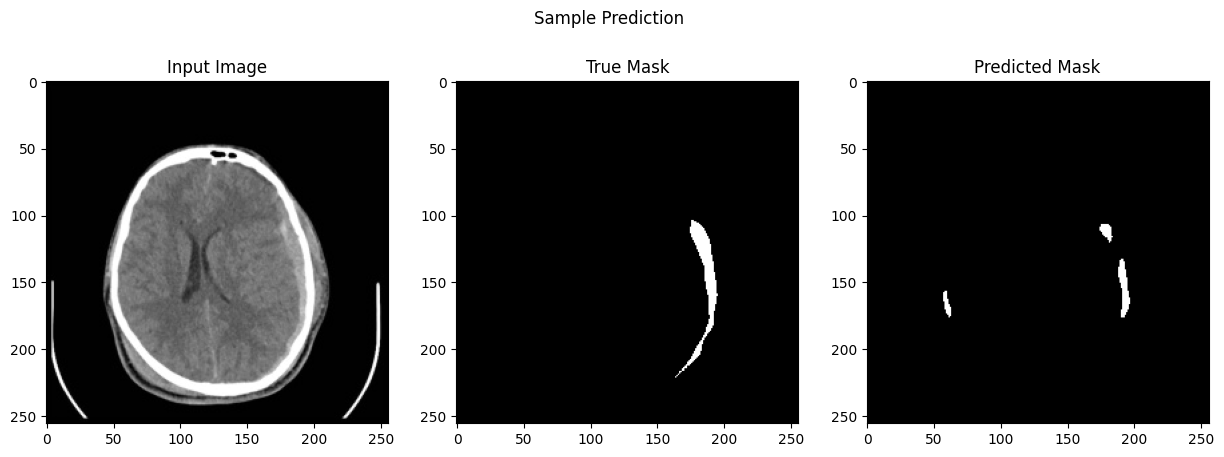

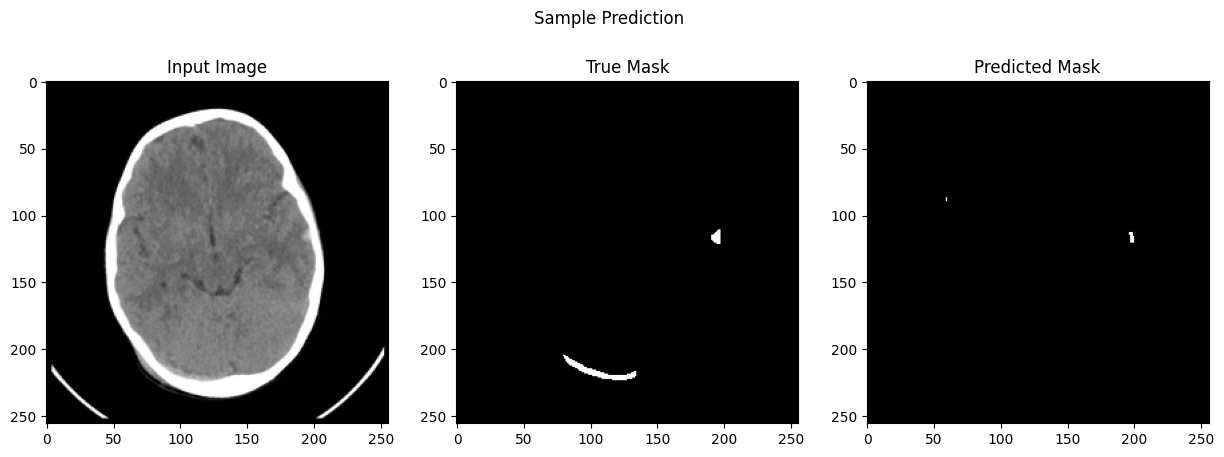

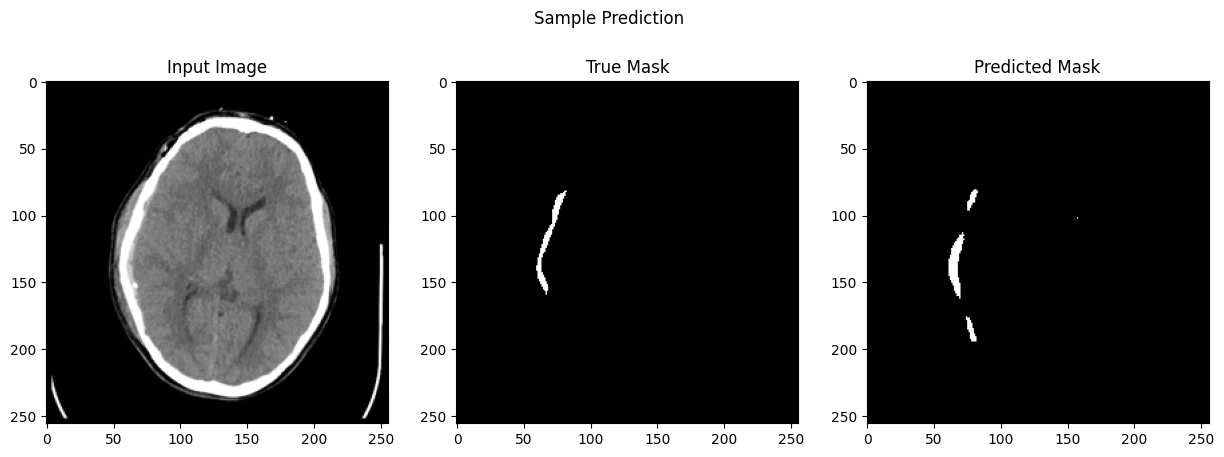

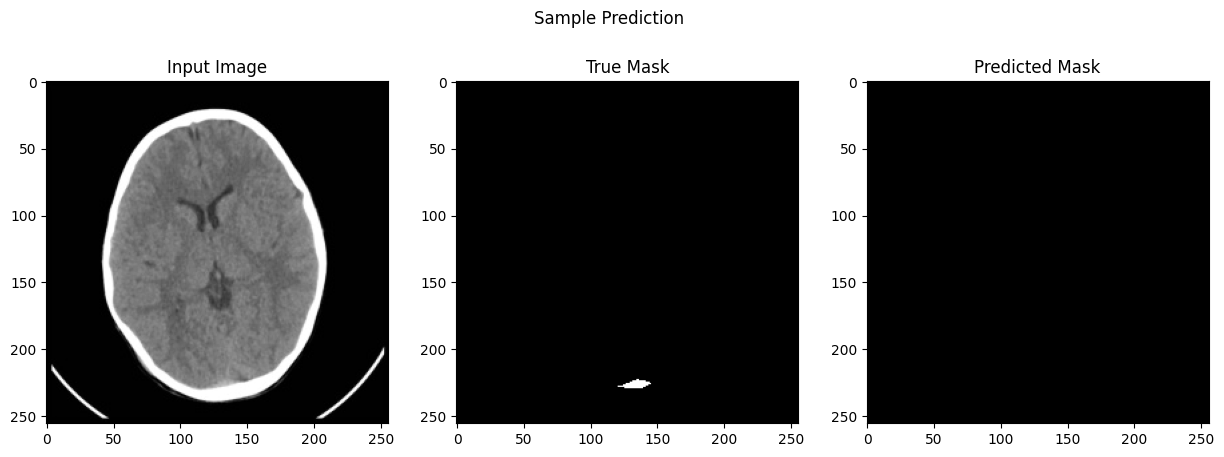

{'TPR': 0.36228659749031067, 'Accuracy': 0.9910120964050293, 'Dice': 0.3504261448979378, 'Loss': 0.537105068564415}
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------


Model 2 Metrics:


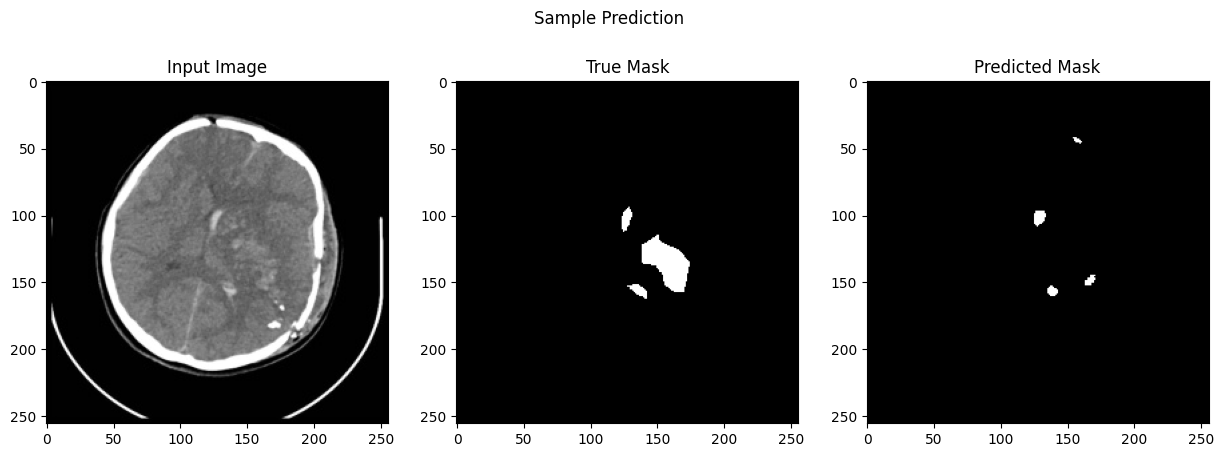

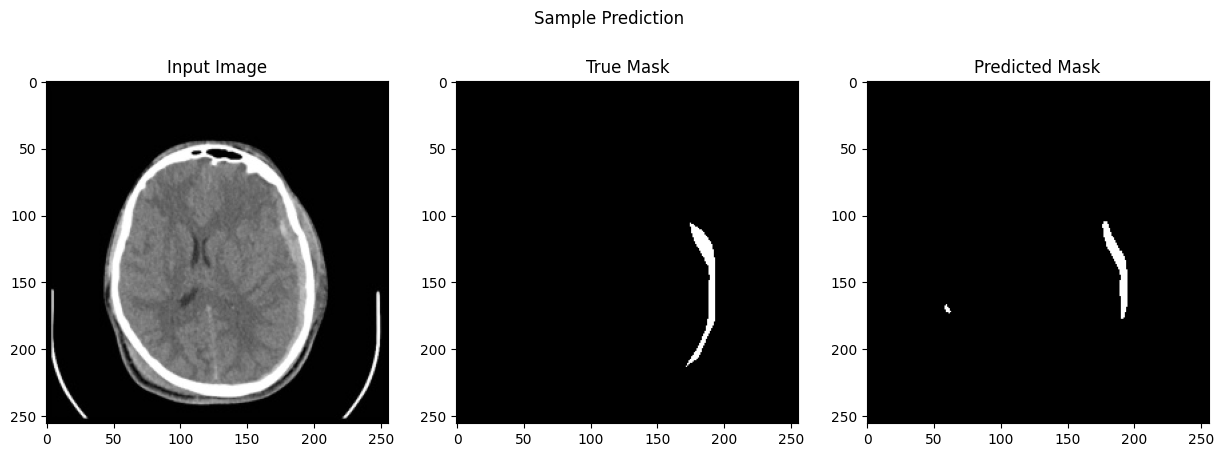

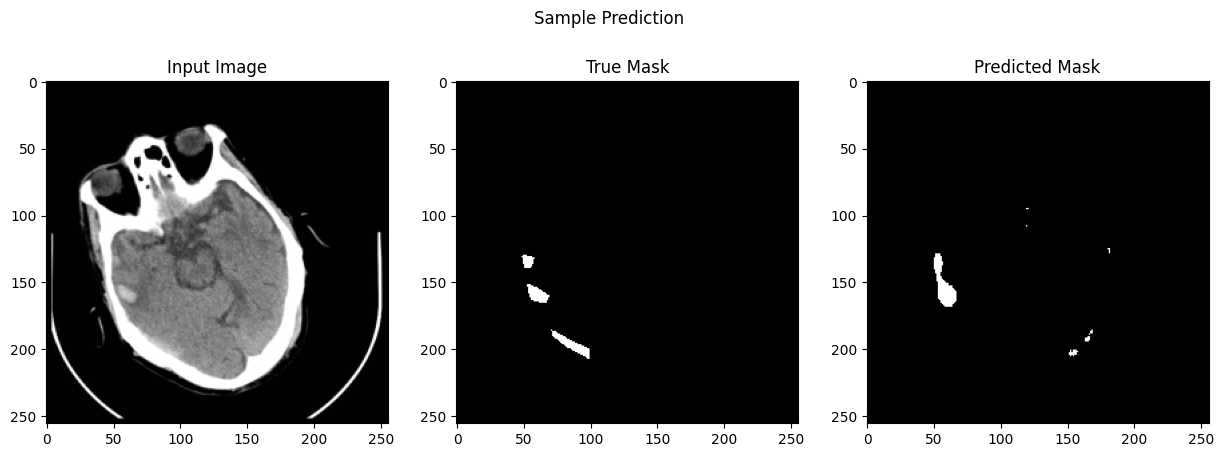

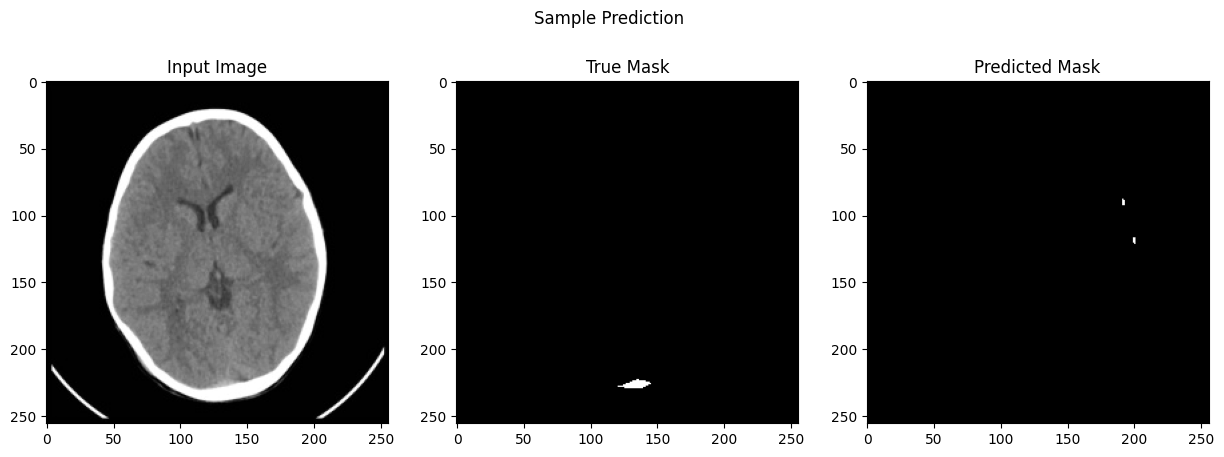

{'TPR': 0.3913052976131439, 'Accuracy': 0.9910109043121338, 'Dice': 0.3696761839091778, 'Loss': 0.6755571663379669}
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------


Model 3 Metrics:


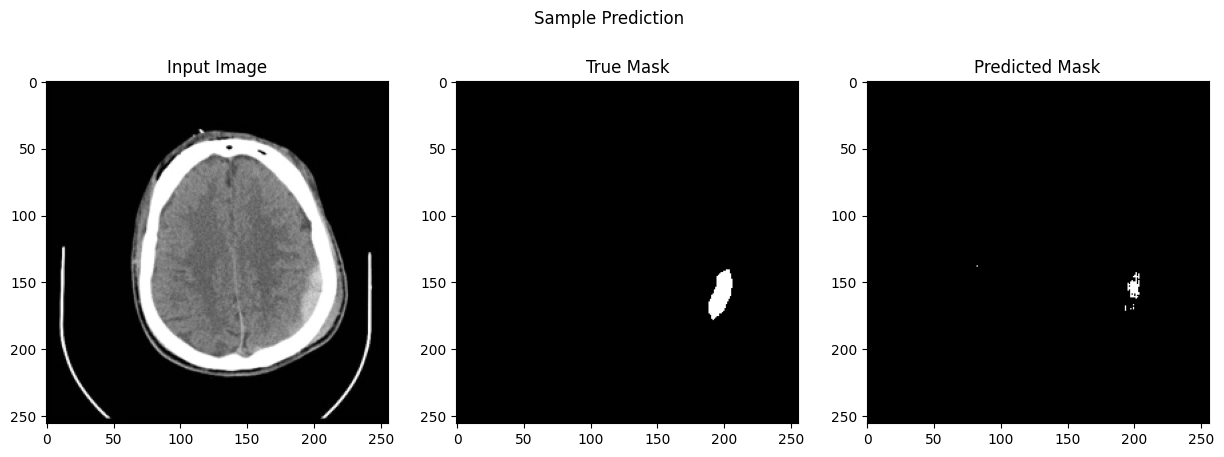

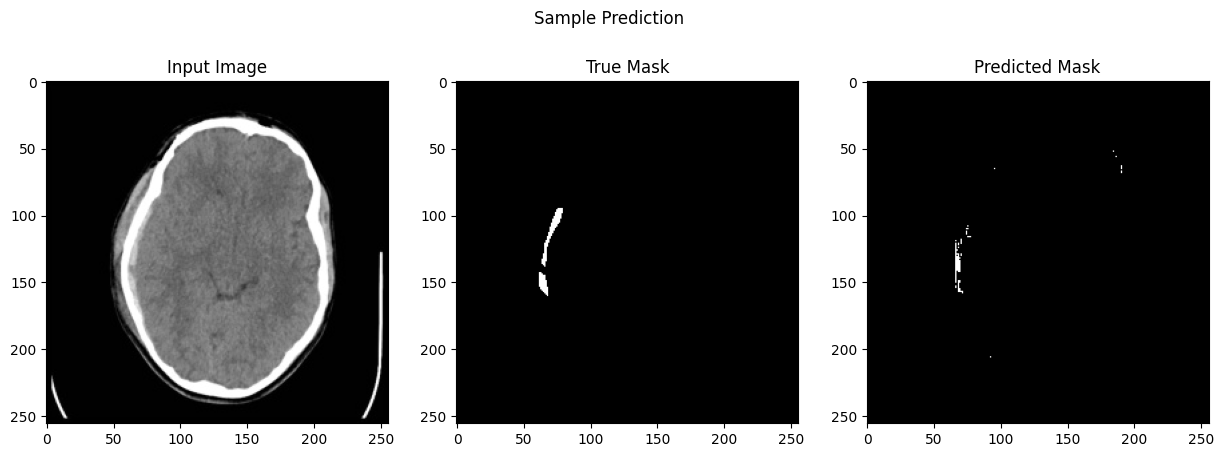

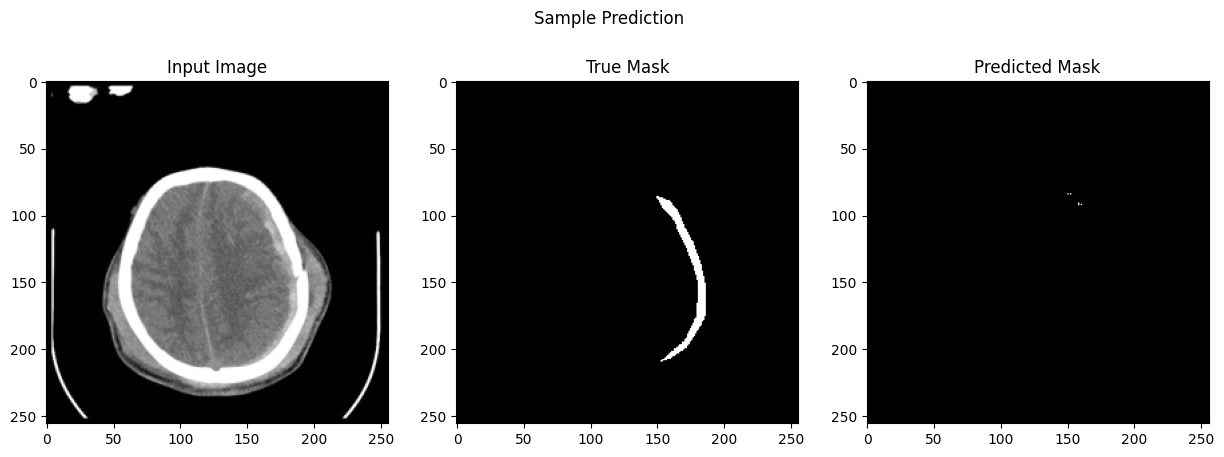

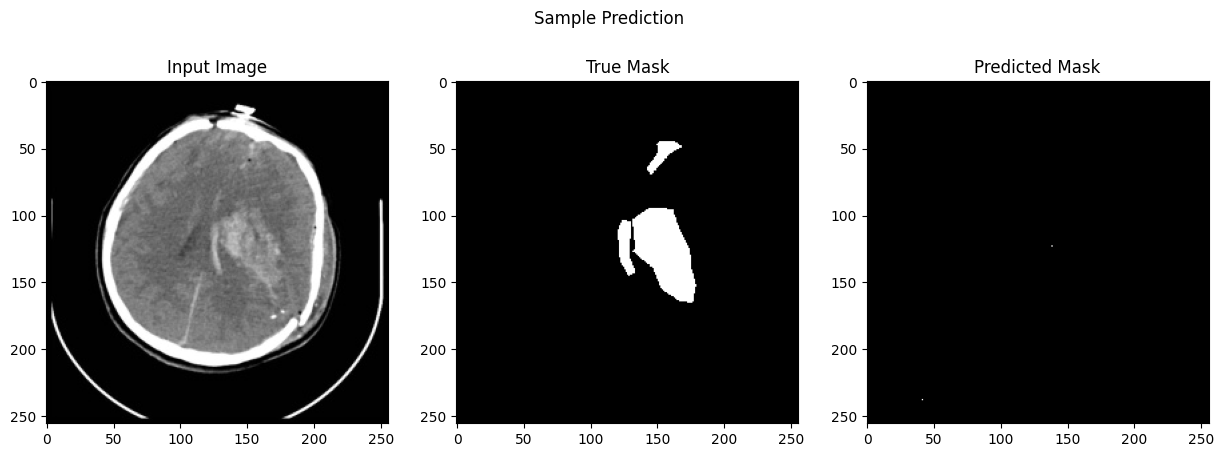

{'TPR': 0.012714195065200329, 'Accuracy': 0.98830246925354, 'Dice': 0.03376208560075611, 'Loss': 0.014929564902558923}
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------


Model 4 Metrics:


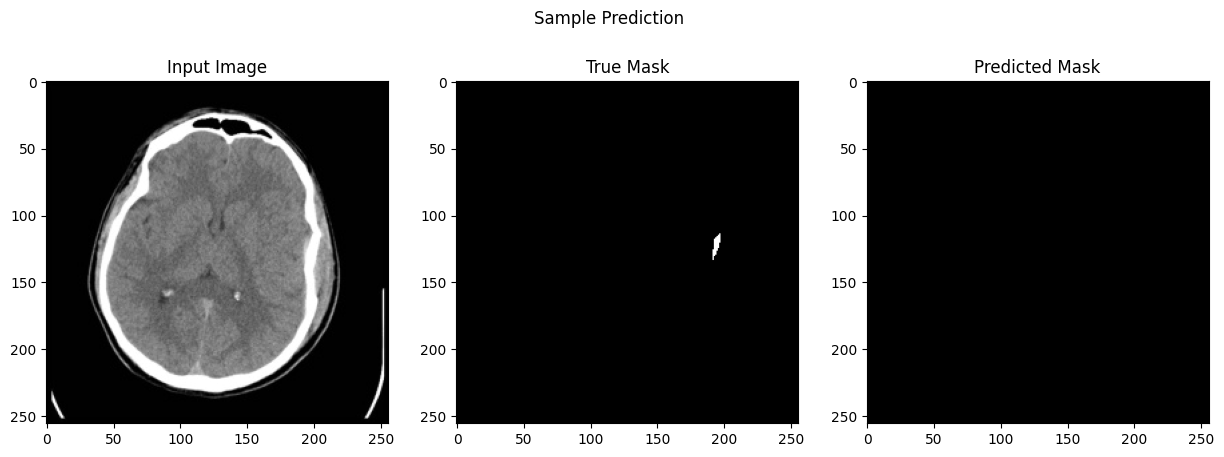

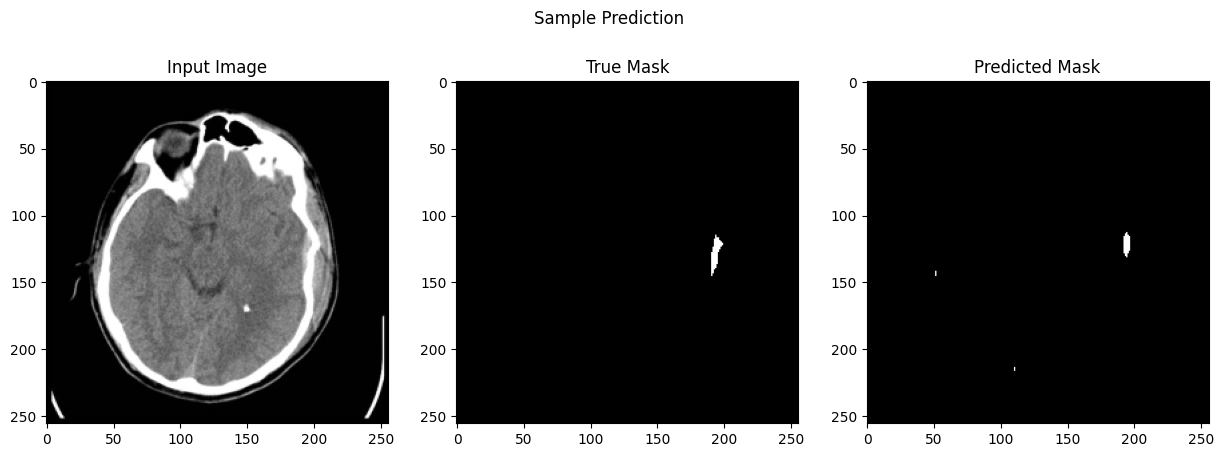

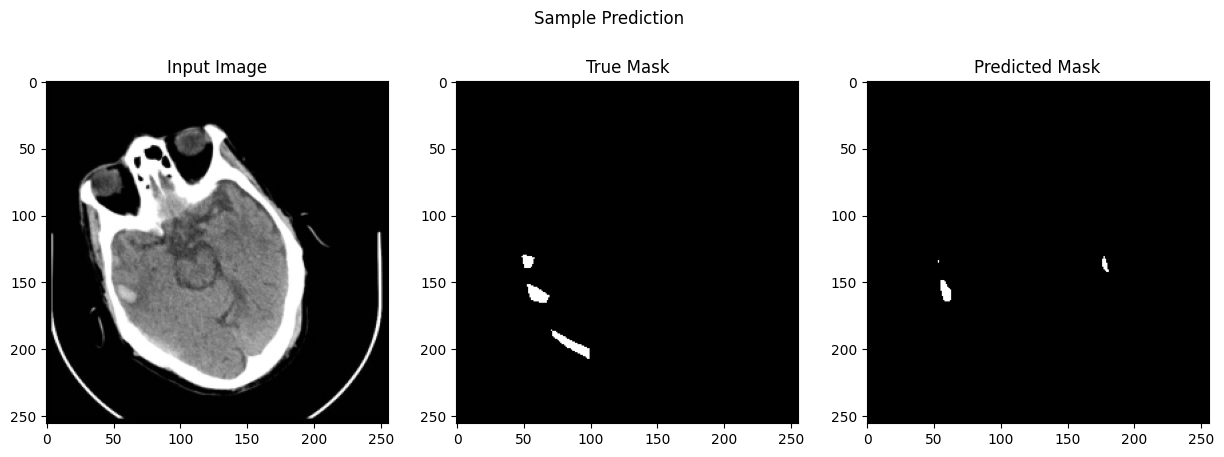

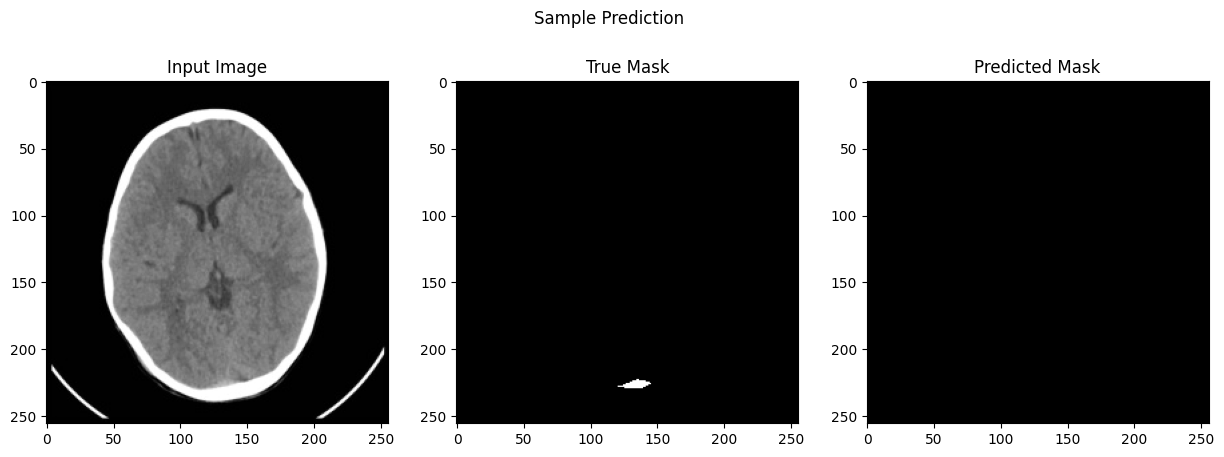

{'TPR': 0.31853145360946655, 'Accuracy': 0.9903967380523682, 'Dice': 0.33733727037906647, 'Loss': 0.4514268562197685}
---------------------------------------------------------------------------------------------------------------




In [26]:
# Calculate metrics on the test set for each model
for i,model in enumerate(final_trained_model):
    print("---------------------------------------------------------------------------------------------------------------\n\n")
    print(f"Model {i+1} Metrics:")
    test_metrics = calculate_metrics(model, test_loader, loss_functions[i], True, device)
    print(test_metrics)
    print("---------------------------------------------------------------------------------------------------------------\n\n")

## Q5

### a (effect of Augumentation)

In [27]:
# Load the dataset
dataset1 = "/kaggle/input/aimiassigmnet2/Dataset1"

train_files_dir = os.path.join(dataset1, "TrainFiles")
train_mask_dir = os.path.join(dataset1, "TrainMask")
val_files_dir = os.path.join(dataset1, "ValFiles")
val_mask_dir = os.path.join(dataset1, "ValMask")
test_files_dir = os.path.join(dataset1, "TestFiles")
test_mask_dir = os.path.join(dataset1, "TestMask")

train_dataset_tensor, train_mask_tensor = file_to_tensor(train_files_dir, train_mask_dir, augment=True, num_aug= 3) # augment the training dataset
val_dataset_tensor, val_mask_tensor = file_to_tensor(val_files_dir, val_mask_dir, augment=False)
test_dataset_tensor, test_mask_tensor = file_to_tensor(test_files_dir, test_mask_dir, augment=False)

print(train_dataset_tensor.shape, train_mask_tensor.shape)
print(val_dataset_tensor.shape, val_mask_tensor.shape)
print(test_dataset_tensor.shape, test_mask_tensor.shape)

torch.Size([808, 1, 256, 256]) torch.Size([808, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])


In [28]:
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_dataset_tensor, train_mask_tensor)
val_dataset = TensorDataset(val_dataset_tensor, val_mask_tensor)
test_dataset = TensorDataset(test_dataset_tensor, test_mask_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [29]:
model = basicCNN()
#model = UNetResNet50Grayscale()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_function = smp.losses.DiceLoss("binary")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 1000
patience = 30

Epoch 1/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.9262, Train Accuracy: 0.8255, Val Loss: 0.9558, Val Accuracy: 0.9223
fist save with Validation loss --> 0.955775).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.8502, Train Accuracy: 0.9547, Val Loss: 0.9290, Val Accuracy: 0.9829
Validation loss decreased (0.955775 --> 0.929030).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.7506, Train Accuracy: 0.9801, Val Loss: 0.8550, Val Accuracy: 0.9924
Validation loss decreased (0.929030 --> 0.855025).  Saving model ...


Epoch 4/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.6317, Train Accuracy: 0.9892, Val Loss: 0.7844, Val Accuracy: 0.9939
Validation loss decreased (0.855025 --> 0.784446).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.5367, Train Accuracy: 0.9920, Val Loss: 0.6887, Val Accuracy: 0.9948
Validation loss decreased (0.784446 --> 0.688736).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.4815, Train Accuracy: 0.9934, Val Loss: 0.7905, Val Accuracy: 0.9954
EarlyStopping counter: 1 out of 30


Epoch 7/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.4316, Train Accuracy: 0.9942, Val Loss: 0.7456, Val Accuracy: 0.9936
EarlyStopping counter: 2 out of 30


Epoch 8/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.3965, Train Accuracy: 0.9945, Val Loss: 0.6687, Val Accuracy: 0.9950
Validation loss decreased (0.688736 --> 0.668744).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.3472, Train Accuracy: 0.9953, Val Loss: 0.6372, Val Accuracy: 0.9936
Validation loss decreased (0.668744 --> 0.637225).  Saving model ...


Epoch 10/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.3447, Train Accuracy: 0.9954, Val Loss: 0.6191, Val Accuracy: 0.9936
Validation loss decreased (0.637225 --> 0.619083).  Saving model ...


Epoch 11/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.3175, Train Accuracy: 0.9957, Val Loss: 0.5806, Val Accuracy: 0.9941
Validation loss decreased (0.619083 --> 0.580567).  Saving model ...


Epoch 12/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.2920, Train Accuracy: 0.9959, Val Loss: 0.5981, Val Accuracy: 0.9930
EarlyStopping counter: 1 out of 30


Epoch 13/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.2978, Train Accuracy: 0.9959, Val Loss: 0.5761, Val Accuracy: 0.9939
EarlyStopping counter: 2 out of 30


Epoch 14/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.2754, Train Accuracy: 0.9961, Val Loss: 0.5431, Val Accuracy: 0.9946
Validation loss decreased (0.580567 --> 0.543067).  Saving model ...


Epoch 15/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.2591, Train Accuracy: 0.9965, Val Loss: 0.5092, Val Accuracy: 0.9958
Validation loss decreased (0.543067 --> 0.509171).  Saving model ...


Epoch 16/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.2453, Train Accuracy: 0.9966, Val Loss: 0.5170, Val Accuracy: 0.9946
EarlyStopping counter: 1 out of 30


Epoch 17/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.2394, Train Accuracy: 0.9966, Val Loss: 0.5442, Val Accuracy: 0.9938
EarlyStopping counter: 2 out of 30


Epoch 18/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.2349, Train Accuracy: 0.9967, Val Loss: 0.5103, Val Accuracy: 0.9951
EarlyStopping counter: 3 out of 30


Epoch 19/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.2324, Train Accuracy: 0.9967, Val Loss: 0.4997, Val Accuracy: 0.9951
Validation loss decreased (0.509171 --> 0.499683).  Saving model ...


Epoch 20/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.2188, Train Accuracy: 0.9969, Val Loss: 0.4960, Val Accuracy: 0.9952
EarlyStopping counter: 1 out of 30


Epoch 21/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.2030, Train Accuracy: 0.9971, Val Loss: 0.5311, Val Accuracy: 0.9948
EarlyStopping counter: 2 out of 30


Epoch 22/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.2034, Train Accuracy: 0.9972, Val Loss: 0.5022, Val Accuracy: 0.9947
EarlyStopping counter: 3 out of 30


Epoch 23/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.1930, Train Accuracy: 0.9972, Val Loss: 0.5233, Val Accuracy: 0.9948
EarlyStopping counter: 4 out of 30


Epoch 24/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.1932, Train Accuracy: 0.9973, Val Loss: 0.5004, Val Accuracy: 0.9954
EarlyStopping counter: 5 out of 30


Epoch 25/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.1778, Train Accuracy: 0.9973, Val Loss: 0.4723, Val Accuracy: 0.9961
Validation loss decreased (0.499683 --> 0.472285).  Saving model ...


Epoch 26/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.1733, Train Accuracy: 0.9975, Val Loss: 0.5216, Val Accuracy: 0.9947
EarlyStopping counter: 1 out of 30


Epoch 27/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.1773, Train Accuracy: 0.9974, Val Loss: 0.4809, Val Accuracy: 0.9960
EarlyStopping counter: 2 out of 30


Epoch 28/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.1675, Train Accuracy: 0.9976, Val Loss: 0.4912, Val Accuracy: 0.9952
EarlyStopping counter: 3 out of 30


Epoch 29/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.1602, Train Accuracy: 0.9977, Val Loss: 0.4733, Val Accuracy: 0.9957
EarlyStopping counter: 4 out of 30


Epoch 30/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.1703, Train Accuracy: 0.9976, Val Loss: 0.4706, Val Accuracy: 0.9957
EarlyStopping counter: 5 out of 30


Epoch 31/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.1552, Train Accuracy: 0.9978, Val Loss: 0.4841, Val Accuracy: 0.9955
EarlyStopping counter: 6 out of 30


Epoch 32/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.1511, Train Accuracy: 0.9978, Val Loss: 0.4785, Val Accuracy: 0.9957
EarlyStopping counter: 7 out of 30


Epoch 33/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.1435, Train Accuracy: 0.9979, Val Loss: 0.5039, Val Accuracy: 0.9944
EarlyStopping counter: 8 out of 30


Epoch 34/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.1374, Train Accuracy: 0.9980, Val Loss: 0.4743, Val Accuracy: 0.9953
EarlyStopping counter: 9 out of 30


Epoch 35/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.1364, Train Accuracy: 0.9980, Val Loss: 0.4703, Val Accuracy: 0.9957
EarlyStopping counter: 10 out of 30


Epoch 36/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.1276, Train Accuracy: 0.9981, Val Loss: 0.4886, Val Accuracy: 0.9955
EarlyStopping counter: 11 out of 30


Epoch 37/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.1247, Train Accuracy: 0.9982, Val Loss: 0.5251, Val Accuracy: 0.9938
EarlyStopping counter: 12 out of 30


Epoch 38/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.1280, Train Accuracy: 0.9981, Val Loss: 0.5048, Val Accuracy: 0.9950
EarlyStopping counter: 13 out of 30


Epoch 39/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.1248, Train Accuracy: 0.9982, Val Loss: 0.4939, Val Accuracy: 0.9951
EarlyStopping counter: 14 out of 30


Epoch 40/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.1346, Train Accuracy: 0.9981, Val Loss: 0.4833, Val Accuracy: 0.9952
EarlyStopping counter: 15 out of 30


Epoch 41/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.1274, Train Accuracy: 0.9982, Val Loss: 0.4706, Val Accuracy: 0.9960
EarlyStopping counter: 16 out of 30


Epoch 42/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.1158, Train Accuracy: 0.9983, Val Loss: 0.4819, Val Accuracy: 0.9954
EarlyStopping counter: 17 out of 30


Epoch 43/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.1177, Train Accuracy: 0.9983, Val Loss: 0.5143, Val Accuracy: 0.9946
EarlyStopping counter: 18 out of 30


Epoch 44/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.1058, Train Accuracy: 0.9984, Val Loss: 0.4804, Val Accuracy: 0.9956
EarlyStopping counter: 19 out of 30


Epoch 45/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.1131, Train Accuracy: 0.9984, Val Loss: 0.4774, Val Accuracy: 0.9958
EarlyStopping counter: 20 out of 30


Epoch 46/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.1111, Train Accuracy: 0.9984, Val Loss: 0.4908, Val Accuracy: 0.9952
EarlyStopping counter: 21 out of 30


Epoch 47/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.1015, Train Accuracy: 0.9985, Val Loss: 0.5160, Val Accuracy: 0.9941
EarlyStopping counter: 22 out of 30


Epoch 48/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.1040, Train Accuracy: 0.9985, Val Loss: 0.4925, Val Accuracy: 0.9949
EarlyStopping counter: 23 out of 30


Epoch 49/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.1059, Train Accuracy: 0.9985, Val Loss: 0.5009, Val Accuracy: 0.9953
EarlyStopping counter: 24 out of 30


Epoch 50/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.1095, Train Accuracy: 0.9985, Val Loss: 0.4973, Val Accuracy: 0.9948
EarlyStopping counter: 25 out of 30


Epoch 51/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.1018, Train Accuracy: 0.9985, Val Loss: 0.4933, Val Accuracy: 0.9953
EarlyStopping counter: 26 out of 30


Epoch 52/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.0988, Train Accuracy: 0.9986, Val Loss: 0.5220, Val Accuracy: 0.9942
EarlyStopping counter: 27 out of 30


Epoch 53/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.1034, Train Accuracy: 0.9985, Val Loss: 0.4909, Val Accuracy: 0.9952
EarlyStopping counter: 28 out of 30


Epoch 54/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.0934, Train Accuracy: 0.9986, Val Loss: 0.4858, Val Accuracy: 0.9955
EarlyStopping counter: 29 out of 30


Epoch 55/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.0918, Train Accuracy: 0.9987, Val Loss: 0.4913, Val Accuracy: 0.9956
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2137310240.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


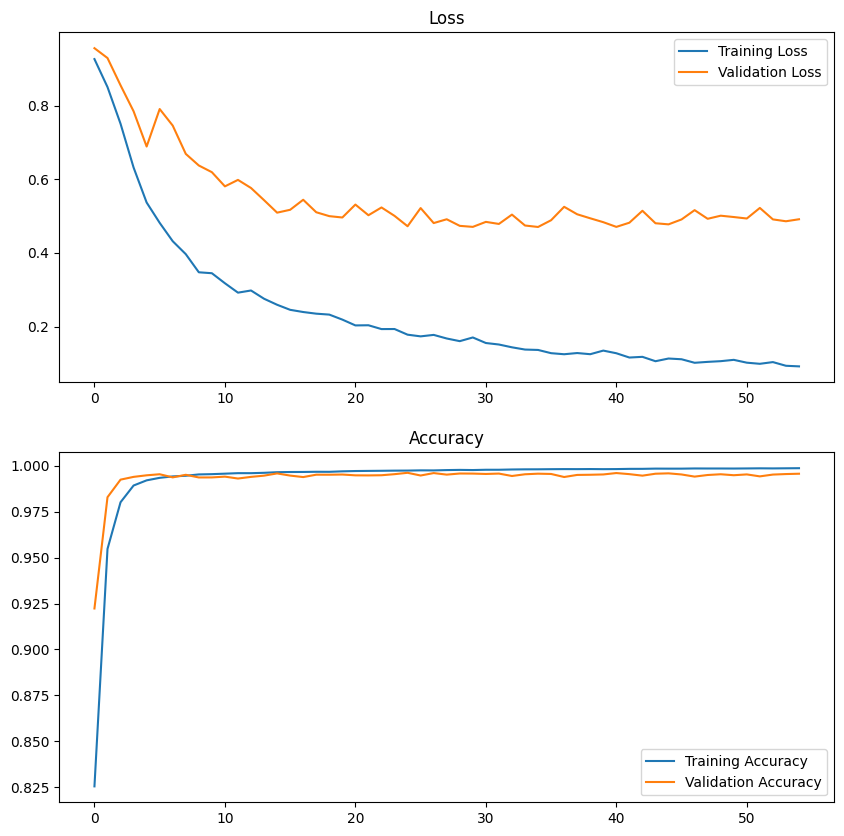

Validation Metrics: {'TPR': 0.6003632545471191, 'Accuracy': 0.996138334274292, 'Dice': 0.3307713270187378, 'Loss': 0.47228536009788513}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.7875314950942993, 'Accuracy': 0.9975348711013794, 'Dice': 0.5844064179588767, 'Loss': 0.17351983575259938}


------------------------------------------------------------------------------------------------------------------


In [30]:
model = train_model(model, train_loader, val_loader, loss_function, optimizer, device, num_epochs, patience, l1_lambda)

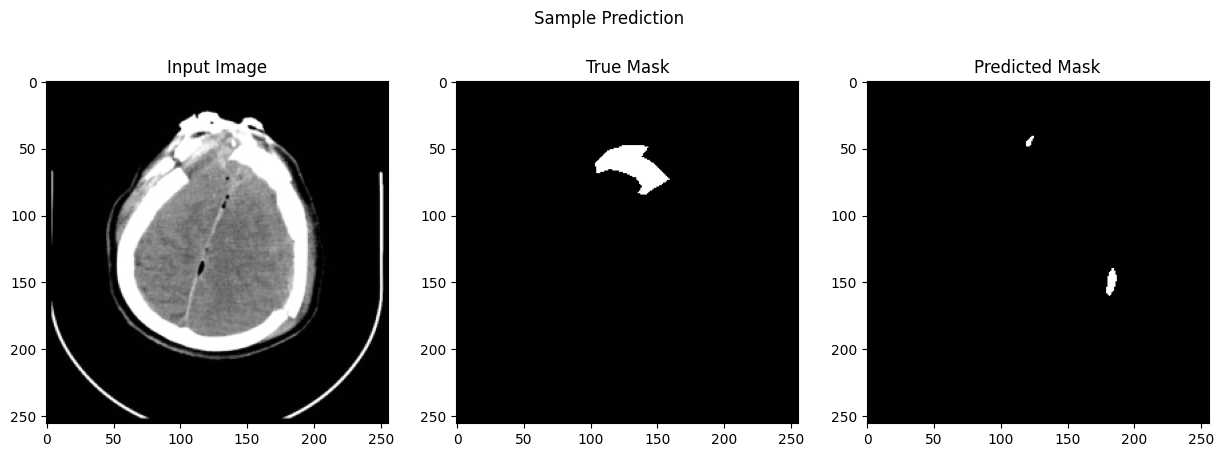

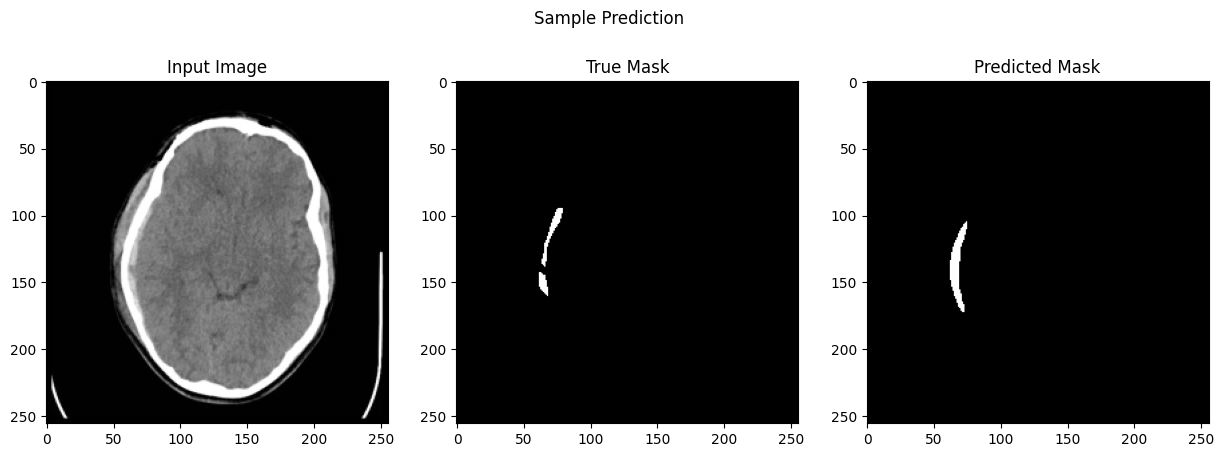

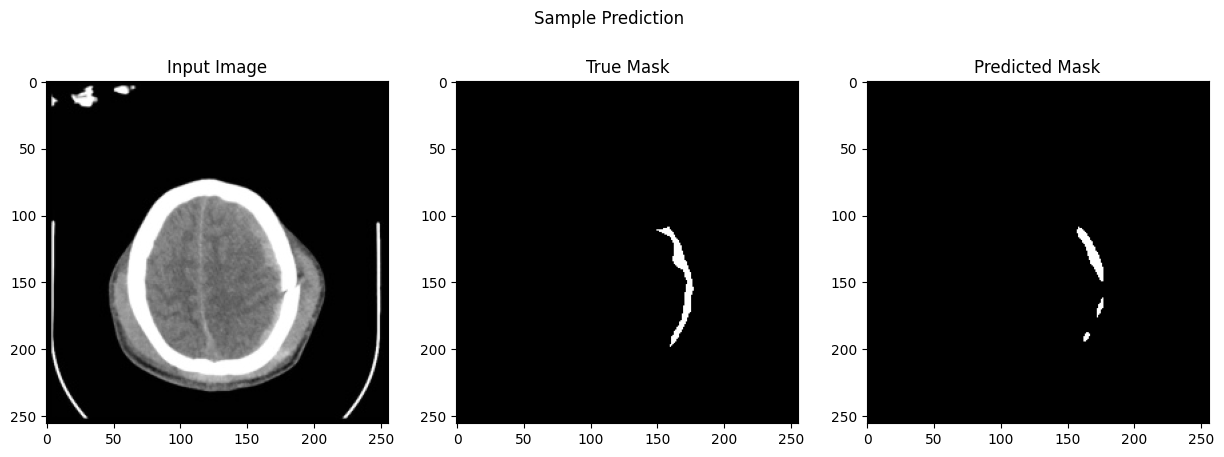

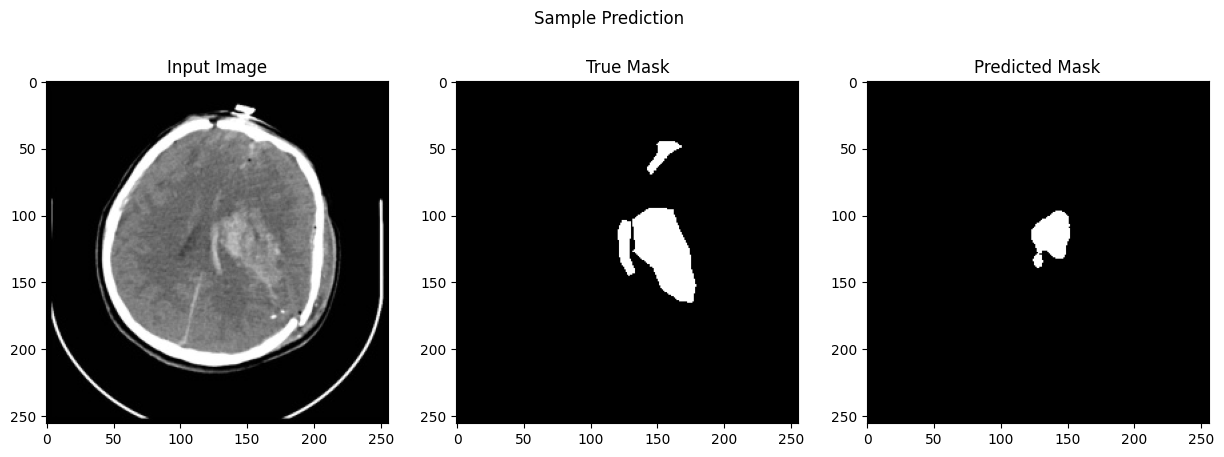

{'TPR': 0.43344151973724365,
 'Accuracy': 0.9913625717163086,
 'Dice': 0.41684743762016296,
 'Loss': 0.47079819440841675}

In [31]:
calculate_metrics(model, test_loader, loss_function, True, device)

### b (different Learning rate)

In [32]:
dataset1 = "/kaggle/input/aimiassigmnet2/Dataset1"

train_files_dir = os.path.join(dataset1, "TrainFiles")
train_mask_dir = os.path.join(dataset1, "TrainMask")
val_files_dir = os.path.join(dataset1, "ValFiles")
val_mask_dir = os.path.join(dataset1, "ValMask")
test_files_dir = os.path.join(dataset1, "TestFiles")
test_mask_dir = os.path.join(dataset1, "TestMask")

train_dataset_tensor, train_mask_tensor = file_to_tensor(train_files_dir, train_mask_dir, augment=False, num_aug= 3)
val_dataset_tensor, val_mask_tensor = file_to_tensor(val_files_dir, val_mask_dir, augment=False)
test_dataset_tensor, test_mask_tensor = file_to_tensor(test_files_dir, test_mask_dir, augment=False)

print(train_dataset_tensor.shape, train_mask_tensor.shape)
print(val_dataset_tensor.shape, val_mask_tensor.shape)
print(test_dataset_tensor.shape, test_mask_tensor.shape)

torch.Size([202, 1, 256, 256]) torch.Size([202, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])


In [33]:
loss_functions = [
    smp.losses.DiceLoss("binary"),
    smp.losses.DiceLoss("binary"),
    smp.losses.DiceLoss("binary"),
] # Define a list of loss functions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = [basicCNN() for _ in range(len(loss_functions))] # Create a list of models for each loss function
# models = [UNetResNet50Grayscale() for _ in range(len(loss_functions))]

optimizers = [optim.Adam(models[0].parameters(), lr=0.002), optim.Adam(models[1].parameters(), lr=0.0001), optim.Adam(models[2].parameters(), lr=0.000000001)] # Create a list of optimizers for each model

final_trained_model = [] # List to store the final trained model for each loss function

num_epochs = 1000
patience = 30

------------------------------------------------------------------------------------------------------------------
Training Model 1 with DiceLoss


Epoch 1/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.8297, Train Accuracy: 0.9230, Val Loss: 0.7749, Val Accuracy: 0.9877
fist save with Validation loss --> 0.774884).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.6803, Train Accuracy: 0.9879, Val Loss: 0.7101, Val Accuracy: 0.9960
Validation loss decreased (0.774884 --> 0.710062).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.5766, Train Accuracy: 0.9911, Val Loss: 0.7699, Val Accuracy: 0.9967
EarlyStopping counter: 1 out of 30


Epoch 4/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

All predictions are 0 or 1, cannot calculate metrics
Epoch [4/1000], Train Loss: 0.5111, Train Accuracy: 0.9927, Val Loss: 0.8370, Val Accuracy: 0.9967
EarlyStopping counter: 2 out of 30


Epoch 5/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.5147, Train Accuracy: 0.9929, Val Loss: 0.5360, Val Accuracy: 0.9972
Validation loss decreased (0.710062 --> 0.536045).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.4547, Train Accuracy: 0.9936, Val Loss: 0.5783, Val Accuracy: 0.9968
EarlyStopping counter: 1 out of 30


Epoch 7/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.4095, Train Accuracy: 0.9942, Val Loss: 0.5728, Val Accuracy: 0.9971
EarlyStopping counter: 2 out of 30


Epoch 8/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

All predictions are 0 or 1, cannot calculate metrics
Epoch [8/1000], Train Loss: 0.3878, Train Accuracy: 0.9945, Val Loss: 0.4667, Val Accuracy: 0.9974
Validation loss decreased (0.536045 --> 0.466678).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.3693, Train Accuracy: 0.9948, Val Loss: 0.5771, Val Accuracy: 0.9971
EarlyStopping counter: 1 out of 30


Epoch 10/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.3563, Train Accuracy: 0.9951, Val Loss: 0.5260, Val Accuracy: 0.9970
EarlyStopping counter: 2 out of 30


Epoch 11/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.3378, Train Accuracy: 0.9952, Val Loss: 0.5276, Val Accuracy: 0.9975
EarlyStopping counter: 3 out of 30


Epoch 12/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.3362, Train Accuracy: 0.9954, Val Loss: 0.5253, Val Accuracy: 0.9969
EarlyStopping counter: 4 out of 30


Epoch 13/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.3437, Train Accuracy: 0.9951, Val Loss: 0.4738, Val Accuracy: 0.9975
EarlyStopping counter: 5 out of 30


Epoch 14/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

All predictions are 0 or 1, cannot calculate metrics
Epoch [14/1000], Train Loss: 0.3245, Train Accuracy: 0.9954, Val Loss: 0.4068, Val Accuracy: 0.9972
Validation loss decreased (0.466678 --> 0.406791).  Saving model ...


Epoch 15/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.3107, Train Accuracy: 0.9956, Val Loss: 0.3845, Val Accuracy: 0.9977
Validation loss decreased (0.406791 --> 0.384476).  Saving model ...


Epoch 16/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.2928, Train Accuracy: 0.9959, Val Loss: 0.4812, Val Accuracy: 0.9972
EarlyStopping counter: 1 out of 30


Epoch 17/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.3004, Train Accuracy: 0.9958, Val Loss: 0.3999, Val Accuracy: 0.9973
EarlyStopping counter: 2 out of 30


Epoch 18/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.2859, Train Accuracy: 0.9959, Val Loss: 0.4019, Val Accuracy: 0.9974
EarlyStopping counter: 3 out of 30


Epoch 19/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.2781, Train Accuracy: 0.9960, Val Loss: 0.9047, Val Accuracy: 0.9919
EarlyStopping counter: 4 out of 30


Epoch 20/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.3008, Train Accuracy: 0.9957, Val Loss: 0.4165, Val Accuracy: 0.9975
EarlyStopping counter: 5 out of 30


Epoch 21/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.2793, Train Accuracy: 0.9959, Val Loss: 0.3685, Val Accuracy: 0.9978
Validation loss decreased (0.384476 --> 0.368540).  Saving model ...


Epoch 22/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.2792, Train Accuracy: 0.9960, Val Loss: 0.4655, Val Accuracy: 0.9975
EarlyStopping counter: 1 out of 30


Epoch 23/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.2805, Train Accuracy: 0.9960, Val Loss: 0.3749, Val Accuracy: 0.9977
EarlyStopping counter: 2 out of 30


Epoch 24/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.2503, Train Accuracy: 0.9963, Val Loss: 0.4297, Val Accuracy: 0.9977
EarlyStopping counter: 3 out of 30


Epoch 25/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.2450, Train Accuracy: 0.9965, Val Loss: 0.3991, Val Accuracy: 0.9978
EarlyStopping counter: 4 out of 30


Epoch 26/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.2415, Train Accuracy: 0.9965, Val Loss: 0.3311, Val Accuracy: 0.9979
Validation loss decreased (0.368540 --> 0.331069).  Saving model ...


Epoch 27/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.2314, Train Accuracy: 0.9966, Val Loss: 0.3780, Val Accuracy: 0.9978
EarlyStopping counter: 1 out of 30


Epoch 28/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.2481, Train Accuracy: 0.9965, Val Loss: 0.3651, Val Accuracy: 0.9978
EarlyStopping counter: 2 out of 30


Epoch 29/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.2331, Train Accuracy: 0.9966, Val Loss: 0.3690, Val Accuracy: 0.9977
EarlyStopping counter: 3 out of 30


Epoch 30/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.2370, Train Accuracy: 0.9966, Val Loss: 0.3763, Val Accuracy: 0.9977
EarlyStopping counter: 4 out of 30


Epoch 31/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.2182, Train Accuracy: 0.9967, Val Loss: 0.3378, Val Accuracy: 0.9977
EarlyStopping counter: 5 out of 30


Epoch 32/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.2097, Train Accuracy: 0.9969, Val Loss: 0.3915, Val Accuracy: 0.9977
EarlyStopping counter: 6 out of 30


Epoch 33/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.2044, Train Accuracy: 0.9970, Val Loss: 0.3501, Val Accuracy: 0.9976
EarlyStopping counter: 7 out of 30


Epoch 34/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.2150, Train Accuracy: 0.9969, Val Loss: 0.3468, Val Accuracy: 0.9973
EarlyStopping counter: 8 out of 30


Epoch 35/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.2055, Train Accuracy: 0.9970, Val Loss: 0.3548, Val Accuracy: 0.9974
EarlyStopping counter: 9 out of 30


Epoch 36/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.1983, Train Accuracy: 0.9971, Val Loss: 0.3465, Val Accuracy: 0.9973
EarlyStopping counter: 10 out of 30


Epoch 37/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.2035, Train Accuracy: 0.9972, Val Loss: 0.3890, Val Accuracy: 0.9975
EarlyStopping counter: 11 out of 30


Epoch 38/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.2003, Train Accuracy: 0.9971, Val Loss: 0.3678, Val Accuracy: 0.9975
EarlyStopping counter: 12 out of 30


Epoch 39/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.1861, Train Accuracy: 0.9972, Val Loss: 0.3558, Val Accuracy: 0.9975
EarlyStopping counter: 13 out of 30


Epoch 40/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.1780, Train Accuracy: 0.9973, Val Loss: 0.4131, Val Accuracy: 0.9970
EarlyStopping counter: 14 out of 30


Epoch 41/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.1780, Train Accuracy: 0.9974, Val Loss: 0.4733, Val Accuracy: 0.9953
EarlyStopping counter: 15 out of 30


Epoch 42/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.1621, Train Accuracy: 0.9975, Val Loss: 0.4726, Val Accuracy: 0.9968
EarlyStopping counter: 16 out of 30


Epoch 43/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.1560, Train Accuracy: 0.9976, Val Loss: 0.4552, Val Accuracy: 0.9965
EarlyStopping counter: 17 out of 30


Epoch 44/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.1452, Train Accuracy: 0.9978, Val Loss: 0.4635, Val Accuracy: 0.9961
EarlyStopping counter: 18 out of 30


Epoch 45/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.1368, Train Accuracy: 0.9979, Val Loss: 0.4882, Val Accuracy: 0.9967
EarlyStopping counter: 19 out of 30


Epoch 46/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.1296, Train Accuracy: 0.9980, Val Loss: 0.4622, Val Accuracy: 0.9963
EarlyStopping counter: 20 out of 30


Epoch 47/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.1256, Train Accuracy: 0.9981, Val Loss: 0.5159, Val Accuracy: 0.9945
EarlyStopping counter: 21 out of 30


Epoch 48/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.1286, Train Accuracy: 0.9980, Val Loss: 0.4685, Val Accuracy: 0.9951
EarlyStopping counter: 22 out of 30


Epoch 49/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.1265, Train Accuracy: 0.9981, Val Loss: 0.4754, Val Accuracy: 0.9951
EarlyStopping counter: 23 out of 30


Epoch 50/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.1221, Train Accuracy: 0.9982, Val Loss: 0.4512, Val Accuracy: 0.9959
EarlyStopping counter: 24 out of 30


Epoch 51/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.1220, Train Accuracy: 0.9981, Val Loss: 0.5129, Val Accuracy: 0.9959
EarlyStopping counter: 25 out of 30


Epoch 52/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.1158, Train Accuracy: 0.9982, Val Loss: 0.4749, Val Accuracy: 0.9959
EarlyStopping counter: 26 out of 30


Epoch 53/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.1177, Train Accuracy: 0.9982, Val Loss: 0.4778, Val Accuracy: 0.9959
EarlyStopping counter: 27 out of 30


Epoch 54/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.1097, Train Accuracy: 0.9983, Val Loss: 0.4600, Val Accuracy: 0.9963
EarlyStopping counter: 28 out of 30


Epoch 55/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.1183, Train Accuracy: 0.9982, Val Loss: 0.5123, Val Accuracy: 0.9951
EarlyStopping counter: 29 out of 30


Epoch 56/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.1077, Train Accuracy: 0.9984, Val Loss: 0.5189, Val Accuracy: 0.9950
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2137310240.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


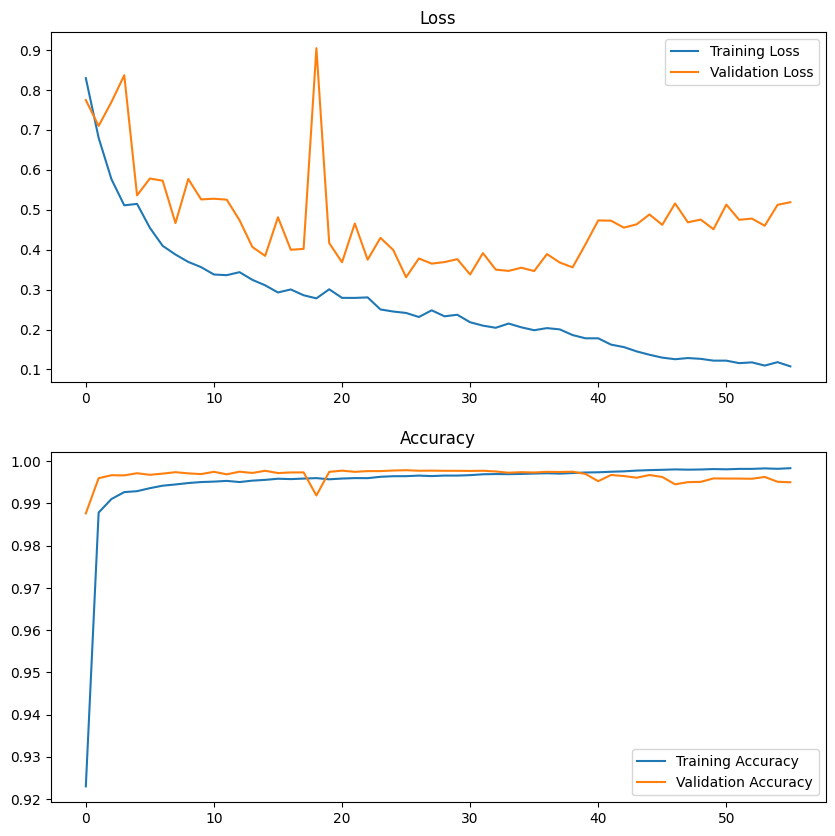

Validation Metrics: {'TPR': 0.6345600485801697, 'Accuracy': 0.9978792667388916, 'Dice': 0.4271673709154129, 'Loss': 0.33106866478919983}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.7419083714485168, 'Accuracy': 0.9965442419052124, 'Dice': 0.5242831444039064, 'Loss': 0.22419257958730063}


------------------------------------------------------------------------------------------------------------------
Model 1 training complete.


------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Training Model 2 with DiceLoss


Epoch 1/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.9208, Train Accuracy: 0.8428, Val Loss: 0.9511, Val Accuracy: 0.9160
fist save with Validation loss --> 0.951118).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.8369, Train Accuracy: 0.9583, Val Loss: 0.9663, Val Accuracy: 0.9942
EarlyStopping counter: 1 out of 30


Epoch 3/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.6994, Train Accuracy: 0.9843, Val Loss: 0.9447, Val Accuracy: 0.9967
Validation loss decreased (0.951118 --> 0.944749).  Saving model ...


Epoch 4/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.5857, Train Accuracy: 0.9907, Val Loss: 0.8086, Val Accuracy: 0.9942
Validation loss decreased (0.944749 --> 0.808557).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.4804, Train Accuracy: 0.9933, Val Loss: 0.6828, Val Accuracy: 0.9942
Validation loss decreased (0.808557 --> 0.682806).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.4175, Train Accuracy: 0.9943, Val Loss: 0.6526, Val Accuracy: 0.9956
Validation loss decreased (0.682806 --> 0.652593).  Saving model ...


Epoch 7/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.3860, Train Accuracy: 0.9947, Val Loss: 0.5873, Val Accuracy: 0.9964
Validation loss decreased (0.652593 --> 0.587318).  Saving model ...


Epoch 8/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.3453, Train Accuracy: 0.9952, Val Loss: 0.5810, Val Accuracy: 0.9941
Validation loss decreased (0.587318 --> 0.581001).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.3193, Train Accuracy: 0.9955, Val Loss: 0.5629, Val Accuracy: 0.9960
Validation loss decreased (0.581001 --> 0.562868).  Saving model ...


Epoch 10/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.2960, Train Accuracy: 0.9959, Val Loss: 0.5535, Val Accuracy: 0.9951
Validation loss decreased (0.562868 --> 0.553515).  Saving model ...


Epoch 11/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.2848, Train Accuracy: 0.9960, Val Loss: 0.5726, Val Accuracy: 0.9942
EarlyStopping counter: 1 out of 30


Epoch 12/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.2914, Train Accuracy: 0.9960, Val Loss: 0.5495, Val Accuracy: 0.9946
EarlyStopping counter: 2 out of 30


Epoch 13/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.2495, Train Accuracy: 0.9964, Val Loss: 0.5413, Val Accuracy: 0.9951
Validation loss decreased (0.553515 --> 0.541316).  Saving model ...


Epoch 14/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.2629, Train Accuracy: 0.9964, Val Loss: 0.5175, Val Accuracy: 0.9953
Validation loss decreased (0.541316 --> 0.517527).  Saving model ...


Epoch 15/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.2272, Train Accuracy: 0.9967, Val Loss: 0.5382, Val Accuracy: 0.9947
EarlyStopping counter: 1 out of 30


Epoch 16/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.2240, Train Accuracy: 0.9968, Val Loss: 0.5317, Val Accuracy: 0.9947
EarlyStopping counter: 2 out of 30


Epoch 17/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.2133, Train Accuracy: 0.9970, Val Loss: 0.5490, Val Accuracy: 0.9937
EarlyStopping counter: 3 out of 30


Epoch 18/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.2146, Train Accuracy: 0.9970, Val Loss: 0.5009, Val Accuracy: 0.9954
Validation loss decreased (0.517527 --> 0.500950).  Saving model ...


Epoch 19/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.2094, Train Accuracy: 0.9971, Val Loss: 0.4867, Val Accuracy: 0.9955
Validation loss decreased (0.500950 --> 0.486686).  Saving model ...


Epoch 20/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.1869, Train Accuracy: 0.9973, Val Loss: 0.4978, Val Accuracy: 0.9955
EarlyStopping counter: 1 out of 30


Epoch 21/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.1980, Train Accuracy: 0.9971, Val Loss: 0.5124, Val Accuracy: 0.9950
EarlyStopping counter: 2 out of 30


Epoch 22/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.1730, Train Accuracy: 0.9974, Val Loss: 0.5194, Val Accuracy: 0.9953
EarlyStopping counter: 3 out of 30


Epoch 23/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.1735, Train Accuracy: 0.9975, Val Loss: 0.4844, Val Accuracy: 0.9959
EarlyStopping counter: 4 out of 30


Epoch 24/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.1768, Train Accuracy: 0.9974, Val Loss: 0.4851, Val Accuracy: 0.9960
EarlyStopping counter: 5 out of 30


Epoch 25/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.1580, Train Accuracy: 0.9977, Val Loss: 0.5119, Val Accuracy: 0.9947
EarlyStopping counter: 6 out of 30


Epoch 26/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.1624, Train Accuracy: 0.9976, Val Loss: 0.4851, Val Accuracy: 0.9955
EarlyStopping counter: 7 out of 30


Epoch 27/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.1498, Train Accuracy: 0.9978, Val Loss: 0.5054, Val Accuracy: 0.9955
EarlyStopping counter: 8 out of 30


Epoch 28/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.1578, Train Accuracy: 0.9978, Val Loss: 0.5293, Val Accuracy: 0.9946
EarlyStopping counter: 9 out of 30


Epoch 29/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.1461, Train Accuracy: 0.9979, Val Loss: 0.4974, Val Accuracy: 0.9964
EarlyStopping counter: 10 out of 30


Epoch 30/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.1380, Train Accuracy: 0.9980, Val Loss: 0.4948, Val Accuracy: 0.9955
EarlyStopping counter: 11 out of 30


Epoch 31/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.1389, Train Accuracy: 0.9980, Val Loss: 0.4896, Val Accuracy: 0.9960
EarlyStopping counter: 12 out of 30


Epoch 32/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.1280, Train Accuracy: 0.9981, Val Loss: 0.4862, Val Accuracy: 0.9958
EarlyStopping counter: 13 out of 30


Epoch 33/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.1274, Train Accuracy: 0.9981, Val Loss: 0.5058, Val Accuracy: 0.9953
EarlyStopping counter: 14 out of 30


Epoch 34/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.1306, Train Accuracy: 0.9981, Val Loss: 0.4882, Val Accuracy: 0.9956
EarlyStopping counter: 15 out of 30


Epoch 35/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.1194, Train Accuracy: 0.9982, Val Loss: 0.4777, Val Accuracy: 0.9959
Validation loss decreased (0.486686 --> 0.477717).  Saving model ...


Epoch 36/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.1257, Train Accuracy: 0.9982, Val Loss: 0.4791, Val Accuracy: 0.9960
EarlyStopping counter: 1 out of 30


Epoch 37/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.1177, Train Accuracy: 0.9983, Val Loss: 0.4885, Val Accuracy: 0.9960
EarlyStopping counter: 2 out of 30


Epoch 38/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.1142, Train Accuracy: 0.9984, Val Loss: 0.5070, Val Accuracy: 0.9951
EarlyStopping counter: 3 out of 30


Epoch 39/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.1174, Train Accuracy: 0.9983, Val Loss: 0.5144, Val Accuracy: 0.9959
EarlyStopping counter: 4 out of 30


Epoch 40/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.1148, Train Accuracy: 0.9984, Val Loss: 0.4852, Val Accuracy: 0.9958
EarlyStopping counter: 5 out of 30


Epoch 41/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.1104, Train Accuracy: 0.9984, Val Loss: 0.4976, Val Accuracy: 0.9955
EarlyStopping counter: 6 out of 30


Epoch 42/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.1041, Train Accuracy: 0.9985, Val Loss: 0.4857, Val Accuracy: 0.9961
EarlyStopping counter: 7 out of 30


Epoch 43/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.1053, Train Accuracy: 0.9984, Val Loss: 0.4744, Val Accuracy: 0.9961
EarlyStopping counter: 8 out of 30


Epoch 44/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.0970, Train Accuracy: 0.9986, Val Loss: 0.4978, Val Accuracy: 0.9957
EarlyStopping counter: 9 out of 30


Epoch 45/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.1252, Train Accuracy: 0.9982, Val Loss: 0.4830, Val Accuracy: 0.9966
EarlyStopping counter: 10 out of 30


Epoch 46/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.1037, Train Accuracy: 0.9985, Val Loss: 0.4897, Val Accuracy: 0.9958
EarlyStopping counter: 11 out of 30


Epoch 47/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.0982, Train Accuracy: 0.9986, Val Loss: 0.4797, Val Accuracy: 0.9963
EarlyStopping counter: 12 out of 30


Epoch 48/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.0872, Train Accuracy: 0.9987, Val Loss: 0.4749, Val Accuracy: 0.9964
EarlyStopping counter: 13 out of 30


Epoch 49/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.0862, Train Accuracy: 0.9987, Val Loss: 0.4876, Val Accuracy: 0.9957
EarlyStopping counter: 14 out of 30


Epoch 50/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.0863, Train Accuracy: 0.9987, Val Loss: 0.5020, Val Accuracy: 0.9954
EarlyStopping counter: 15 out of 30


Epoch 51/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.0890, Train Accuracy: 0.9987, Val Loss: 0.4923, Val Accuracy: 0.9961
EarlyStopping counter: 16 out of 30


Epoch 52/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.0879, Train Accuracy: 0.9987, Val Loss: 0.4748, Val Accuracy: 0.9964
EarlyStopping counter: 17 out of 30


Epoch 53/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.0876, Train Accuracy: 0.9987, Val Loss: 0.4644, Val Accuracy: 0.9963
Validation loss decreased (0.477717 --> 0.464353).  Saving model ...


Epoch 54/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.0834, Train Accuracy: 0.9988, Val Loss: 0.4763, Val Accuracy: 0.9960
EarlyStopping counter: 1 out of 30


Epoch 55/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.0835, Train Accuracy: 0.9988, Val Loss: 0.4896, Val Accuracy: 0.9960
EarlyStopping counter: 2 out of 30


Epoch 56/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.0807, Train Accuracy: 0.9988, Val Loss: 0.4998, Val Accuracy: 0.9955
EarlyStopping counter: 3 out of 30


Epoch 57/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.0755, Train Accuracy: 0.9989, Val Loss: 0.4981, Val Accuracy: 0.9955
EarlyStopping counter: 4 out of 30


Epoch 58/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.0757, Train Accuracy: 0.9989, Val Loss: 0.5030, Val Accuracy: 0.9956
EarlyStopping counter: 5 out of 30


Epoch 59/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [59/1000], Train Loss: 0.0799, Train Accuracy: 0.9989, Val Loss: 0.4770, Val Accuracy: 0.9962
EarlyStopping counter: 6 out of 30


Epoch 60/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [60/1000], Train Loss: 0.0742, Train Accuracy: 0.9989, Val Loss: 0.4919, Val Accuracy: 0.9953
EarlyStopping counter: 7 out of 30


Epoch 61/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [61/1000], Train Loss: 0.0767, Train Accuracy: 0.9989, Val Loss: 0.4932, Val Accuracy: 0.9954
EarlyStopping counter: 8 out of 30


Epoch 62/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [62/1000], Train Loss: 0.0788, Train Accuracy: 0.9989, Val Loss: 0.5184, Val Accuracy: 0.9954
EarlyStopping counter: 9 out of 30


Epoch 63/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [63/1000], Train Loss: 0.0755, Train Accuracy: 0.9989, Val Loss: 0.4825, Val Accuracy: 0.9955
EarlyStopping counter: 10 out of 30


Epoch 64/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [64/1000], Train Loss: 0.0713, Train Accuracy: 0.9990, Val Loss: 0.5003, Val Accuracy: 0.9955
EarlyStopping counter: 11 out of 30


Epoch 65/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [65/1000], Train Loss: 0.0737, Train Accuracy: 0.9989, Val Loss: 0.4797, Val Accuracy: 0.9962
EarlyStopping counter: 12 out of 30


Epoch 66/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [66/1000], Train Loss: 0.0717, Train Accuracy: 0.9989, Val Loss: 0.5002, Val Accuracy: 0.9951
EarlyStopping counter: 13 out of 30


Epoch 67/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [67/1000], Train Loss: 0.0744, Train Accuracy: 0.9989, Val Loss: 0.4848, Val Accuracy: 0.9957
EarlyStopping counter: 14 out of 30


Epoch 68/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [68/1000], Train Loss: 0.0682, Train Accuracy: 0.9990, Val Loss: 0.4863, Val Accuracy: 0.9959
EarlyStopping counter: 15 out of 30


Epoch 69/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [69/1000], Train Loss: 0.0692, Train Accuracy: 0.9990, Val Loss: 0.5070, Val Accuracy: 0.9955
EarlyStopping counter: 16 out of 30


Epoch 70/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [70/1000], Train Loss: 0.0652, Train Accuracy: 0.9990, Val Loss: 0.4971, Val Accuracy: 0.9955
EarlyStopping counter: 17 out of 30


Epoch 71/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [71/1000], Train Loss: 0.0677, Train Accuracy: 0.9990, Val Loss: 0.5023, Val Accuracy: 0.9957
EarlyStopping counter: 18 out of 30


Epoch 72/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [72/1000], Train Loss: 0.0660, Train Accuracy: 0.9990, Val Loss: 0.4888, Val Accuracy: 0.9961
EarlyStopping counter: 19 out of 30


Epoch 73/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [73/1000], Train Loss: 0.0641, Train Accuracy: 0.9991, Val Loss: 0.4982, Val Accuracy: 0.9957
EarlyStopping counter: 20 out of 30


Epoch 74/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [74/1000], Train Loss: 0.0606, Train Accuracy: 0.9991, Val Loss: 0.4897, Val Accuracy: 0.9956
EarlyStopping counter: 21 out of 30


Epoch 75/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [75/1000], Train Loss: 0.0658, Train Accuracy: 0.9991, Val Loss: 0.4906, Val Accuracy: 0.9963
EarlyStopping counter: 22 out of 30


Epoch 76/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [76/1000], Train Loss: 0.0636, Train Accuracy: 0.9991, Val Loss: 0.4619, Val Accuracy: 0.9963
EarlyStopping counter: 23 out of 30


Epoch 77/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [77/1000], Train Loss: 0.0585, Train Accuracy: 0.9991, Val Loss: 0.4930, Val Accuracy: 0.9959
EarlyStopping counter: 24 out of 30


Epoch 78/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [78/1000], Train Loss: 0.0625, Train Accuracy: 0.9991, Val Loss: 0.4726, Val Accuracy: 0.9960
EarlyStopping counter: 25 out of 30


Epoch 79/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [79/1000], Train Loss: 0.0579, Train Accuracy: 0.9991, Val Loss: 0.4740, Val Accuracy: 0.9960
EarlyStopping counter: 26 out of 30


Epoch 80/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [80/1000], Train Loss: 0.0614, Train Accuracy: 0.9991, Val Loss: 0.4774, Val Accuracy: 0.9964
EarlyStopping counter: 27 out of 30


Epoch 81/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [81/1000], Train Loss: 0.0608, Train Accuracy: 0.9991, Val Loss: 0.5053, Val Accuracy: 0.9952
EarlyStopping counter: 28 out of 30


Epoch 82/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [82/1000], Train Loss: 0.0604, Train Accuracy: 0.9991, Val Loss: 0.4909, Val Accuracy: 0.9960
EarlyStopping counter: 29 out of 30


Epoch 83/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [83/1000], Train Loss: 0.0572, Train Accuracy: 0.9992, Val Loss: 0.5025, Val Accuracy: 0.9956
EarlyStopping counter: 30 out of 30
Early stopping


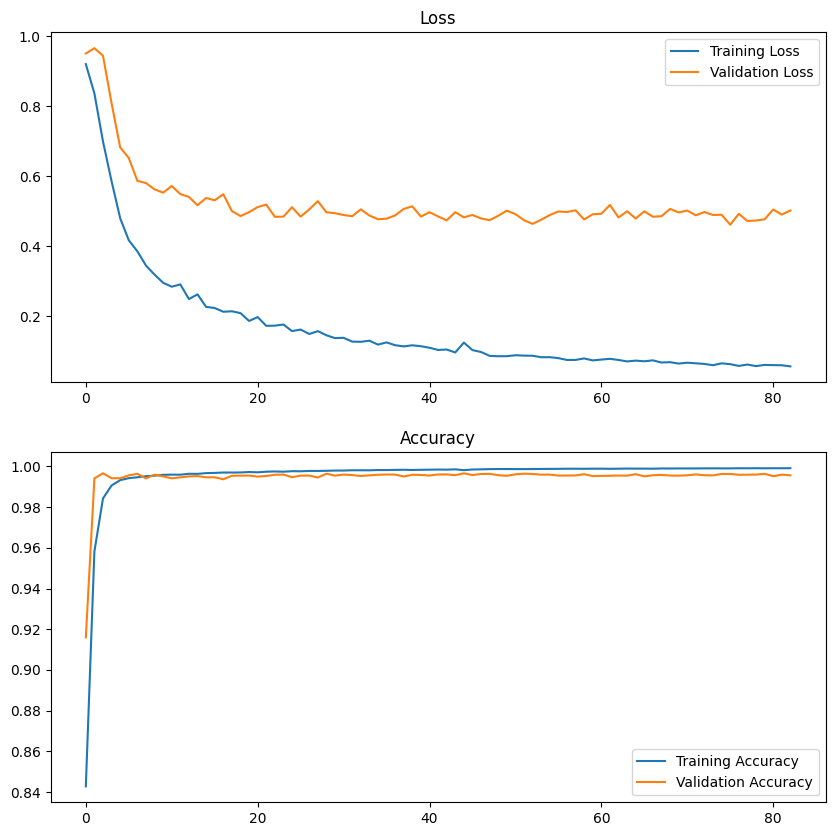

Validation Metrics: {'TPR': 0.6135578155517578, 'Accuracy': 0.9963204860687256, 'Dice': 0.4232018794864416, 'Loss': 0.4643530547618866}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.9007265567779541, 'Accuracy': 0.9988051652908325, 'Dice': 0.75658125854006, 'Loss': 0.08419135271334181}


------------------------------------------------------------------------------------------------------------------
Model 2 training complete.


------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Training Model 3 with DiceLoss


Epoch 1/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.9852, Train Accuracy: 0.7448, Val Loss: 0.9939, Val Accuracy: 0.7850
fist save with Validation loss --> 0.993890).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.9851, Train Accuracy: 0.7451, Val Loss: 0.9947, Val Accuracy: 0.7497
EarlyStopping counter: 1 out of 300


Epoch 3/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.9852, Train Accuracy: 0.7449, Val Loss: 0.9947, Val Accuracy: 0.7482
EarlyStopping counter: 2 out of 300


Epoch 4/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.9851, Train Accuracy: 0.7448, Val Loss: 0.9947, Val Accuracy: 0.7488
EarlyStopping counter: 3 out of 300


Epoch 5/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.9851, Train Accuracy: 0.7453, Val Loss: 0.9947, Val Accuracy: 0.7503
EarlyStopping counter: 4 out of 300


Epoch 6/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.9850, Train Accuracy: 0.7448, Val Loss: 0.9947, Val Accuracy: 0.7512
EarlyStopping counter: 5 out of 300


Epoch 7/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.9852, Train Accuracy: 0.7453, Val Loss: 0.9947, Val Accuracy: 0.7483
EarlyStopping counter: 6 out of 300


Epoch 8/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.9852, Train Accuracy: 0.7451, Val Loss: 0.9947, Val Accuracy: 0.7488
EarlyStopping counter: 7 out of 300


Epoch 9/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.9852, Train Accuracy: 0.7448, Val Loss: 0.9947, Val Accuracy: 0.7495
EarlyStopping counter: 8 out of 300


Epoch 10/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.9851, Train Accuracy: 0.7450, Val Loss: 0.9946, Val Accuracy: 0.7483
EarlyStopping counter: 9 out of 300


Epoch 11/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.9851, Train Accuracy: 0.7452, Val Loss: 0.9947, Val Accuracy: 0.7500
EarlyStopping counter: 10 out of 300


Epoch 12/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.9852, Train Accuracy: 0.7452, Val Loss: 0.9947, Val Accuracy: 0.7516
EarlyStopping counter: 11 out of 300


Epoch 13/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.9851, Train Accuracy: 0.7454, Val Loss: 0.9947, Val Accuracy: 0.7506
EarlyStopping counter: 12 out of 300


Epoch 14/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.9850, Train Accuracy: 0.7454, Val Loss: 0.9947, Val Accuracy: 0.7506
EarlyStopping counter: 13 out of 300


Epoch 15/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.9851, Train Accuracy: 0.7452, Val Loss: 0.9946, Val Accuracy: 0.7489
EarlyStopping counter: 14 out of 300


Epoch 16/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.9851, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7513
EarlyStopping counter: 15 out of 300


Epoch 17/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.9851, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7485
EarlyStopping counter: 16 out of 300


Epoch 18/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.9851, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7495
EarlyStopping counter: 17 out of 300


Epoch 19/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.9850, Train Accuracy: 0.7454, Val Loss: 0.9946, Val Accuracy: 0.7513
EarlyStopping counter: 18 out of 300


Epoch 20/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.9848, Train Accuracy: 0.7455, Val Loss: 0.9946, Val Accuracy: 0.7508
EarlyStopping counter: 19 out of 300


Epoch 21/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.9850, Train Accuracy: 0.7453, Val Loss: 0.9946, Val Accuracy: 0.7490
EarlyStopping counter: 20 out of 300


Epoch 22/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.9849, Train Accuracy: 0.7457, Val Loss: 0.9946, Val Accuracy: 0.7510
EarlyStopping counter: 21 out of 300


Epoch 23/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.9851, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7495
EarlyStopping counter: 22 out of 300


Epoch 24/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.9851, Train Accuracy: 0.7448, Val Loss: 0.9946, Val Accuracy: 0.7505
EarlyStopping counter: 23 out of 300


Epoch 25/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.9851, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7484
EarlyStopping counter: 24 out of 300


Epoch 26/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.9850, Train Accuracy: 0.7455, Val Loss: 0.9946, Val Accuracy: 0.7490
EarlyStopping counter: 25 out of 300


Epoch 27/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.9852, Train Accuracy: 0.7450, Val Loss: 0.9946, Val Accuracy: 0.7481
EarlyStopping counter: 26 out of 300


Epoch 28/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.9851, Train Accuracy: 0.7456, Val Loss: 0.9946, Val Accuracy: 0.7489
EarlyStopping counter: 27 out of 300


Epoch 29/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.9849, Train Accuracy: 0.7455, Val Loss: 0.9946, Val Accuracy: 0.7506
EarlyStopping counter: 28 out of 300


Epoch 30/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.9850, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7509
EarlyStopping counter: 29 out of 300


Epoch 31/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.9850, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7511
EarlyStopping counter: 30 out of 300


Epoch 32/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.9850, Train Accuracy: 0.7456, Val Loss: 0.9946, Val Accuracy: 0.7471
EarlyStopping counter: 31 out of 300


Epoch 33/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.9849, Train Accuracy: 0.7457, Val Loss: 0.9946, Val Accuracy: 0.7505
EarlyStopping counter: 32 out of 300


Epoch 34/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.9848, Train Accuracy: 0.7456, Val Loss: 0.9946, Val Accuracy: 0.7531
EarlyStopping counter: 33 out of 300


Epoch 35/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.9849, Train Accuracy: 0.7457, Val Loss: 0.9946, Val Accuracy: 0.7485
EarlyStopping counter: 34 out of 300


Epoch 36/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.9850, Train Accuracy: 0.7455, Val Loss: 0.9946, Val Accuracy: 0.7495
EarlyStopping counter: 35 out of 300


Epoch 37/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.9850, Train Accuracy: 0.7454, Val Loss: 0.9946, Val Accuracy: 0.7490
EarlyStopping counter: 36 out of 300


Epoch 38/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.9849, Train Accuracy: 0.7457, Val Loss: 0.9946, Val Accuracy: 0.7511
EarlyStopping counter: 37 out of 300


Epoch 39/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.9848, Train Accuracy: 0.7458, Val Loss: 0.9946, Val Accuracy: 0.7538
EarlyStopping counter: 38 out of 300


Epoch 40/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.9849, Train Accuracy: 0.7457, Val Loss: 0.9946, Val Accuracy: 0.7506
EarlyStopping counter: 39 out of 300


Epoch 41/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.9849, Train Accuracy: 0.7451, Val Loss: 0.9946, Val Accuracy: 0.7490
EarlyStopping counter: 40 out of 300


Epoch 42/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.9848, Train Accuracy: 0.7455, Val Loss: 0.9946, Val Accuracy: 0.7492
EarlyStopping counter: 41 out of 300


Epoch 43/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.9848, Train Accuracy: 0.7456, Val Loss: 0.9945, Val Accuracy: 0.7479
EarlyStopping counter: 42 out of 300


Epoch 44/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.9849, Train Accuracy: 0.7458, Val Loss: 0.9946, Val Accuracy: 0.7493
EarlyStopping counter: 43 out of 300


Epoch 45/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.9848, Train Accuracy: 0.7455, Val Loss: 0.9946, Val Accuracy: 0.7505
EarlyStopping counter: 44 out of 300


Epoch 46/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.9849, Train Accuracy: 0.7459, Val Loss: 0.9946, Val Accuracy: 0.7497
EarlyStopping counter: 45 out of 300


Epoch 47/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.9848, Train Accuracy: 0.7459, Val Loss: 0.9945, Val Accuracy: 0.7502
EarlyStopping counter: 46 out of 300


Epoch 48/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.9848, Train Accuracy: 0.7460, Val Loss: 0.9946, Val Accuracy: 0.7510
EarlyStopping counter: 47 out of 300


Epoch 49/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.9849, Train Accuracy: 0.7456, Val Loss: 0.9945, Val Accuracy: 0.7502
EarlyStopping counter: 48 out of 300


Epoch 50/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.9847, Train Accuracy: 0.7455, Val Loss: 0.9945, Val Accuracy: 0.7510
EarlyStopping counter: 49 out of 300


Epoch 51/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.9849, Train Accuracy: 0.7456, Val Loss: 0.9945, Val Accuracy: 0.7511
EarlyStopping counter: 50 out of 300


Epoch 52/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.9849, Train Accuracy: 0.7456, Val Loss: 0.9946, Val Accuracy: 0.7491
EarlyStopping counter: 51 out of 300


Epoch 53/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.9847, Train Accuracy: 0.7460, Val Loss: 0.9945, Val Accuracy: 0.7509
EarlyStopping counter: 52 out of 300


Epoch 54/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.9849, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7481
EarlyStopping counter: 53 out of 300


Epoch 55/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.9848, Train Accuracy: 0.7460, Val Loss: 0.9945, Val Accuracy: 0.7487
EarlyStopping counter: 54 out of 300


Epoch 56/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.9849, Train Accuracy: 0.7458, Val Loss: 0.9946, Val Accuracy: 0.7509
EarlyStopping counter: 55 out of 300


Epoch 57/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.9849, Train Accuracy: 0.7460, Val Loss: 0.9945, Val Accuracy: 0.7498
EarlyStopping counter: 56 out of 300


Epoch 58/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.9848, Train Accuracy: 0.7462, Val Loss: 0.9946, Val Accuracy: 0.7514
EarlyStopping counter: 57 out of 300


Epoch 59/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [59/1000], Train Loss: 0.9849, Train Accuracy: 0.7459, Val Loss: 0.9945, Val Accuracy: 0.7495
EarlyStopping counter: 58 out of 300


Epoch 60/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [60/1000], Train Loss: 0.9847, Train Accuracy: 0.7461, Val Loss: 0.9945, Val Accuracy: 0.7506
EarlyStopping counter: 59 out of 300


Epoch 61/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [61/1000], Train Loss: 0.9848, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7499
EarlyStopping counter: 60 out of 300


Epoch 62/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [62/1000], Train Loss: 0.9847, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7501
EarlyStopping counter: 61 out of 300


Epoch 63/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [63/1000], Train Loss: 0.9846, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7489
EarlyStopping counter: 62 out of 300


Epoch 64/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [64/1000], Train Loss: 0.9849, Train Accuracy: 0.7461, Val Loss: 0.9945, Val Accuracy: 0.7504
EarlyStopping counter: 63 out of 300


Epoch 65/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [65/1000], Train Loss: 0.9849, Train Accuracy: 0.7456, Val Loss: 0.9945, Val Accuracy: 0.7487
EarlyStopping counter: 64 out of 300


Epoch 66/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [66/1000], Train Loss: 0.9848, Train Accuracy: 0.7458, Val Loss: 0.9945, Val Accuracy: 0.7519
EarlyStopping counter: 65 out of 300


Epoch 67/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [67/1000], Train Loss: 0.9847, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7505
EarlyStopping counter: 66 out of 300


Epoch 68/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [68/1000], Train Loss: 0.9848, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7505
EarlyStopping counter: 67 out of 300


Epoch 69/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [69/1000], Train Loss: 0.9847, Train Accuracy: 0.7459, Val Loss: 0.9945, Val Accuracy: 0.7509
EarlyStopping counter: 68 out of 300


Epoch 70/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [70/1000], Train Loss: 0.9848, Train Accuracy: 0.7463, Val Loss: 0.9945, Val Accuracy: 0.7519
EarlyStopping counter: 69 out of 300


Epoch 71/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [71/1000], Train Loss: 0.9847, Train Accuracy: 0.7458, Val Loss: 0.9945, Val Accuracy: 0.7509
EarlyStopping counter: 70 out of 300


Epoch 72/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [72/1000], Train Loss: 0.9847, Train Accuracy: 0.7464, Val Loss: 0.9945, Val Accuracy: 0.7516
EarlyStopping counter: 71 out of 300


Epoch 73/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [73/1000], Train Loss: 0.9846, Train Accuracy: 0.7463, Val Loss: 0.9945, Val Accuracy: 0.7496
EarlyStopping counter: 72 out of 300


Epoch 74/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [74/1000], Train Loss: 0.9846, Train Accuracy: 0.7461, Val Loss: 0.9945, Val Accuracy: 0.7495
EarlyStopping counter: 73 out of 300


Epoch 75/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [75/1000], Train Loss: 0.9846, Train Accuracy: 0.7466, Val Loss: 0.9945, Val Accuracy: 0.7507
EarlyStopping counter: 74 out of 300


Epoch 76/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [76/1000], Train Loss: 0.9848, Train Accuracy: 0.7463, Val Loss: 0.9945, Val Accuracy: 0.7488
EarlyStopping counter: 75 out of 300


Epoch 77/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [77/1000], Train Loss: 0.9848, Train Accuracy: 0.7465, Val Loss: 0.9945, Val Accuracy: 0.7501
EarlyStopping counter: 76 out of 300


Epoch 78/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [78/1000], Train Loss: 0.9847, Train Accuracy: 0.7458, Val Loss: 0.9945, Val Accuracy: 0.7513
EarlyStopping counter: 77 out of 300


Epoch 79/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [79/1000], Train Loss: 0.9846, Train Accuracy: 0.7465, Val Loss: 0.9945, Val Accuracy: 0.7506
EarlyStopping counter: 78 out of 300


Epoch 80/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [80/1000], Train Loss: 0.9847, Train Accuracy: 0.7459, Val Loss: 0.9945, Val Accuracy: 0.7492
EarlyStopping counter: 79 out of 300


Epoch 81/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [81/1000], Train Loss: 0.9846, Train Accuracy: 0.7463, Val Loss: 0.9945, Val Accuracy: 0.7524
EarlyStopping counter: 80 out of 300


Epoch 82/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [82/1000], Train Loss: 0.9847, Train Accuracy: 0.7465, Val Loss: 0.9945, Val Accuracy: 0.7511
EarlyStopping counter: 81 out of 300


Epoch 83/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [83/1000], Train Loss: 0.9846, Train Accuracy: 0.7460, Val Loss: 0.9945, Val Accuracy: 0.7497
EarlyStopping counter: 82 out of 300


Epoch 84/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [84/1000], Train Loss: 0.9846, Train Accuracy: 0.7466, Val Loss: 0.9945, Val Accuracy: 0.7502
EarlyStopping counter: 83 out of 300


Epoch 85/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [85/1000], Train Loss: 0.9846, Train Accuracy: 0.7467, Val Loss: 0.9945, Val Accuracy: 0.7530
EarlyStopping counter: 84 out of 300


Epoch 86/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [86/1000], Train Loss: 0.9844, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7516
EarlyStopping counter: 85 out of 300


Epoch 87/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [87/1000], Train Loss: 0.9846, Train Accuracy: 0.7466, Val Loss: 0.9945, Val Accuracy: 0.7526
EarlyStopping counter: 86 out of 300


Epoch 88/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [88/1000], Train Loss: 0.9845, Train Accuracy: 0.7466, Val Loss: 0.9944, Val Accuracy: 0.7518
EarlyStopping counter: 87 out of 300


Epoch 89/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [89/1000], Train Loss: 0.9846, Train Accuracy: 0.7462, Val Loss: 0.9945, Val Accuracy: 0.7502
EarlyStopping counter: 88 out of 300


Epoch 90/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [90/1000], Train Loss: 0.9845, Train Accuracy: 0.7467, Val Loss: 0.9944, Val Accuracy: 0.7492
EarlyStopping counter: 89 out of 300


Epoch 91/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [91/1000], Train Loss: 0.9846, Train Accuracy: 0.7466, Val Loss: 0.9944, Val Accuracy: 0.7497
EarlyStopping counter: 90 out of 300


Epoch 92/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [92/1000], Train Loss: 0.9846, Train Accuracy: 0.7465, Val Loss: 0.9944, Val Accuracy: 0.7510
EarlyStopping counter: 91 out of 300


Epoch 93/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [93/1000], Train Loss: 0.9846, Train Accuracy: 0.7464, Val Loss: 0.9944, Val Accuracy: 0.7479
EarlyStopping counter: 92 out of 300


Epoch 94/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [94/1000], Train Loss: 0.9847, Train Accuracy: 0.7465, Val Loss: 0.9944, Val Accuracy: 0.7491
EarlyStopping counter: 93 out of 300


Epoch 95/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [95/1000], Train Loss: 0.9845, Train Accuracy: 0.7465, Val Loss: 0.9944, Val Accuracy: 0.7514
EarlyStopping counter: 94 out of 300


Epoch 96/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [96/1000], Train Loss: 0.9846, Train Accuracy: 0.7459, Val Loss: 0.9944, Val Accuracy: 0.7490
EarlyStopping counter: 95 out of 300


Epoch 97/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [97/1000], Train Loss: 0.9845, Train Accuracy: 0.7462, Val Loss: 0.9944, Val Accuracy: 0.7513
EarlyStopping counter: 96 out of 300


Epoch 98/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [98/1000], Train Loss: 0.9846, Train Accuracy: 0.7460, Val Loss: 0.9944, Val Accuracy: 0.7476
EarlyStopping counter: 97 out of 300


Epoch 99/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [99/1000], Train Loss: 0.9845, Train Accuracy: 0.7463, Val Loss: 0.9944, Val Accuracy: 0.7530
EarlyStopping counter: 98 out of 300


Epoch 100/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [100/1000], Train Loss: 0.9845, Train Accuracy: 0.7467, Val Loss: 0.9944, Val Accuracy: 0.7512
EarlyStopping counter: 99 out of 300


Epoch 101/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [101/1000], Train Loss: 0.9846, Train Accuracy: 0.7460, Val Loss: 0.9944, Val Accuracy: 0.7510
EarlyStopping counter: 100 out of 300


Epoch 102/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [102/1000], Train Loss: 0.9844, Train Accuracy: 0.7464, Val Loss: 0.9944, Val Accuracy: 0.7471
EarlyStopping counter: 101 out of 300


Epoch 103/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [103/1000], Train Loss: 0.9846, Train Accuracy: 0.7464, Val Loss: 0.9944, Val Accuracy: 0.7496
EarlyStopping counter: 102 out of 300


Epoch 104/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [104/1000], Train Loss: 0.9845, Train Accuracy: 0.7472, Val Loss: 0.9944, Val Accuracy: 0.7513
EarlyStopping counter: 103 out of 300


Epoch 105/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [105/1000], Train Loss: 0.9843, Train Accuracy: 0.7469, Val Loss: 0.9944, Val Accuracy: 0.7512
EarlyStopping counter: 104 out of 300


Epoch 106/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [106/1000], Train Loss: 0.9845, Train Accuracy: 0.7468, Val Loss: 0.9944, Val Accuracy: 0.7502
EarlyStopping counter: 105 out of 300


Epoch 107/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [107/1000], Train Loss: 0.9844, Train Accuracy: 0.7467, Val Loss: 0.9944, Val Accuracy: 0.7523
EarlyStopping counter: 106 out of 300


Epoch 108/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [108/1000], Train Loss: 0.9846, Train Accuracy: 0.7466, Val Loss: 0.9944, Val Accuracy: 0.7519
EarlyStopping counter: 107 out of 300


Epoch 109/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [109/1000], Train Loss: 0.9844, Train Accuracy: 0.7473, Val Loss: 0.9944, Val Accuracy: 0.7499
EarlyStopping counter: 108 out of 300


Epoch 110/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [110/1000], Train Loss: 0.9843, Train Accuracy: 0.7469, Val Loss: 0.9944, Val Accuracy: 0.7483
EarlyStopping counter: 109 out of 300


Epoch 111/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [111/1000], Train Loss: 0.9844, Train Accuracy: 0.7467, Val Loss: 0.9944, Val Accuracy: 0.7515
EarlyStopping counter: 110 out of 300


Epoch 112/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [112/1000], Train Loss: 0.9844, Train Accuracy: 0.7467, Val Loss: 0.9944, Val Accuracy: 0.7507
EarlyStopping counter: 111 out of 300


Epoch 113/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [113/1000], Train Loss: 0.9845, Train Accuracy: 0.7468, Val Loss: 0.9944, Val Accuracy: 0.7513
EarlyStopping counter: 112 out of 300


Epoch 114/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [114/1000], Train Loss: 0.9844, Train Accuracy: 0.7468, Val Loss: 0.9944, Val Accuracy: 0.7515
EarlyStopping counter: 113 out of 300


Epoch 115/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [115/1000], Train Loss: 0.9844, Train Accuracy: 0.7466, Val Loss: 0.9944, Val Accuracy: 0.7508
EarlyStopping counter: 114 out of 300


Epoch 116/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [116/1000], Train Loss: 0.9844, Train Accuracy: 0.7470, Val Loss: 0.9944, Val Accuracy: 0.7525
EarlyStopping counter: 115 out of 300


Epoch 117/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [117/1000], Train Loss: 0.9844, Train Accuracy: 0.7467, Val Loss: 0.9944, Val Accuracy: 0.7518
EarlyStopping counter: 116 out of 300


Epoch 118/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [118/1000], Train Loss: 0.9844, Train Accuracy: 0.7467, Val Loss: 0.9944, Val Accuracy: 0.7520
EarlyStopping counter: 117 out of 300


Epoch 119/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [119/1000], Train Loss: 0.9843, Train Accuracy: 0.7468, Val Loss: 0.9944, Val Accuracy: 0.7519
EarlyStopping counter: 118 out of 300


Epoch 120/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [120/1000], Train Loss: 0.9843, Train Accuracy: 0.7466, Val Loss: 0.9944, Val Accuracy: 0.7508
EarlyStopping counter: 119 out of 300


Epoch 121/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [121/1000], Train Loss: 0.9843, Train Accuracy: 0.7466, Val Loss: 0.9944, Val Accuracy: 0.7495
EarlyStopping counter: 120 out of 300


Epoch 122/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [122/1000], Train Loss: 0.9844, Train Accuracy: 0.7472, Val Loss: 0.9944, Val Accuracy: 0.7506
EarlyStopping counter: 121 out of 300


Epoch 123/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [123/1000], Train Loss: 0.9844, Train Accuracy: 0.7471, Val Loss: 0.9944, Val Accuracy: 0.7524
EarlyStopping counter: 122 out of 300


Epoch 124/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [124/1000], Train Loss: 0.9843, Train Accuracy: 0.7471, Val Loss: 0.9943, Val Accuracy: 0.7503
EarlyStopping counter: 123 out of 300


Epoch 125/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [125/1000], Train Loss: 0.9844, Train Accuracy: 0.7468, Val Loss: 0.9944, Val Accuracy: 0.7529
EarlyStopping counter: 124 out of 300


Epoch 126/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [126/1000], Train Loss: 0.9844, Train Accuracy: 0.7472, Val Loss: 0.9944, Val Accuracy: 0.7506
EarlyStopping counter: 125 out of 300


Epoch 127/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [127/1000], Train Loss: 0.9843, Train Accuracy: 0.7470, Val Loss: 0.9943, Val Accuracy: 0.7501
EarlyStopping counter: 126 out of 300


Epoch 128/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [128/1000], Train Loss: 0.9843, Train Accuracy: 0.7469, Val Loss: 0.9943, Val Accuracy: 0.7489
EarlyStopping counter: 127 out of 300


Epoch 129/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [129/1000], Train Loss: 0.9844, Train Accuracy: 0.7469, Val Loss: 0.9943, Val Accuracy: 0.7520
EarlyStopping counter: 128 out of 300


Epoch 130/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [130/1000], Train Loss: 0.9843, Train Accuracy: 0.7466, Val Loss: 0.9943, Val Accuracy: 0.7521
EarlyStopping counter: 129 out of 300


Epoch 131/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [131/1000], Train Loss: 0.9844, Train Accuracy: 0.7467, Val Loss: 0.9943, Val Accuracy: 0.7509
EarlyStopping counter: 130 out of 300


Epoch 132/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [132/1000], Train Loss: 0.9844, Train Accuracy: 0.7467, Val Loss: 0.9943, Val Accuracy: 0.7517
EarlyStopping counter: 131 out of 300


Epoch 133/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [133/1000], Train Loss: 0.9842, Train Accuracy: 0.7470, Val Loss: 0.9943, Val Accuracy: 0.7525
EarlyStopping counter: 132 out of 300


Epoch 134/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [134/1000], Train Loss: 0.9843, Train Accuracy: 0.7471, Val Loss: 0.9943, Val Accuracy: 0.7516
EarlyStopping counter: 133 out of 300


Epoch 135/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [135/1000], Train Loss: 0.9843, Train Accuracy: 0.7470, Val Loss: 0.9943, Val Accuracy: 0.7511
EarlyStopping counter: 134 out of 300


Epoch 136/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [136/1000], Train Loss: 0.9843, Train Accuracy: 0.7470, Val Loss: 0.9943, Val Accuracy: 0.7504
EarlyStopping counter: 135 out of 300


Epoch 137/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [137/1000], Train Loss: 0.9842, Train Accuracy: 0.7468, Val Loss: 0.9943, Val Accuracy: 0.7499
EarlyStopping counter: 136 out of 300


Epoch 138/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [138/1000], Train Loss: 0.9842, Train Accuracy: 0.7474, Val Loss: 0.9943, Val Accuracy: 0.7511
EarlyStopping counter: 137 out of 300


Epoch 139/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [139/1000], Train Loss: 0.9841, Train Accuracy: 0.7471, Val Loss: 0.9943, Val Accuracy: 0.7491
EarlyStopping counter: 138 out of 300


Epoch 140/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [140/1000], Train Loss: 0.9843, Train Accuracy: 0.7472, Val Loss: 0.9943, Val Accuracy: 0.7500
EarlyStopping counter: 139 out of 300


Epoch 141/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [141/1000], Train Loss: 0.9842, Train Accuracy: 0.7470, Val Loss: 0.9943, Val Accuracy: 0.7531
EarlyStopping counter: 140 out of 300


Epoch 142/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [142/1000], Train Loss: 0.9843, Train Accuracy: 0.7474, Val Loss: 0.9943, Val Accuracy: 0.7505
EarlyStopping counter: 141 out of 300


Epoch 143/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [143/1000], Train Loss: 0.9843, Train Accuracy: 0.7471, Val Loss: 0.9943, Val Accuracy: 0.7507
EarlyStopping counter: 142 out of 300


Epoch 144/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [144/1000], Train Loss: 0.9841, Train Accuracy: 0.7472, Val Loss: 0.9943, Val Accuracy: 0.7521
EarlyStopping counter: 143 out of 300


Epoch 145/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [145/1000], Train Loss: 0.9843, Train Accuracy: 0.7468, Val Loss: 0.9943, Val Accuracy: 0.7499
EarlyStopping counter: 144 out of 300


Epoch 146/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [146/1000], Train Loss: 0.9842, Train Accuracy: 0.7467, Val Loss: 0.9943, Val Accuracy: 0.7514
EarlyStopping counter: 145 out of 300


Epoch 147/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [147/1000], Train Loss: 0.9843, Train Accuracy: 0.7474, Val Loss: 0.9943, Val Accuracy: 0.7517
EarlyStopping counter: 146 out of 300


Epoch 148/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [148/1000], Train Loss: 0.9841, Train Accuracy: 0.7470, Val Loss: 0.9943, Val Accuracy: 0.7507
EarlyStopping counter: 147 out of 300


Epoch 149/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [149/1000], Train Loss: 0.9841, Train Accuracy: 0.7472, Val Loss: 0.9943, Val Accuracy: 0.7502
EarlyStopping counter: 148 out of 300


Epoch 150/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [150/1000], Train Loss: 0.9842, Train Accuracy: 0.7474, Val Loss: 0.9943, Val Accuracy: 0.7501
EarlyStopping counter: 149 out of 300


Epoch 151/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [151/1000], Train Loss: 0.9842, Train Accuracy: 0.7471, Val Loss: 0.9943, Val Accuracy: 0.7498
EarlyStopping counter: 150 out of 300


Epoch 152/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [152/1000], Train Loss: 0.9841, Train Accuracy: 0.7473, Val Loss: 0.9943, Val Accuracy: 0.7519
EarlyStopping counter: 151 out of 300


Epoch 153/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [153/1000], Train Loss: 0.9842, Train Accuracy: 0.7473, Val Loss: 0.9943, Val Accuracy: 0.7496
EarlyStopping counter: 152 out of 300


Epoch 154/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [154/1000], Train Loss: 0.9842, Train Accuracy: 0.7473, Val Loss: 0.9943, Val Accuracy: 0.7506
EarlyStopping counter: 153 out of 300


Epoch 155/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [155/1000], Train Loss: 0.9840, Train Accuracy: 0.7473, Val Loss: 0.9943, Val Accuracy: 0.7502
EarlyStopping counter: 154 out of 300


Epoch 156/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [156/1000], Train Loss: 0.9842, Train Accuracy: 0.7475, Val Loss: 0.9943, Val Accuracy: 0.7527
EarlyStopping counter: 155 out of 300


Epoch 157/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [157/1000], Train Loss: 0.9842, Train Accuracy: 0.7475, Val Loss: 0.9943, Val Accuracy: 0.7508
EarlyStopping counter: 156 out of 300


Epoch 158/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [158/1000], Train Loss: 0.9841, Train Accuracy: 0.7473, Val Loss: 0.9943, Val Accuracy: 0.7532
EarlyStopping counter: 157 out of 300


Epoch 159/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [159/1000], Train Loss: 0.9842, Train Accuracy: 0.7474, Val Loss: 0.9942, Val Accuracy: 0.7504
EarlyStopping counter: 158 out of 300


Epoch 160/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [160/1000], Train Loss: 0.9841, Train Accuracy: 0.7476, Val Loss: 0.9943, Val Accuracy: 0.7509
EarlyStopping counter: 159 out of 300


Epoch 161/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [161/1000], Train Loss: 0.9840, Train Accuracy: 0.7477, Val Loss: 0.9943, Val Accuracy: 0.7521
EarlyStopping counter: 160 out of 300


Epoch 162/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [162/1000], Train Loss: 0.9842, Train Accuracy: 0.7476, Val Loss: 0.9943, Val Accuracy: 0.7524
EarlyStopping counter: 161 out of 300


Epoch 163/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [163/1000], Train Loss: 0.9841, Train Accuracy: 0.7479, Val Loss: 0.9942, Val Accuracy: 0.7516
EarlyStopping counter: 162 out of 300


Epoch 164/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [164/1000], Train Loss: 0.9841, Train Accuracy: 0.7475, Val Loss: 0.9942, Val Accuracy: 0.7506
EarlyStopping counter: 163 out of 300


Epoch 165/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [165/1000], Train Loss: 0.9842, Train Accuracy: 0.7472, Val Loss: 0.9942, Val Accuracy: 0.7511
EarlyStopping counter: 164 out of 300


Epoch 166/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [166/1000], Train Loss: 0.9842, Train Accuracy: 0.7474, Val Loss: 0.9942, Val Accuracy: 0.7513
EarlyStopping counter: 165 out of 300


Epoch 167/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [167/1000], Train Loss: 0.9841, Train Accuracy: 0.7473, Val Loss: 0.9942, Val Accuracy: 0.7509
EarlyStopping counter: 166 out of 300


Epoch 168/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [168/1000], Train Loss: 0.9841, Train Accuracy: 0.7473, Val Loss: 0.9942, Val Accuracy: 0.7513
EarlyStopping counter: 167 out of 300


Epoch 169/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [169/1000], Train Loss: 0.9840, Train Accuracy: 0.7475, Val Loss: 0.9943, Val Accuracy: 0.7529
EarlyStopping counter: 168 out of 300


Epoch 170/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [170/1000], Train Loss: 0.9841, Train Accuracy: 0.7474, Val Loss: 0.9942, Val Accuracy: 0.7517
EarlyStopping counter: 169 out of 300


Epoch 171/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [171/1000], Train Loss: 0.9841, Train Accuracy: 0.7477, Val Loss: 0.9942, Val Accuracy: 0.7515
EarlyStopping counter: 170 out of 300


Epoch 172/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [172/1000], Train Loss: 0.9841, Train Accuracy: 0.7475, Val Loss: 0.9942, Val Accuracy: 0.7510
EarlyStopping counter: 171 out of 300


Epoch 173/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [173/1000], Train Loss: 0.9840, Train Accuracy: 0.7479, Val Loss: 0.9942, Val Accuracy: 0.7522
EarlyStopping counter: 172 out of 300


Epoch 174/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [174/1000], Train Loss: 0.9840, Train Accuracy: 0.7479, Val Loss: 0.9942, Val Accuracy: 0.7518
EarlyStopping counter: 173 out of 300


Epoch 175/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [175/1000], Train Loss: 0.9840, Train Accuracy: 0.7472, Val Loss: 0.9942, Val Accuracy: 0.7512
EarlyStopping counter: 174 out of 300


Epoch 176/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [176/1000], Train Loss: 0.9839, Train Accuracy: 0.7480, Val Loss: 0.9942, Val Accuracy: 0.7529
EarlyStopping counter: 175 out of 300


Epoch 177/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [177/1000], Train Loss: 0.9840, Train Accuracy: 0.7474, Val Loss: 0.9942, Val Accuracy: 0.7535
EarlyStopping counter: 176 out of 300


Epoch 178/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [178/1000], Train Loss: 0.9840, Train Accuracy: 0.7478, Val Loss: 0.9942, Val Accuracy: 0.7512
EarlyStopping counter: 177 out of 300


Epoch 179/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [179/1000], Train Loss: 0.9840, Train Accuracy: 0.7470, Val Loss: 0.9942, Val Accuracy: 0.7481
EarlyStopping counter: 178 out of 300


Epoch 180/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [180/1000], Train Loss: 0.9839, Train Accuracy: 0.7476, Val Loss: 0.9942, Val Accuracy: 0.7527
EarlyStopping counter: 179 out of 300


Epoch 181/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [181/1000], Train Loss: 0.9839, Train Accuracy: 0.7477, Val Loss: 0.9942, Val Accuracy: 0.7510
EarlyStopping counter: 180 out of 300


Epoch 182/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [182/1000], Train Loss: 0.9839, Train Accuracy: 0.7476, Val Loss: 0.9942, Val Accuracy: 0.7513
EarlyStopping counter: 181 out of 300


Epoch 183/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [183/1000], Train Loss: 0.9841, Train Accuracy: 0.7470, Val Loss: 0.9942, Val Accuracy: 0.7501
EarlyStopping counter: 182 out of 300


Epoch 184/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [184/1000], Train Loss: 0.9839, Train Accuracy: 0.7475, Val Loss: 0.9942, Val Accuracy: 0.7530
EarlyStopping counter: 183 out of 300


Epoch 185/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [185/1000], Train Loss: 0.9840, Train Accuracy: 0.7477, Val Loss: 0.9942, Val Accuracy: 0.7500
EarlyStopping counter: 184 out of 300


Epoch 186/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [186/1000], Train Loss: 0.9840, Train Accuracy: 0.7479, Val Loss: 0.9942, Val Accuracy: 0.7523
EarlyStopping counter: 185 out of 300


Epoch 187/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [187/1000], Train Loss: 0.9839, Train Accuracy: 0.7478, Val Loss: 0.9942, Val Accuracy: 0.7509
EarlyStopping counter: 186 out of 300


Epoch 188/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [188/1000], Train Loss: 0.9840, Train Accuracy: 0.7478, Val Loss: 0.9942, Val Accuracy: 0.7504
EarlyStopping counter: 187 out of 300


Epoch 189/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [189/1000], Train Loss: 0.9839, Train Accuracy: 0.7477, Val Loss: 0.9942, Val Accuracy: 0.7512
EarlyStopping counter: 188 out of 300


Epoch 190/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [190/1000], Train Loss: 0.9840, Train Accuracy: 0.7478, Val Loss: 0.9942, Val Accuracy: 0.7503
EarlyStopping counter: 189 out of 300


Epoch 191/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [191/1000], Train Loss: 0.9840, Train Accuracy: 0.7478, Val Loss: 0.9942, Val Accuracy: 0.7528
EarlyStopping counter: 190 out of 300


Epoch 192/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [192/1000], Train Loss: 0.9840, Train Accuracy: 0.7477, Val Loss: 0.9942, Val Accuracy: 0.7522
EarlyStopping counter: 191 out of 300


Epoch 193/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [193/1000], Train Loss: 0.9840, Train Accuracy: 0.7480, Val Loss: 0.9942, Val Accuracy: 0.7499
EarlyStopping counter: 192 out of 300


Epoch 194/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [194/1000], Train Loss: 0.9839, Train Accuracy: 0.7476, Val Loss: 0.9942, Val Accuracy: 0.7507
EarlyStopping counter: 193 out of 300


Epoch 195/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [195/1000], Train Loss: 0.9840, Train Accuracy: 0.7479, Val Loss: 0.9942, Val Accuracy: 0.7515
EarlyStopping counter: 194 out of 300


Epoch 196/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [196/1000], Train Loss: 0.9839, Train Accuracy: 0.7478, Val Loss: 0.9942, Val Accuracy: 0.7526
EarlyStopping counter: 195 out of 300


Epoch 197/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [197/1000], Train Loss: 0.9837, Train Accuracy: 0.7477, Val Loss: 0.9941, Val Accuracy: 0.7499
EarlyStopping counter: 196 out of 300


Epoch 198/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [198/1000], Train Loss: 0.9839, Train Accuracy: 0.7474, Val Loss: 0.9942, Val Accuracy: 0.7526
EarlyStopping counter: 197 out of 300


Epoch 199/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [199/1000], Train Loss: 0.9838, Train Accuracy: 0.7476, Val Loss: 0.9942, Val Accuracy: 0.7526
EarlyStopping counter: 198 out of 300


Epoch 200/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [200/1000], Train Loss: 0.9839, Train Accuracy: 0.7479, Val Loss: 0.9941, Val Accuracy: 0.7519
EarlyStopping counter: 199 out of 300


Epoch 201/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [201/1000], Train Loss: 0.9838, Train Accuracy: 0.7484, Val Loss: 0.9942, Val Accuracy: 0.7527
EarlyStopping counter: 200 out of 300


Epoch 202/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [202/1000], Train Loss: 0.9839, Train Accuracy: 0.7476, Val Loss: 0.9942, Val Accuracy: 0.7525
EarlyStopping counter: 201 out of 300


Epoch 203/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [203/1000], Train Loss: 0.9837, Train Accuracy: 0.7483, Val Loss: 0.9942, Val Accuracy: 0.7531
EarlyStopping counter: 202 out of 300


Epoch 204/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [204/1000], Train Loss: 0.9838, Train Accuracy: 0.7482, Val Loss: 0.9941, Val Accuracy: 0.7505
EarlyStopping counter: 203 out of 300


Epoch 205/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [205/1000], Train Loss: 0.9838, Train Accuracy: 0.7481, Val Loss: 0.9942, Val Accuracy: 0.7516
EarlyStopping counter: 204 out of 300


Epoch 206/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [206/1000], Train Loss: 0.9839, Train Accuracy: 0.7482, Val Loss: 0.9942, Val Accuracy: 0.7515
EarlyStopping counter: 205 out of 300


Epoch 207/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [207/1000], Train Loss: 0.9838, Train Accuracy: 0.7482, Val Loss: 0.9941, Val Accuracy: 0.7502
EarlyStopping counter: 206 out of 300


Epoch 208/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [208/1000], Train Loss: 0.9838, Train Accuracy: 0.7477, Val Loss: 0.9941, Val Accuracy: 0.7524
EarlyStopping counter: 207 out of 300


Epoch 209/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [209/1000], Train Loss: 0.9839, Train Accuracy: 0.7482, Val Loss: 0.9941, Val Accuracy: 0.7522
EarlyStopping counter: 208 out of 300


Epoch 210/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [210/1000], Train Loss: 0.9838, Train Accuracy: 0.7477, Val Loss: 0.9941, Val Accuracy: 0.7520
EarlyStopping counter: 209 out of 300


Epoch 211/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [211/1000], Train Loss: 0.9836, Train Accuracy: 0.7481, Val Loss: 0.9941, Val Accuracy: 0.7531
EarlyStopping counter: 210 out of 300


Epoch 212/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [212/1000], Train Loss: 0.9838, Train Accuracy: 0.7482, Val Loss: 0.9941, Val Accuracy: 0.7515
EarlyStopping counter: 211 out of 300


Epoch 213/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [213/1000], Train Loss: 0.9838, Train Accuracy: 0.7480, Val Loss: 0.9941, Val Accuracy: 0.7511
EarlyStopping counter: 212 out of 300


Epoch 214/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [214/1000], Train Loss: 0.9838, Train Accuracy: 0.7481, Val Loss: 0.9941, Val Accuracy: 0.7519
EarlyStopping counter: 213 out of 300


Epoch 215/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [215/1000], Train Loss: 0.9838, Train Accuracy: 0.7479, Val Loss: 0.9941, Val Accuracy: 0.7519
EarlyStopping counter: 214 out of 300


Epoch 216/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [216/1000], Train Loss: 0.9838, Train Accuracy: 0.7485, Val Loss: 0.9941, Val Accuracy: 0.7506
EarlyStopping counter: 215 out of 300


Epoch 217/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [217/1000], Train Loss: 0.9839, Train Accuracy: 0.7482, Val Loss: 0.9941, Val Accuracy: 0.7523
EarlyStopping counter: 216 out of 300


Epoch 218/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [218/1000], Train Loss: 0.9838, Train Accuracy: 0.7484, Val Loss: 0.9941, Val Accuracy: 0.7537
EarlyStopping counter: 217 out of 300


Epoch 219/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [219/1000], Train Loss: 0.9838, Train Accuracy: 0.7478, Val Loss: 0.9941, Val Accuracy: 0.7525
EarlyStopping counter: 218 out of 300


Epoch 220/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [220/1000], Train Loss: 0.9838, Train Accuracy: 0.7484, Val Loss: 0.9941, Val Accuracy: 0.7526
EarlyStopping counter: 219 out of 300


Epoch 221/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [221/1000], Train Loss: 0.9838, Train Accuracy: 0.7478, Val Loss: 0.9941, Val Accuracy: 0.7518
EarlyStopping counter: 220 out of 300


Epoch 222/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [222/1000], Train Loss: 0.9836, Train Accuracy: 0.7483, Val Loss: 0.9941, Val Accuracy: 0.7522
EarlyStopping counter: 221 out of 300


Epoch 223/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [223/1000], Train Loss: 0.9836, Train Accuracy: 0.7481, Val Loss: 0.9941, Val Accuracy: 0.7522
EarlyStopping counter: 222 out of 300


Epoch 224/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [224/1000], Train Loss: 0.9838, Train Accuracy: 0.7483, Val Loss: 0.9941, Val Accuracy: 0.7513
EarlyStopping counter: 223 out of 300


Epoch 225/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [225/1000], Train Loss: 0.9837, Train Accuracy: 0.7483, Val Loss: 0.9941, Val Accuracy: 0.7520
EarlyStopping counter: 224 out of 300


Epoch 226/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [226/1000], Train Loss: 0.9837, Train Accuracy: 0.7475, Val Loss: 0.9941, Val Accuracy: 0.7511
EarlyStopping counter: 225 out of 300


Epoch 227/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [227/1000], Train Loss: 0.9837, Train Accuracy: 0.7484, Val Loss: 0.9941, Val Accuracy: 0.7524
EarlyStopping counter: 226 out of 300


Epoch 228/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [228/1000], Train Loss: 0.9838, Train Accuracy: 0.7480, Val Loss: 0.9941, Val Accuracy: 0.7519
EarlyStopping counter: 227 out of 300


Epoch 229/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [229/1000], Train Loss: 0.9837, Train Accuracy: 0.7480, Val Loss: 0.9941, Val Accuracy: 0.7507
EarlyStopping counter: 228 out of 300


Epoch 230/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [230/1000], Train Loss: 0.9837, Train Accuracy: 0.7482, Val Loss: 0.9941, Val Accuracy: 0.7529
EarlyStopping counter: 229 out of 300


Epoch 231/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [231/1000], Train Loss: 0.9837, Train Accuracy: 0.7483, Val Loss: 0.9940, Val Accuracy: 0.7519
EarlyStopping counter: 230 out of 300


Epoch 232/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [232/1000], Train Loss: 0.9837, Train Accuracy: 0.7483, Val Loss: 0.9941, Val Accuracy: 0.7518
EarlyStopping counter: 231 out of 300


Epoch 233/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [233/1000], Train Loss: 0.9837, Train Accuracy: 0.7482, Val Loss: 0.9941, Val Accuracy: 0.7512
EarlyStopping counter: 232 out of 300


Epoch 234/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [234/1000], Train Loss: 0.9836, Train Accuracy: 0.7482, Val Loss: 0.9940, Val Accuracy: 0.7540
EarlyStopping counter: 233 out of 300


Epoch 235/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [235/1000], Train Loss: 0.9836, Train Accuracy: 0.7483, Val Loss: 0.9940, Val Accuracy: 0.7530
EarlyStopping counter: 234 out of 300


Epoch 236/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [236/1000], Train Loss: 0.9836, Train Accuracy: 0.7479, Val Loss: 0.9941, Val Accuracy: 0.7505
EarlyStopping counter: 235 out of 300


Epoch 237/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [237/1000], Train Loss: 0.9837, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7525
EarlyStopping counter: 236 out of 300


Epoch 238/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [238/1000], Train Loss: 0.9837, Train Accuracy: 0.7486, Val Loss: 0.9941, Val Accuracy: 0.7538
EarlyStopping counter: 237 out of 300


Epoch 239/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [239/1000], Train Loss: 0.9836, Train Accuracy: 0.7485, Val Loss: 0.9941, Val Accuracy: 0.7511
EarlyStopping counter: 238 out of 300


Epoch 240/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [240/1000], Train Loss: 0.9837, Train Accuracy: 0.7485, Val Loss: 0.9941, Val Accuracy: 0.7514
EarlyStopping counter: 239 out of 300


Epoch 241/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [241/1000], Train Loss: 0.9837, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7515
EarlyStopping counter: 240 out of 300


Epoch 242/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [242/1000], Train Loss: 0.9836, Train Accuracy: 0.7482, Val Loss: 0.9940, Val Accuracy: 0.7510
EarlyStopping counter: 241 out of 300


Epoch 243/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [243/1000], Train Loss: 0.9836, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7523
EarlyStopping counter: 242 out of 300


Epoch 244/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [244/1000], Train Loss: 0.9835, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7515
EarlyStopping counter: 243 out of 300


Epoch 245/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [245/1000], Train Loss: 0.9836, Train Accuracy: 0.7480, Val Loss: 0.9940, Val Accuracy: 0.7523
EarlyStopping counter: 244 out of 300


Epoch 246/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [246/1000], Train Loss: 0.9836, Train Accuracy: 0.7483, Val Loss: 0.9940, Val Accuracy: 0.7520
EarlyStopping counter: 245 out of 300


Epoch 247/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [247/1000], Train Loss: 0.9834, Train Accuracy: 0.7482, Val Loss: 0.9940, Val Accuracy: 0.7495
EarlyStopping counter: 246 out of 300


Epoch 248/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [248/1000], Train Loss: 0.9836, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7524
EarlyStopping counter: 247 out of 300


Epoch 249/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [249/1000], Train Loss: 0.9836, Train Accuracy: 0.7481, Val Loss: 0.9940, Val Accuracy: 0.7510
EarlyStopping counter: 248 out of 300


Epoch 250/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [250/1000], Train Loss: 0.9836, Train Accuracy: 0.7483, Val Loss: 0.9940, Val Accuracy: 0.7530
EarlyStopping counter: 249 out of 300


Epoch 251/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [251/1000], Train Loss: 0.9834, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7529
EarlyStopping counter: 250 out of 300


Epoch 252/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [252/1000], Train Loss: 0.9836, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7516
EarlyStopping counter: 251 out of 300


Epoch 253/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [253/1000], Train Loss: 0.9836, Train Accuracy: 0.7481, Val Loss: 0.9940, Val Accuracy: 0.7508
EarlyStopping counter: 252 out of 300


Epoch 254/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [254/1000], Train Loss: 0.9835, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7511
EarlyStopping counter: 253 out of 300


Epoch 255/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [255/1000], Train Loss: 0.9835, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7523
EarlyStopping counter: 254 out of 300


Epoch 256/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [256/1000], Train Loss: 0.9835, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7528
EarlyStopping counter: 255 out of 300


Epoch 257/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [257/1000], Train Loss: 0.9834, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7528
EarlyStopping counter: 256 out of 300


Epoch 258/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [258/1000], Train Loss: 0.9835, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7527
EarlyStopping counter: 257 out of 300


Epoch 259/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [259/1000], Train Loss: 0.9835, Train Accuracy: 0.7480, Val Loss: 0.9940, Val Accuracy: 0.7525
EarlyStopping counter: 258 out of 300


Epoch 260/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [260/1000], Train Loss: 0.9835, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7523
EarlyStopping counter: 259 out of 300


Epoch 261/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [261/1000], Train Loss: 0.9834, Train Accuracy: 0.7489, Val Loss: 0.9940, Val Accuracy: 0.7513
EarlyStopping counter: 260 out of 300


Epoch 262/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [262/1000], Train Loss: 0.9835, Train Accuracy: 0.7483, Val Loss: 0.9940, Val Accuracy: 0.7522
EarlyStopping counter: 261 out of 300


Epoch 263/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [263/1000], Train Loss: 0.9834, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7527
EarlyStopping counter: 262 out of 300


Epoch 264/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [264/1000], Train Loss: 0.9834, Train Accuracy: 0.7480, Val Loss: 0.9940, Val Accuracy: 0.7524
EarlyStopping counter: 263 out of 300


Epoch 265/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [265/1000], Train Loss: 0.9835, Train Accuracy: 0.7488, Val Loss: 0.9940, Val Accuracy: 0.7520
EarlyStopping counter: 264 out of 300


Epoch 266/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [266/1000], Train Loss: 0.9834, Train Accuracy: 0.7480, Val Loss: 0.9940, Val Accuracy: 0.7518
EarlyStopping counter: 265 out of 300


Epoch 267/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [267/1000], Train Loss: 0.9834, Train Accuracy: 0.7488, Val Loss: 0.9940, Val Accuracy: 0.7527
EarlyStopping counter: 266 out of 300


Epoch 268/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [268/1000], Train Loss: 0.9835, Train Accuracy: 0.7486, Val Loss: 0.9940, Val Accuracy: 0.7513
EarlyStopping counter: 267 out of 300


Epoch 269/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [269/1000], Train Loss: 0.9834, Train Accuracy: 0.7488, Val Loss: 0.9940, Val Accuracy: 0.7523
EarlyStopping counter: 268 out of 300


Epoch 270/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [270/1000], Train Loss: 0.9833, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7519
EarlyStopping counter: 269 out of 300


Epoch 271/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [271/1000], Train Loss: 0.9832, Train Accuracy: 0.7485, Val Loss: 0.9940, Val Accuracy: 0.7520
EarlyStopping counter: 270 out of 300


Epoch 272/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [272/1000], Train Loss: 0.9834, Train Accuracy: 0.7486, Val Loss: 0.9940, Val Accuracy: 0.7542
EarlyStopping counter: 271 out of 300


Epoch 273/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [273/1000], Train Loss: 0.9833, Train Accuracy: 0.7484, Val Loss: 0.9940, Val Accuracy: 0.7531
EarlyStopping counter: 272 out of 300


Epoch 274/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [274/1000], Train Loss: 0.9833, Train Accuracy: 0.7486, Val Loss: 0.9939, Val Accuracy: 0.7514
EarlyStopping counter: 273 out of 300


Epoch 275/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [275/1000], Train Loss: 0.9834, Train Accuracy: 0.7487, Val Loss: 0.9940, Val Accuracy: 0.7506
EarlyStopping counter: 274 out of 300


Epoch 276/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [276/1000], Train Loss: 0.9833, Train Accuracy: 0.7487, Val Loss: 0.9939, Val Accuracy: 0.7515
EarlyStopping counter: 275 out of 300


Epoch 277/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [277/1000], Train Loss: 0.9832, Train Accuracy: 0.7483, Val Loss: 0.9939, Val Accuracy: 0.7530
EarlyStopping counter: 276 out of 300


Epoch 278/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [278/1000], Train Loss: 0.9834, Train Accuracy: 0.7490, Val Loss: 0.9939, Val Accuracy: 0.7528
EarlyStopping counter: 277 out of 300


Epoch 279/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [279/1000], Train Loss: 0.9833, Train Accuracy: 0.7486, Val Loss: 0.9940, Val Accuracy: 0.7504
EarlyStopping counter: 278 out of 300


Epoch 280/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [280/1000], Train Loss: 0.9834, Train Accuracy: 0.7489, Val Loss: 0.9939, Val Accuracy: 0.7518
EarlyStopping counter: 279 out of 300


Epoch 281/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [281/1000], Train Loss: 0.9834, Train Accuracy: 0.7488, Val Loss: 0.9939, Val Accuracy: 0.7527
EarlyStopping counter: 280 out of 300


Epoch 282/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [282/1000], Train Loss: 0.9833, Train Accuracy: 0.7489, Val Loss: 0.9939, Val Accuracy: 0.7528
EarlyStopping counter: 281 out of 300


Epoch 283/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [283/1000], Train Loss: 0.9833, Train Accuracy: 0.7487, Val Loss: 0.9939, Val Accuracy: 0.7520
EarlyStopping counter: 282 out of 300


Epoch 284/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [284/1000], Train Loss: 0.9832, Train Accuracy: 0.7485, Val Loss: 0.9939, Val Accuracy: 0.7533
EarlyStopping counter: 283 out of 300


Epoch 285/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [285/1000], Train Loss: 0.9833, Train Accuracy: 0.7487, Val Loss: 0.9939, Val Accuracy: 0.7533
EarlyStopping counter: 284 out of 300


Epoch 286/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [286/1000], Train Loss: 0.9833, Train Accuracy: 0.7484, Val Loss: 0.9939, Val Accuracy: 0.7512
EarlyStopping counter: 285 out of 300


Epoch 287/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [287/1000], Train Loss: 0.9832, Train Accuracy: 0.7489, Val Loss: 0.9939, Val Accuracy: 0.7539
EarlyStopping counter: 286 out of 300


Epoch 288/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [288/1000], Train Loss: 0.9831, Train Accuracy: 0.7488, Val Loss: 0.9939, Val Accuracy: 0.7533
EarlyStopping counter: 287 out of 300


Epoch 289/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [289/1000], Train Loss: 0.9832, Train Accuracy: 0.7490, Val Loss: 0.9939, Val Accuracy: 0.7515
EarlyStopping counter: 288 out of 300


Epoch 290/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [290/1000], Train Loss: 0.9831, Train Accuracy: 0.7489, Val Loss: 0.9939, Val Accuracy: 0.7530
EarlyStopping counter: 289 out of 300


Epoch 291/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [291/1000], Train Loss: 0.9831, Train Accuracy: 0.7485, Val Loss: 0.9939, Val Accuracy: 0.7522
EarlyStopping counter: 290 out of 300


Epoch 292/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [292/1000], Train Loss: 0.9834, Train Accuracy: 0.7487, Val Loss: 0.9939, Val Accuracy: 0.7508
EarlyStopping counter: 291 out of 300


Epoch 293/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [293/1000], Train Loss: 0.9834, Train Accuracy: 0.7488, Val Loss: 0.9939, Val Accuracy: 0.7522
EarlyStopping counter: 292 out of 300


Epoch 294/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [294/1000], Train Loss: 0.9834, Train Accuracy: 0.7490, Val Loss: 0.9939, Val Accuracy: 0.7524
EarlyStopping counter: 293 out of 300


Epoch 295/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [295/1000], Train Loss: 0.9833, Train Accuracy: 0.7488, Val Loss: 0.9939, Val Accuracy: 0.7525
EarlyStopping counter: 294 out of 300


Epoch 296/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [296/1000], Train Loss: 0.9831, Train Accuracy: 0.7485, Val Loss: 0.9939, Val Accuracy: 0.7538
EarlyStopping counter: 295 out of 300


Epoch 297/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [297/1000], Train Loss: 0.9831, Train Accuracy: 0.7487, Val Loss: 0.9939, Val Accuracy: 0.7505
EarlyStopping counter: 296 out of 300


Epoch 298/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [298/1000], Train Loss: 0.9832, Train Accuracy: 0.7491, Val Loss: 0.9939, Val Accuracy: 0.7525
EarlyStopping counter: 297 out of 300


Epoch 299/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [299/1000], Train Loss: 0.9832, Train Accuracy: 0.7490, Val Loss: 0.9939, Val Accuracy: 0.7532
EarlyStopping counter: 298 out of 300


Epoch 300/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [300/1000], Train Loss: 0.9832, Train Accuracy: 0.7490, Val Loss: 0.9939, Val Accuracy: 0.7546
EarlyStopping counter: 299 out of 300


Epoch 301/1000 Training:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch [301/1000], Train Loss: 0.9832, Train Accuracy: 0.7484, Val Loss: 0.9938, Val Accuracy: 0.7526
EarlyStopping counter: 300 out of 300
Early stopping


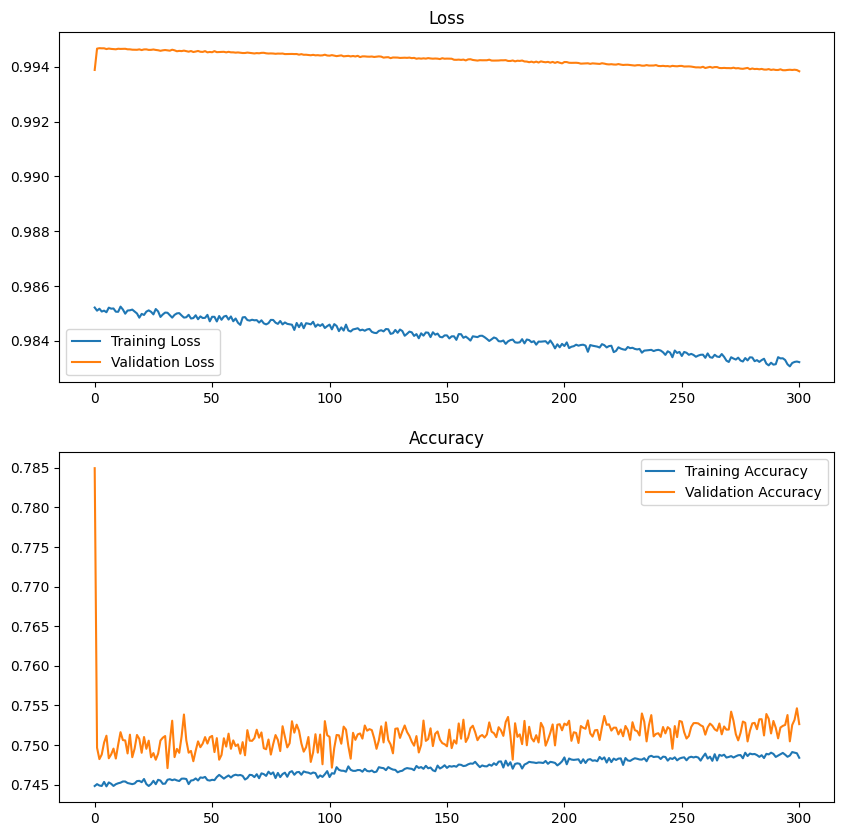

Validation Metrics: {'TPR': 0.22213764488697052, 'Accuracy': 0.7849633693695068, 'Dice': 0.006354582030326128, 'Loss': 0.9938902854919434}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.24592794477939606, 'Accuracy': 0.7871638536453247, 'Dice': 0.01836630099398248, 'Loss': 0.9840687057551216}


------------------------------------------------------------------------------------------------------------------
Model 3 training complete.


------------------------------------------------------------------------------------------------------------------


In [34]:
for i, (model, loss_fn, optimizer) in enumerate(zip(models, loss_functions, optimizers)):
    optimizer.zero_grad()
    print("------------------------------------------------------------------------------------------------------------------")
    print(f"Training Model {i+1} with {loss_fn.__class__.__name__}")
    if i == 2:
        patience = 300
    model = train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs, patience, l1_lambda)
    final_trained_model.append(model)
    print(f"Model {i+1} training complete.\n\n")
    print("------------------------------------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------------------------------


Model 1 Metrics:


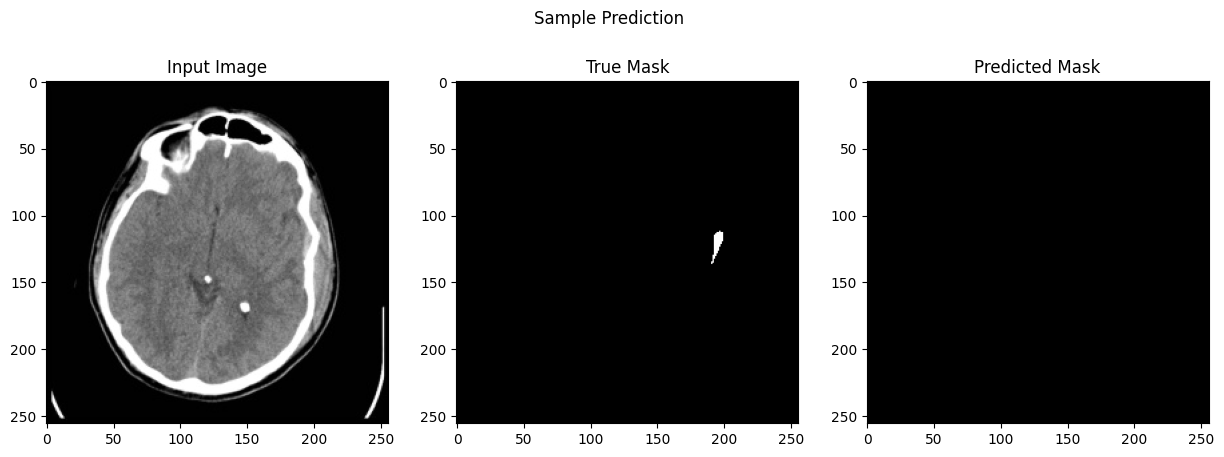

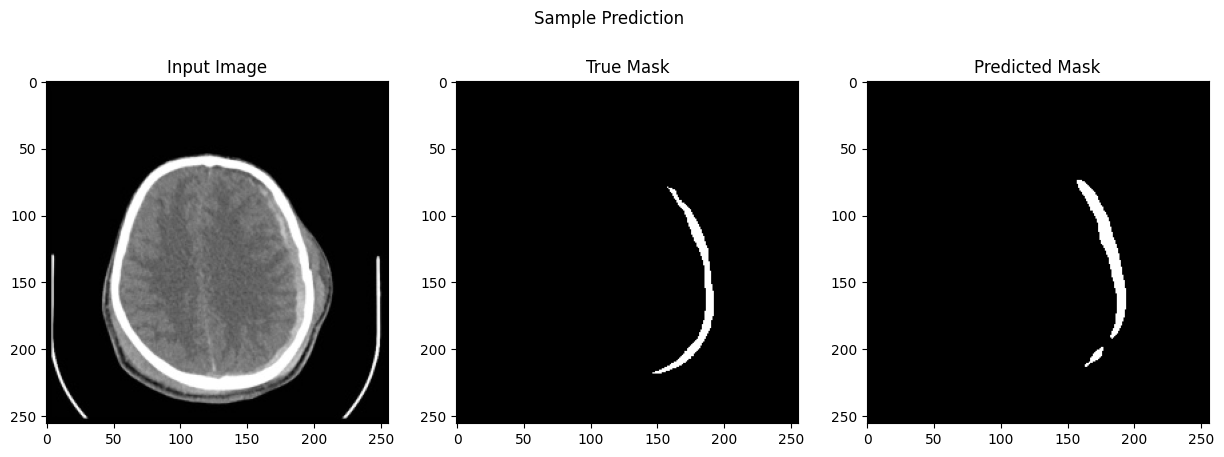

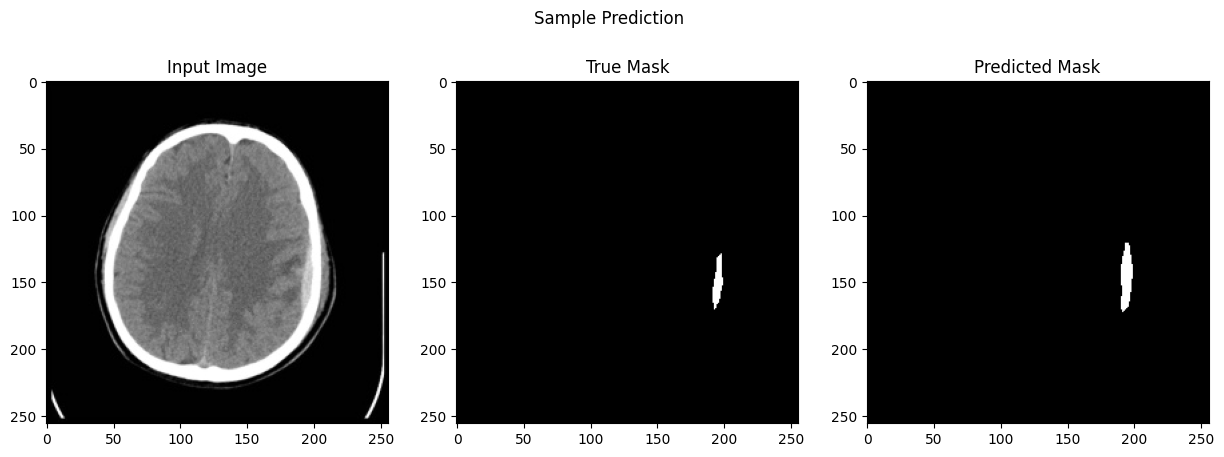

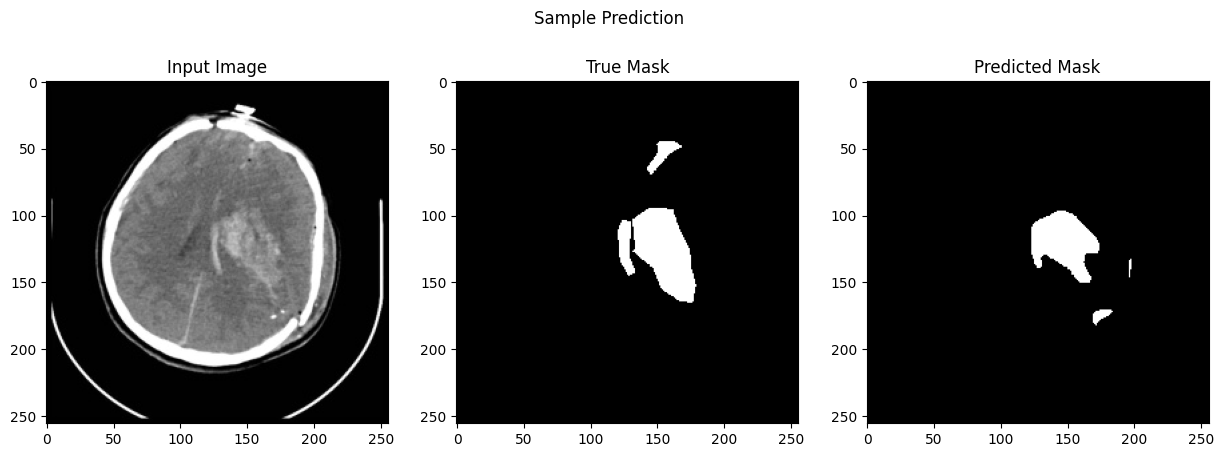

{'TPR': 0.5953035354614258, 'Accuracy': 0.993255615234375, 'Dice': 0.5251246988773346, 'Loss': 0.3406917452812195}
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------


Model 2 Metrics:


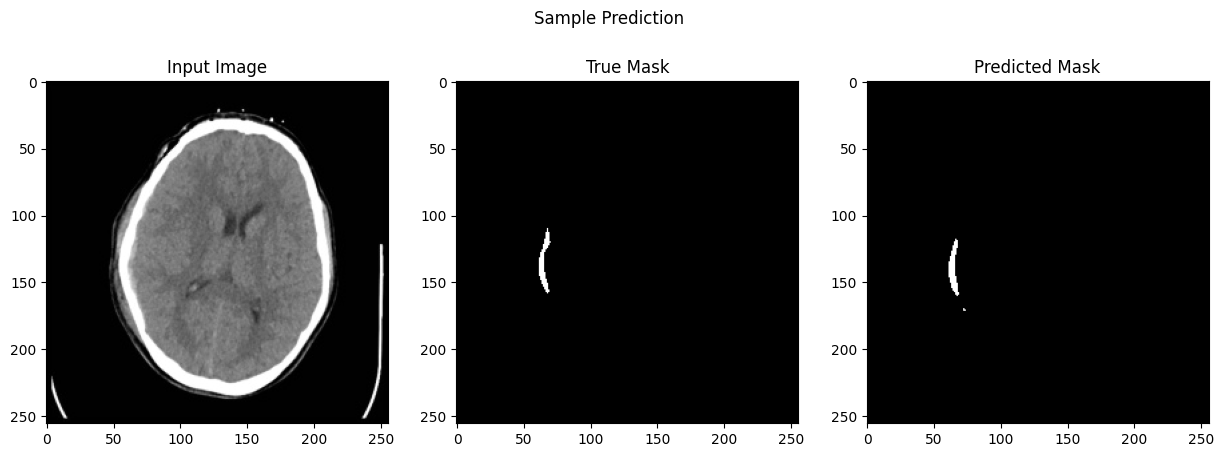

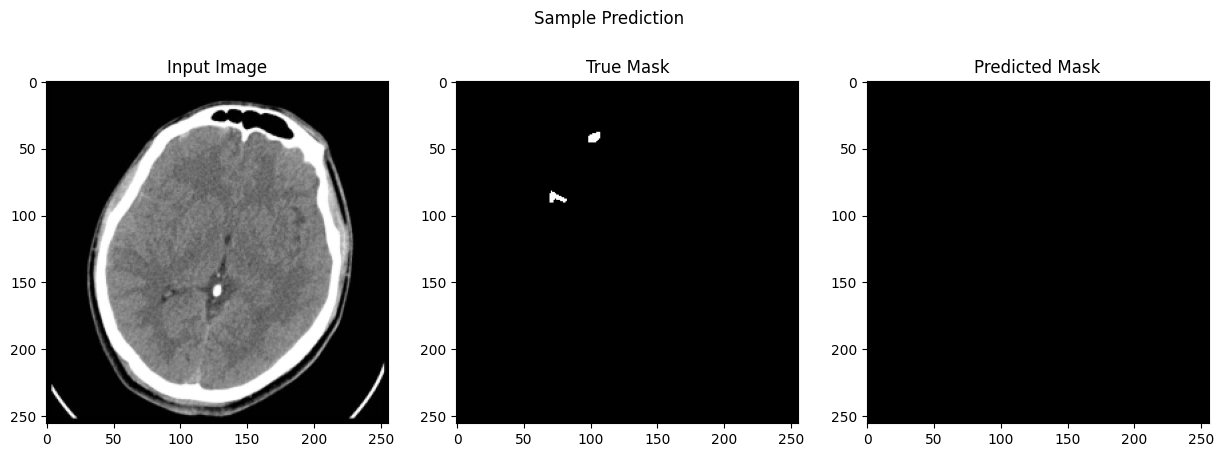

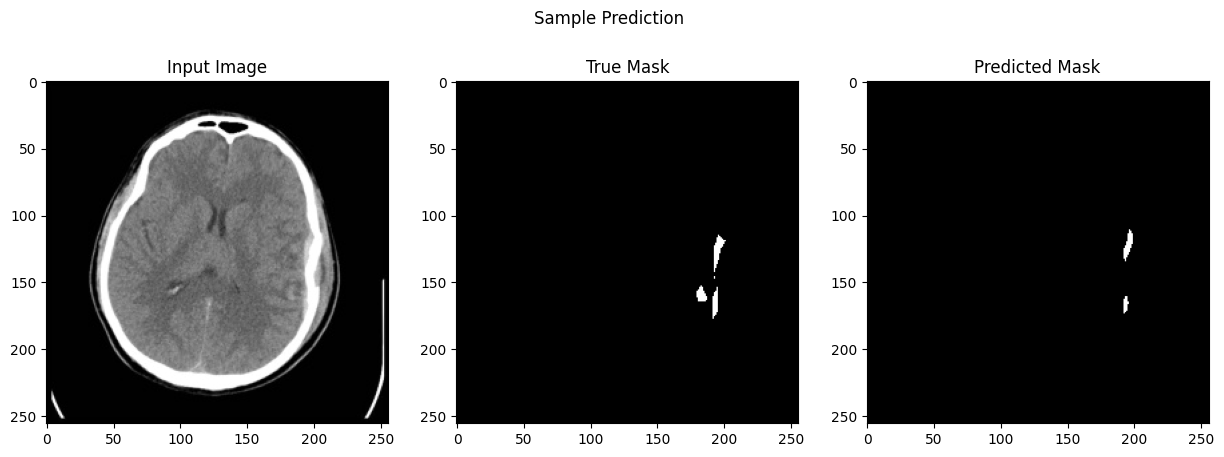

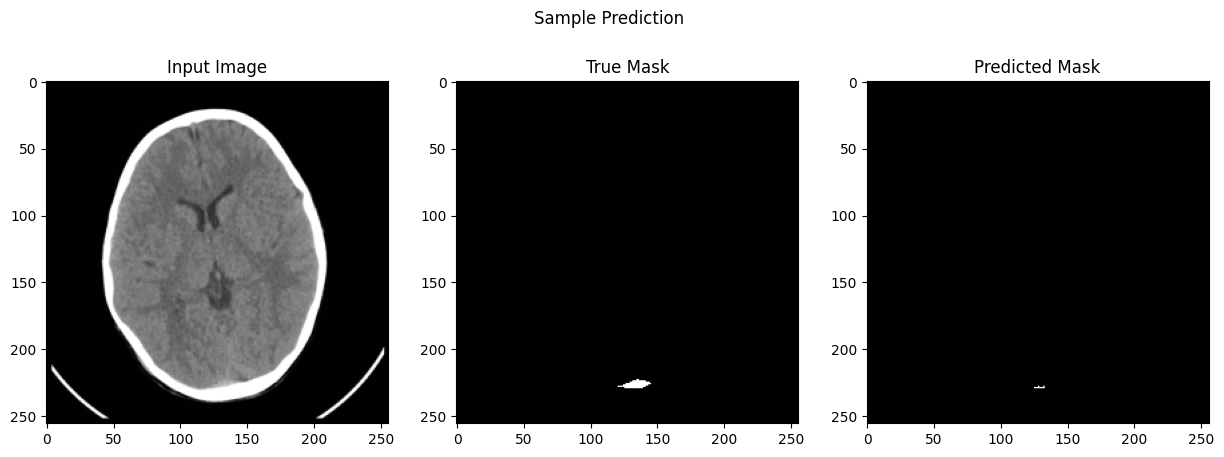

{'TPR': 0.4579227566719055, 'Accuracy': 0.9918391704559326, 'Dice': 0.4641375094652176, 'Loss': 0.4387165755033493}
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------


Model 3 Metrics:


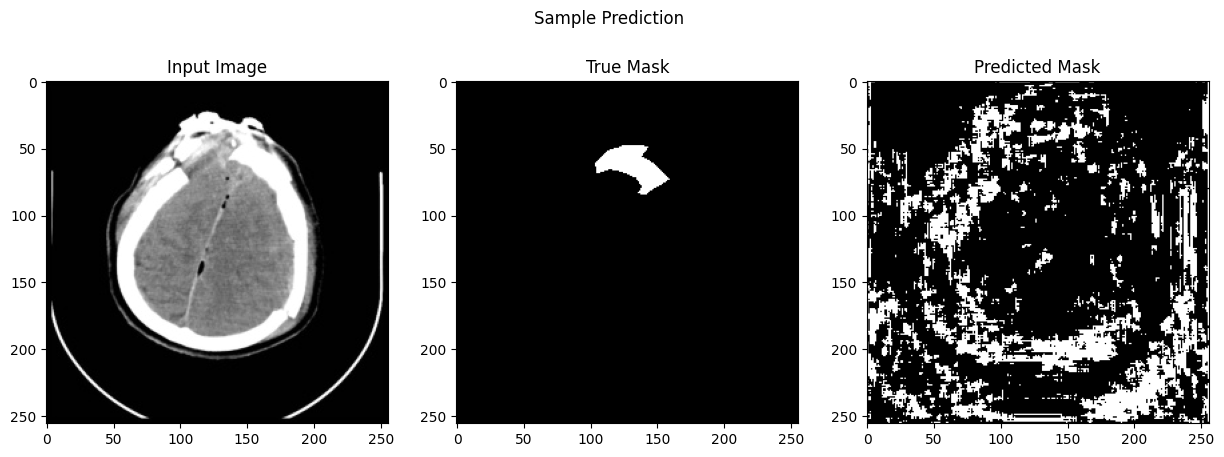

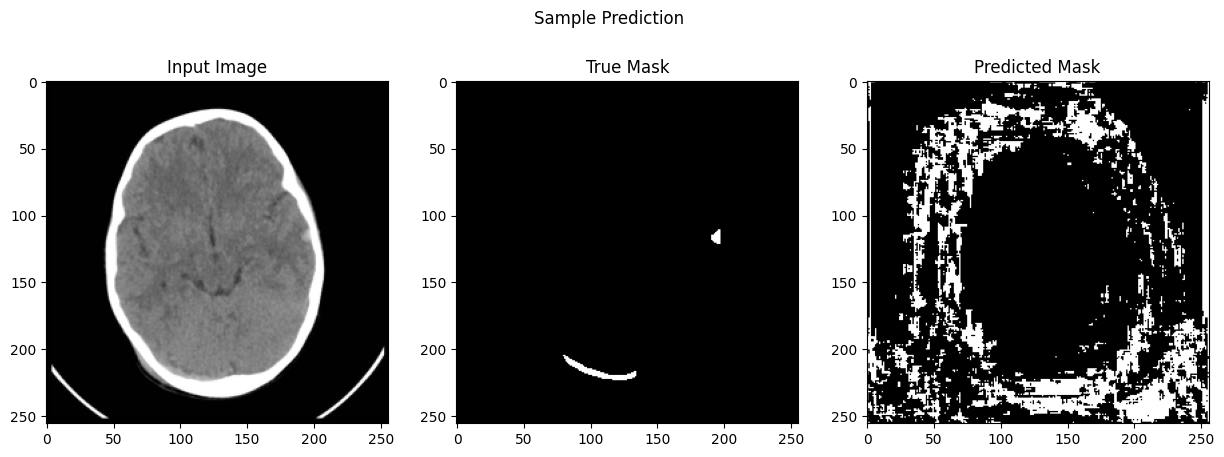

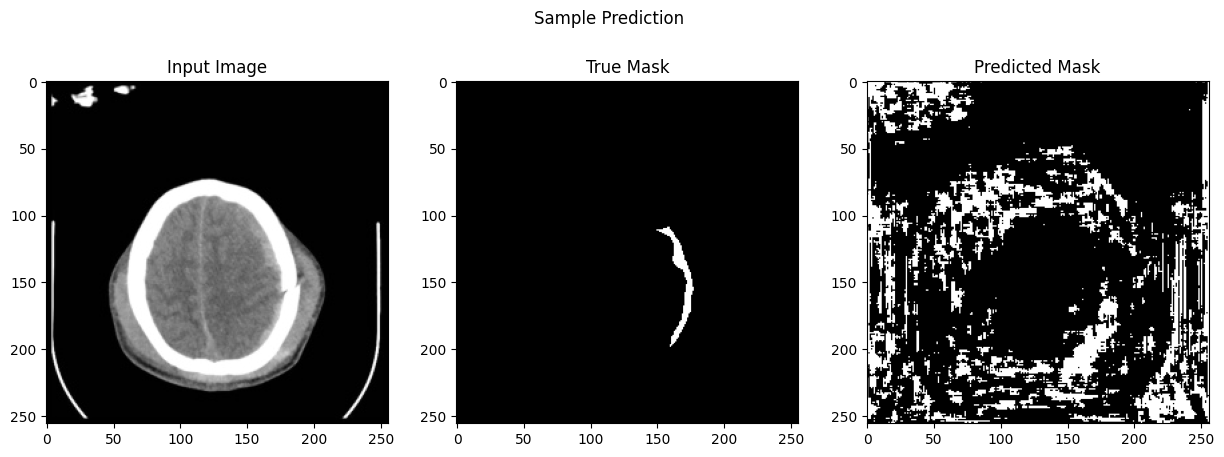

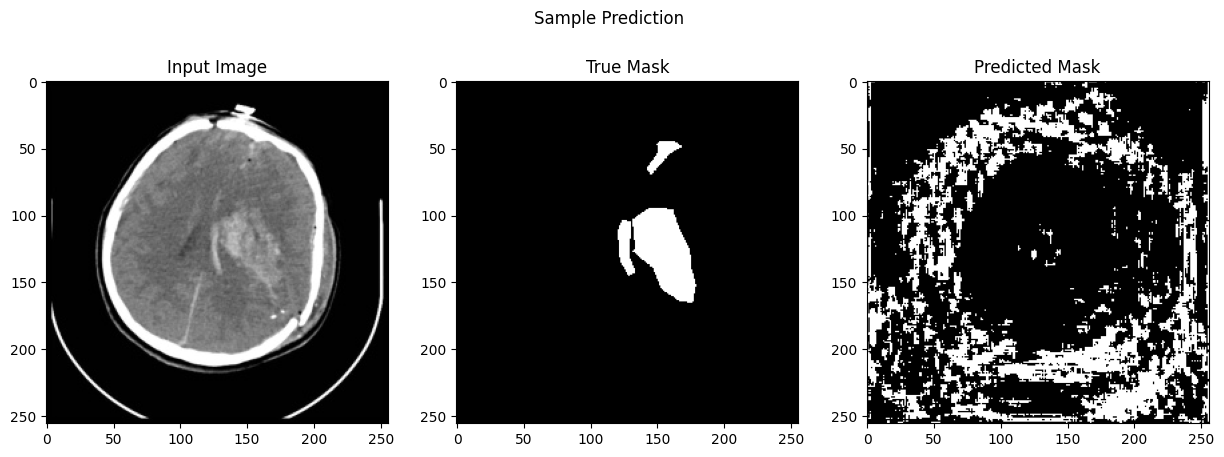

{'TPR': 0.12499450147151947, 'Accuracy': 0.7759914398193359, 'Dice': 0.010722756385803223, 'Loss': 0.9819437712430954}
---------------------------------------------------------------------------------------------------------------




In [35]:
for i,model in enumerate(final_trained_model):
    print("---------------------------------------------------------------------------------------------------------------\n\n")
    print(f"Model {i+1} Metrics:")
    test_metrics = calculate_metrics(model, test_loader, loss_functions[i], True, device)
    print(test_metrics)
    print("---------------------------------------------------------------------------------------------------------------\n\n")

### c (different regularization techniques)

In [36]:
# load the dataset
dataset1 = "/kaggle/input/aimiassigmnet2/Dataset1"

train_files_dir = os.path.join(dataset1, "TrainFiles")
train_mask_dir = os.path.join(dataset1, "TrainMask")
val_files_dir = os.path.join(dataset1, "ValFiles")
val_mask_dir = os.path.join(dataset1, "ValMask")
test_files_dir = os.path.join(dataset1, "TestFiles")
test_mask_dir = os.path.join(dataset1, "TestMask")

train_dataset_tensor, train_mask_tensor = file_to_tensor(train_files_dir, train_mask_dir, augment=False, num_aug= 3)
val_dataset_tensor, val_mask_tensor = file_to_tensor(val_files_dir, val_mask_dir, augment=False)
test_dataset_tensor, test_mask_tensor = file_to_tensor(test_files_dir, test_mask_dir, augment=False)

print(train_dataset_tensor.shape, train_mask_tensor.shape)
print(val_dataset_tensor.shape, val_mask_tensor.shape)
print(test_dataset_tensor.shape, test_mask_tensor.shape)

torch.Size([202, 1, 256, 256]) torch.Size([202, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])
torch.Size([50, 1, 256, 256]) torch.Size([50, 1, 256, 256])


In [37]:
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_dataset_tensor, train_mask_tensor)
val_dataset = TensorDataset(val_dataset_tensor, val_mask_tensor)
test_dataset = TensorDataset(test_dataset_tensor, test_mask_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [38]:
# L2 regularization

model = basicCNN()
#model = UNetResNet50Grayscale()

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.05) # L2 regularization
loss_function = smp.losses.DiceLoss("binary")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 1000
patience = 30
l1_lambda = 0.0

Epoch 1/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
All predictions are 0 or 1, cannot calculate metrics
No valid samples to calculate metrics


/tmp/ipykernel_30/2137310240.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.9660, Train Accuracy: 0.7231, Val Loss: 0.9833, Val Accuracy: 0.6738
fist save with Validation loss --> 0.983262).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.9461, Train Accuracy: 0.7755, Val Loss: 0.9749, Val Accuracy: 0.8192
Validation loss decreased (0.983262 --> 0.974863).  Saving model ...


Epoch 4/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.9336, Train Accuracy: 0.8403, Val Loss: 0.9698, Val Accuracy: 0.8852
Validation loss decreased (0.974863 --> 0.969772).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.9174, Train Accuracy: 0.8813, Val Loss: 0.9618, Val Accuracy: 0.9182
Validation loss decreased (0.969772 --> 0.961778).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.9029, Train Accuracy: 0.9062, Val Loss: 0.9560, Val Accuracy: 0.9430
Validation loss decreased (0.961778 --> 0.955990).  Saving model ...


Epoch 7/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.8808, Train Accuracy: 0.9293, Val Loss: 0.9558, Val Accuracy: 0.9523
EarlyStopping counter: 1 out of 30


Epoch 8/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.8573, Train Accuracy: 0.9461, Val Loss: 0.9478, Val Accuracy: 0.9676
Validation loss decreased (0.955990 --> 0.947817).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.8270, Train Accuracy: 0.9653, Val Loss: 0.9491, Val Accuracy: 0.9717
EarlyStopping counter: 1 out of 30


Epoch 10/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.7696, Train Accuracy: 0.9773, Val Loss: 0.9381, Val Accuracy: 0.9734
Validation loss decreased (0.947817 --> 0.938083).  Saving model ...


Epoch 11/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.7309, Train Accuracy: 0.9808, Val Loss: 0.9666, Val Accuracy: 0.9928
EarlyStopping counter: 1 out of 30


Epoch 12/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.6752, Train Accuracy: 0.9869, Val Loss: 0.9454, Val Accuracy: 0.9914
EarlyStopping counter: 2 out of 30


Epoch 13/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.6142, Train Accuracy: 0.9909, Val Loss: 0.9833, Val Accuracy: 0.9964
EarlyStopping counter: 3 out of 30


Epoch 14/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.5599, Train Accuracy: 0.9925, Val Loss: 0.9485, Val Accuracy: 0.9938
EarlyStopping counter: 4 out of 30


Epoch 15/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.5400, Train Accuracy: 0.9931, Val Loss: 0.8383, Val Accuracy: 0.9951
Validation loss decreased (0.938083 --> 0.838333).  Saving model ...


Epoch 16/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.4777, Train Accuracy: 0.9945, Val Loss: 0.8195, Val Accuracy: 0.9962
Validation loss decreased (0.838333 --> 0.819519).  Saving model ...


Epoch 17/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

All predictions are 0 or 1, cannot calculate metrics
Epoch [17/1000], Train Loss: 0.4249, Train Accuracy: 0.9953, Val Loss: 0.7867, Val Accuracy: 0.9968
Validation loss decreased (0.819519 --> 0.786712).  Saving model ...


Epoch 18/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.3982, Train Accuracy: 0.9954, Val Loss: 0.8925, Val Accuracy: 0.9950
EarlyStopping counter: 1 out of 30


Epoch 19/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.3673, Train Accuracy: 0.9958, Val Loss: 0.7727, Val Accuracy: 0.9939
Validation loss decreased (0.786712 --> 0.772728).  Saving model ...


Epoch 20/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.3620, Train Accuracy: 0.9958, Val Loss: 0.8409, Val Accuracy: 0.9954
EarlyStopping counter: 1 out of 30


Epoch 21/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.3473, Train Accuracy: 0.9960, Val Loss: 0.7739, Val Accuracy: 0.9956
EarlyStopping counter: 2 out of 30


Epoch 22/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.3449, Train Accuracy: 0.9961, Val Loss: 0.8395, Val Accuracy: 0.9939
EarlyStopping counter: 3 out of 30


Epoch 23/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.3222, Train Accuracy: 0.9961, Val Loss: 0.9094, Val Accuracy: 0.9962
EarlyStopping counter: 4 out of 30


Epoch 24/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.3475, Train Accuracy: 0.9959, Val Loss: 0.6858, Val Accuracy: 0.9926
Validation loss decreased (0.772728 --> 0.685833).  Saving model ...


Epoch 25/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.3278, Train Accuracy: 0.9960, Val Loss: 0.7685, Val Accuracy: 0.9947
EarlyStopping counter: 1 out of 30


Epoch 26/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.2966, Train Accuracy: 0.9964, Val Loss: 0.6913, Val Accuracy: 0.9953
EarlyStopping counter: 2 out of 30


Epoch 27/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.2734, Train Accuracy: 0.9965, Val Loss: 0.7823, Val Accuracy: 0.9955
EarlyStopping counter: 3 out of 30


Epoch 28/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.2587, Train Accuracy: 0.9968, Val Loss: 0.6862, Val Accuracy: 0.9959
EarlyStopping counter: 4 out of 30


Epoch 29/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.2599, Train Accuracy: 0.9969, Val Loss: 0.6652, Val Accuracy: 0.9968
Validation loss decreased (0.685833 --> 0.665217).  Saving model ...


Epoch 30/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.2803, Train Accuracy: 0.9967, Val Loss: 0.6517, Val Accuracy: 0.9948
Validation loss decreased (0.665217 --> 0.651695).  Saving model ...


Epoch 31/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.2631, Train Accuracy: 0.9968, Val Loss: 0.7383, Val Accuracy: 0.9952
EarlyStopping counter: 1 out of 30


Epoch 32/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.2403, Train Accuracy: 0.9970, Val Loss: 0.7305, Val Accuracy: 0.9957
EarlyStopping counter: 2 out of 30


Epoch 33/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.2310, Train Accuracy: 0.9971, Val Loss: 0.6111, Val Accuracy: 0.9958
Validation loss decreased (0.651695 --> 0.611056).  Saving model ...


Epoch 34/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.2078, Train Accuracy: 0.9974, Val Loss: 0.7461, Val Accuracy: 0.9957
EarlyStopping counter: 1 out of 30


Epoch 35/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.2037, Train Accuracy: 0.9974, Val Loss: 0.5956, Val Accuracy: 0.9958
Validation loss decreased (0.611056 --> 0.595590).  Saving model ...


Epoch 36/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.2253, Train Accuracy: 0.9973, Val Loss: 0.6336, Val Accuracy: 0.9955
EarlyStopping counter: 1 out of 30


Epoch 37/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.2002, Train Accuracy: 0.9974, Val Loss: 0.6537, Val Accuracy: 0.9959
EarlyStopping counter: 2 out of 30


Epoch 38/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.2201, Train Accuracy: 0.9973, Val Loss: 0.6646, Val Accuracy: 0.9951
EarlyStopping counter: 3 out of 30


Epoch 39/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.2013, Train Accuracy: 0.9973, Val Loss: 0.6737, Val Accuracy: 0.9953
EarlyStopping counter: 4 out of 30


Epoch 40/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.2018, Train Accuracy: 0.9974, Val Loss: 0.6794, Val Accuracy: 0.9960
EarlyStopping counter: 5 out of 30


Epoch 41/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.1949, Train Accuracy: 0.9975, Val Loss: 0.5936, Val Accuracy: 0.9959
EarlyStopping counter: 6 out of 30


Epoch 42/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.1761, Train Accuracy: 0.9978, Val Loss: 0.5864, Val Accuracy: 0.9950
Validation loss decreased (0.595590 --> 0.586450).  Saving model ...


Epoch 43/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.1752, Train Accuracy: 0.9977, Val Loss: 0.5576, Val Accuracy: 0.9958
Validation loss decreased (0.586450 --> 0.557633).  Saving model ...


Epoch 44/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.1767, Train Accuracy: 0.9977, Val Loss: 0.5753, Val Accuracy: 0.9962
EarlyStopping counter: 1 out of 30


Epoch 45/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.2110, Train Accuracy: 0.9972, Val Loss: 0.5964, Val Accuracy: 0.9966
EarlyStopping counter: 2 out of 30


Epoch 46/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.2379, Train Accuracy: 0.9970, Val Loss: 0.6743, Val Accuracy: 0.9930
EarlyStopping counter: 3 out of 30


Epoch 47/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.2179, Train Accuracy: 0.9972, Val Loss: 0.6318, Val Accuracy: 0.9949
EarlyStopping counter: 4 out of 30


Epoch 48/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.2115, Train Accuracy: 0.9973, Val Loss: 0.7034, Val Accuracy: 0.9953
EarlyStopping counter: 5 out of 30


Epoch 49/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.2141, Train Accuracy: 0.9974, Val Loss: 0.6733, Val Accuracy: 0.9948
EarlyStopping counter: 6 out of 30


Epoch 50/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.2193, Train Accuracy: 0.9973, Val Loss: 0.6045, Val Accuracy: 0.9952
EarlyStopping counter: 7 out of 30


Epoch 51/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.1999, Train Accuracy: 0.9975, Val Loss: 0.5234, Val Accuracy: 0.9968
Validation loss decreased (0.557633 --> 0.523364).  Saving model ...


Epoch 52/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.1817, Train Accuracy: 0.9976, Val Loss: 0.6586, Val Accuracy: 0.9955
EarlyStopping counter: 1 out of 30


Epoch 53/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.1556, Train Accuracy: 0.9979, Val Loss: 0.6475, Val Accuracy: 0.9952
EarlyStopping counter: 2 out of 30


Epoch 54/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.1506, Train Accuracy: 0.9980, Val Loss: 0.6350, Val Accuracy: 0.9959
EarlyStopping counter: 3 out of 30


Epoch 55/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.1420, Train Accuracy: 0.9981, Val Loss: 0.5684, Val Accuracy: 0.9957
EarlyStopping counter: 4 out of 30


Epoch 56/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.1724, Train Accuracy: 0.9977, Val Loss: 0.7269, Val Accuracy: 0.9960
EarlyStopping counter: 5 out of 30


Epoch 57/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.1571, Train Accuracy: 0.9979, Val Loss: 0.5796, Val Accuracy: 0.9959
EarlyStopping counter: 6 out of 30


Epoch 58/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.1603, Train Accuracy: 0.9980, Val Loss: 0.5648, Val Accuracy: 0.9957
EarlyStopping counter: 7 out of 30


Epoch 59/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/1000], Train Loss: 0.1437, Train Accuracy: 0.9981, Val Loss: 0.5868, Val Accuracy: 0.9960
EarlyStopping counter: 8 out of 30


Epoch 60/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60/1000], Train Loss: 0.1458, Train Accuracy: 0.9981, Val Loss: 0.6453, Val Accuracy: 0.9960
EarlyStopping counter: 9 out of 30


Epoch 61/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61/1000], Train Loss: 0.1449, Train Accuracy: 0.9982, Val Loss: 0.6163, Val Accuracy: 0.9958
EarlyStopping counter: 10 out of 30


Epoch 62/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62/1000], Train Loss: 0.1358, Train Accuracy: 0.9982, Val Loss: 0.6219, Val Accuracy: 0.9959
EarlyStopping counter: 11 out of 30


Epoch 63/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63/1000], Train Loss: 0.1284, Train Accuracy: 0.9984, Val Loss: 0.6199, Val Accuracy: 0.9952
EarlyStopping counter: 12 out of 30


Epoch 64/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64/1000], Train Loss: 0.1235, Train Accuracy: 0.9984, Val Loss: 0.6406, Val Accuracy: 0.9955
EarlyStopping counter: 13 out of 30


Epoch 65/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65/1000], Train Loss: 0.1212, Train Accuracy: 0.9985, Val Loss: 0.5685, Val Accuracy: 0.9960
EarlyStopping counter: 14 out of 30


Epoch 66/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66/1000], Train Loss: 0.1213, Train Accuracy: 0.9985, Val Loss: 0.5745, Val Accuracy: 0.9961
EarlyStopping counter: 15 out of 30


Epoch 67/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67/1000], Train Loss: 0.1184, Train Accuracy: 0.9985, Val Loss: 0.6569, Val Accuracy: 0.9958
EarlyStopping counter: 16 out of 30


Epoch 68/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68/1000], Train Loss: 0.1246, Train Accuracy: 0.9985, Val Loss: 0.6471, Val Accuracy: 0.9963
EarlyStopping counter: 17 out of 30


Epoch 69/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69/1000], Train Loss: 0.1321, Train Accuracy: 0.9984, Val Loss: 0.5794, Val Accuracy: 0.9955
EarlyStopping counter: 18 out of 30


Epoch 70/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70/1000], Train Loss: 0.1361, Train Accuracy: 0.9983, Val Loss: 0.5591, Val Accuracy: 0.9962
EarlyStopping counter: 19 out of 30


Epoch 71/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71/1000], Train Loss: 0.1317, Train Accuracy: 0.9984, Val Loss: 0.6181, Val Accuracy: 0.9959
EarlyStopping counter: 20 out of 30


Epoch 72/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72/1000], Train Loss: 0.1343, Train Accuracy: 0.9983, Val Loss: 0.7058, Val Accuracy: 0.9954
EarlyStopping counter: 21 out of 30


Epoch 73/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73/1000], Train Loss: 0.1289, Train Accuracy: 0.9984, Val Loss: 0.6174, Val Accuracy: 0.9955
EarlyStopping counter: 22 out of 30


Epoch 74/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74/1000], Train Loss: 0.1262, Train Accuracy: 0.9984, Val Loss: 0.5763, Val Accuracy: 0.9957
EarlyStopping counter: 23 out of 30


Epoch 75/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75/1000], Train Loss: 0.1212, Train Accuracy: 0.9984, Val Loss: 0.6574, Val Accuracy: 0.9961
EarlyStopping counter: 24 out of 30


Epoch 76/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76/1000], Train Loss: 0.1184, Train Accuracy: 0.9985, Val Loss: 0.5524, Val Accuracy: 0.9959
EarlyStopping counter: 25 out of 30


Epoch 77/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77/1000], Train Loss: 0.1201, Train Accuracy: 0.9984, Val Loss: 0.6930, Val Accuracy: 0.9958
EarlyStopping counter: 26 out of 30


Epoch 78/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78/1000], Train Loss: 0.1038, Train Accuracy: 0.9987, Val Loss: 0.5458, Val Accuracy: 0.9959
EarlyStopping counter: 27 out of 30


Epoch 79/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79/1000], Train Loss: 0.1073, Train Accuracy: 0.9986, Val Loss: 0.5225, Val Accuracy: 0.9969
EarlyStopping counter: 28 out of 30


Epoch 80/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80/1000], Train Loss: 0.1359, Train Accuracy: 0.9983, Val Loss: 0.5739, Val Accuracy: 0.9953
EarlyStopping counter: 29 out of 30


Epoch 81/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81/1000], Train Loss: 0.1399, Train Accuracy: 0.9982, Val Loss: 0.6070, Val Accuracy: 0.9958
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2137310240.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


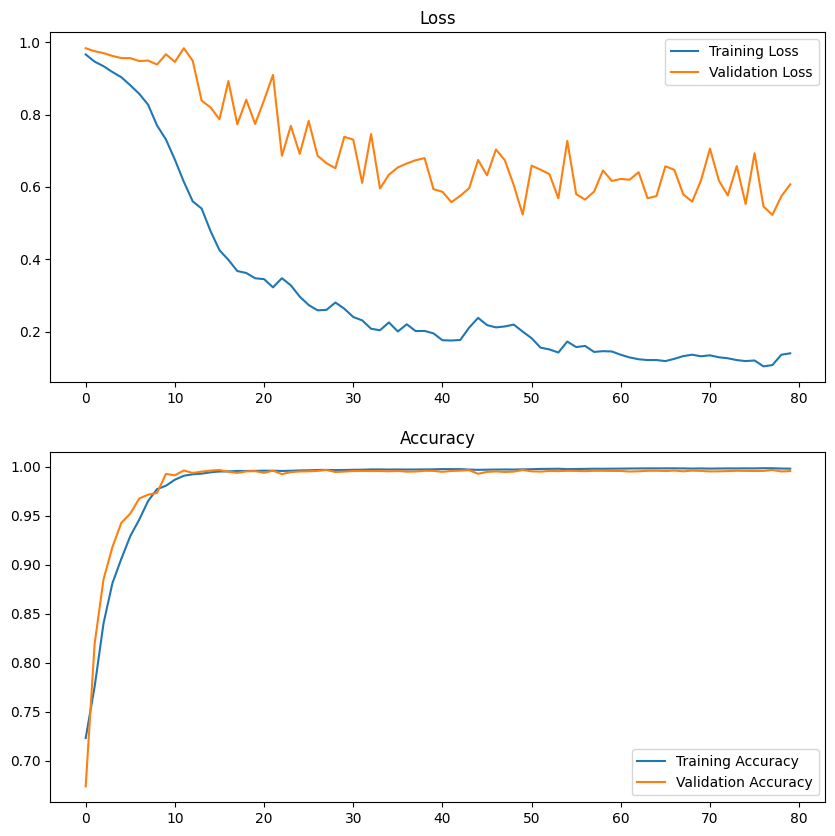

Validation Metrics: {'TPR': 0.5099161863327026, 'Accuracy': 0.9968433380126953, 'Dice': 0.36174820363521576, 'Loss': 0.5233641564846039}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.8382713198661804, 'Accuracy': 0.997495710849762, 'Dice': 0.6550759627268865, 'Loss': 0.19391621534640974}


------------------------------------------------------------------------------------------------------------------


In [39]:
model = train_model(model, train_loader, val_loader, loss_function, optimizer, device, num_epochs, patience, l1_lambda)

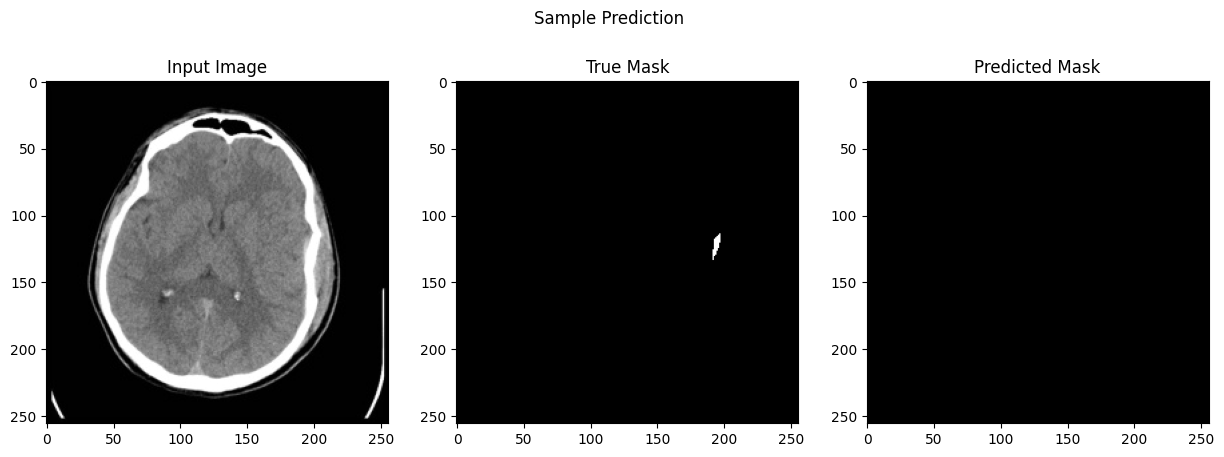

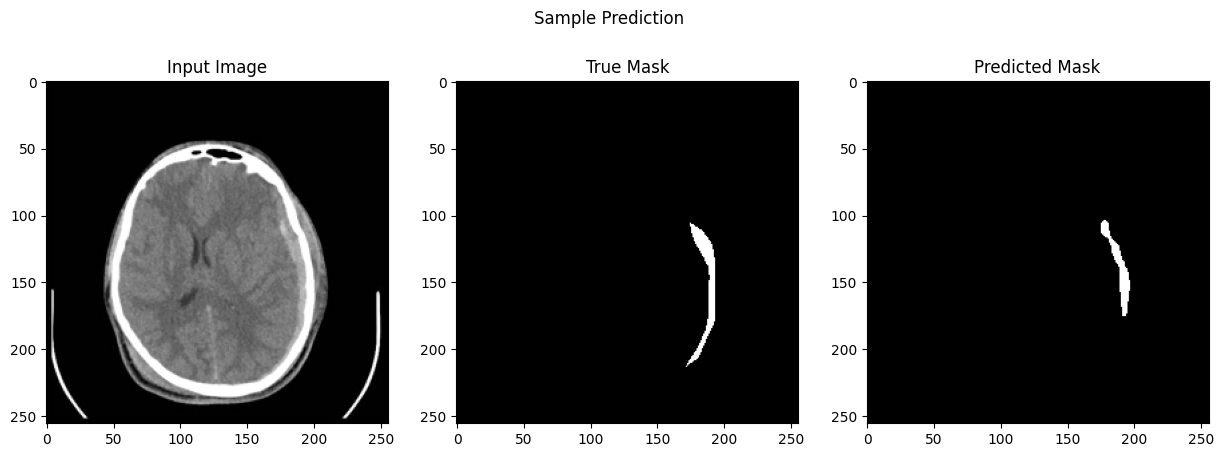

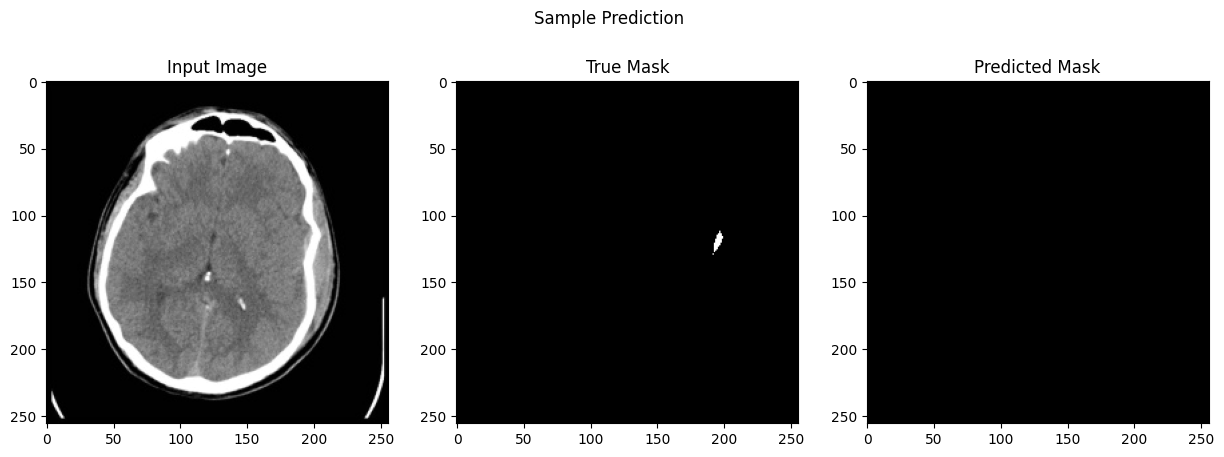

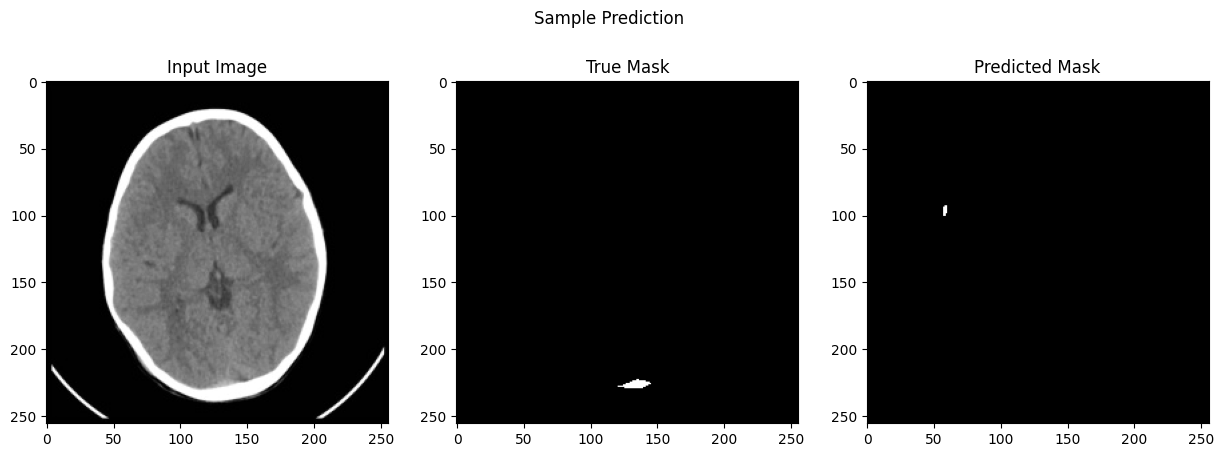

{'TPR': 0.30759531259536743,
 'Accuracy': 0.9900832176208496,
 'Dice': 0.31805073469877243,
 'Loss': 0.6137718111276627}

In [41]:
calculate_metrics(model, test_loader, loss_function, True, device)

In [45]:
# L1 regularization

model = basicCNN()
#model = UNetResNet50Grayscale()

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.005)
loss_function = smp.losses.DiceLoss("binary")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 1000
patience = 30
l1_lambda = 0.0001 # L1 regularization

Epoch 1/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 2.2769, Train Accuracy: 0.5350, Val Loss: 0.9925, Val Accuracy: 0.9849
fist save with Validation loss --> 0.992472).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 2.1812, Train Accuracy: 0.7274, Val Loss: 0.9861, Val Accuracy: 0.9471
Validation loss decreased (0.992472 --> 0.986087).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 2.0843, Train Accuracy: 0.8147, Val Loss: 0.9708, Val Accuracy: 0.8876
Validation loss decreased (0.986087 --> 0.970785).  Saving model ...


Epoch 4/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 1.9855, Train Accuracy: 0.8817, Val Loss: 0.9617, Val Accuracy: 0.9277
Validation loss decreased (0.970785 --> 0.961684).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 1.8993, Train Accuracy: 0.9227, Val Loss: 0.9481, Val Accuracy: 0.9616
Validation loss decreased (0.961684 --> 0.948118).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 1.8113, Train Accuracy: 0.9461, Val Loss: 0.9476, Val Accuracy: 0.9616
EarlyStopping counter: 1 out of 30


Epoch 7/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 1.7440, Train Accuracy: 0.9617, Val Loss: 0.9624, Val Accuracy: 0.9766
EarlyStopping counter: 2 out of 30


Epoch 8/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 1.6664, Train Accuracy: 0.9709, Val Loss: 0.9321, Val Accuracy: 0.9748
Validation loss decreased (0.948118 --> 0.932131).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 1.6145, Train Accuracy: 0.9731, Val Loss: 0.9846, Val Accuracy: 0.9863
EarlyStopping counter: 1 out of 30


Epoch 10/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 1.5604, Train Accuracy: 0.9802, Val Loss: 0.9407, Val Accuracy: 0.9797
EarlyStopping counter: 2 out of 30


Epoch 11/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 1.4903, Train Accuracy: 0.9845, Val Loss: 0.9541, Val Accuracy: 0.9886
EarlyStopping counter: 3 out of 30


Epoch 12/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 1.4249, Train Accuracy: 0.9866, Val Loss: 0.9745, Val Accuracy: 0.9917
EarlyStopping counter: 4 out of 30


Epoch 13/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 1.3789, Train Accuracy: 0.9884, Val Loss: 0.9580, Val Accuracy: 0.9869
EarlyStopping counter: 5 out of 30


Epoch 14/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 1.3145, Train Accuracy: 0.9905, Val Loss: 0.9015, Val Accuracy: 0.9908
Validation loss decreased (0.932131 --> 0.901534).  Saving model ...


Epoch 15/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 1.3121, Train Accuracy: 0.9902, Val Loss: 0.8978, Val Accuracy: 0.9926
EarlyStopping counter: 1 out of 30


Epoch 16/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 1.2319, Train Accuracy: 0.9918, Val Loss: 0.9483, Val Accuracy: 0.9953
EarlyStopping counter: 2 out of 30


Epoch 17/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 1.1536, Train Accuracy: 0.9944, Val Loss: 0.7995, Val Accuracy: 0.9939
Validation loss decreased (0.901534 --> 0.799531).  Saving model ...


Epoch 18/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 1.1108, Train Accuracy: 0.9951, Val Loss: 0.7740, Val Accuracy: 0.9930
Validation loss decreased (0.799531 --> 0.773958).  Saving model ...


Epoch 19/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 1.1272, Train Accuracy: 0.9937, Val Loss: 0.8008, Val Accuracy: 0.9950
EarlyStopping counter: 1 out of 30


Epoch 20/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 1.0374, Train Accuracy: 0.9956, Val Loss: 0.7869, Val Accuracy: 0.9951
EarlyStopping counter: 2 out of 30


Epoch 21/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.9917, Train Accuracy: 0.9962, Val Loss: 0.8061, Val Accuracy: 0.9953
EarlyStopping counter: 3 out of 30


Epoch 22/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.9820, Train Accuracy: 0.9959, Val Loss: 0.6791, Val Accuracy: 0.9937
Validation loss decreased (0.773958 --> 0.679104).  Saving model ...


Epoch 23/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.9695, Train Accuracy: 0.9959, Val Loss: 0.8815, Val Accuracy: 0.9959
EarlyStopping counter: 1 out of 30


Epoch 24/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.9697, Train Accuracy: 0.9961, Val Loss: 0.6661, Val Accuracy: 0.9949
Validation loss decreased (0.679104 --> 0.666133).  Saving model ...


Epoch 25/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.9475, Train Accuracy: 0.9959, Val Loss: 0.9458, Val Accuracy: 0.9922
EarlyStopping counter: 1 out of 30


Epoch 26/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.8976, Train Accuracy: 0.9966, Val Loss: 0.8167, Val Accuracy: 0.9955
EarlyStopping counter: 2 out of 30


Epoch 27/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.8583, Train Accuracy: 0.9969, Val Loss: 0.6379, Val Accuracy: 0.9958
Validation loss decreased (0.666133 --> 0.637914).  Saving model ...


Epoch 28/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.8850, Train Accuracy: 0.9965, Val Loss: 0.6539, Val Accuracy: 0.9955
EarlyStopping counter: 1 out of 30


Epoch 29/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.8242, Train Accuracy: 0.9972, Val Loss: 0.6756, Val Accuracy: 0.9966
EarlyStopping counter: 2 out of 30


Epoch 30/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.8225, Train Accuracy: 0.9971, Val Loss: 0.6416, Val Accuracy: 0.9958
EarlyStopping counter: 3 out of 30


Epoch 31/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.8217, Train Accuracy: 0.9970, Val Loss: 0.6760, Val Accuracy: 0.9956
EarlyStopping counter: 4 out of 30


Epoch 32/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.8083, Train Accuracy: 0.9971, Val Loss: 0.7232, Val Accuracy: 0.9962
EarlyStopping counter: 5 out of 30


Epoch 33/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.7982, Train Accuracy: 0.9971, Val Loss: 0.7767, Val Accuracy: 0.9955
EarlyStopping counter: 6 out of 30


Epoch 34/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.7837, Train Accuracy: 0.9971, Val Loss: 0.6844, Val Accuracy: 0.9956
EarlyStopping counter: 7 out of 30


Epoch 35/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.7558, Train Accuracy: 0.9975, Val Loss: 0.6789, Val Accuracy: 0.9959
EarlyStopping counter: 8 out of 30


Epoch 36/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.7425, Train Accuracy: 0.9976, Val Loss: 0.6692, Val Accuracy: 0.9960
EarlyStopping counter: 9 out of 30


Epoch 37/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.7353, Train Accuracy: 0.9976, Val Loss: 0.7168, Val Accuracy: 0.9963
EarlyStopping counter: 10 out of 30


Epoch 38/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.7396, Train Accuracy: 0.9975, Val Loss: 0.6792, Val Accuracy: 0.9945
EarlyStopping counter: 11 out of 30


Epoch 39/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.7436, Train Accuracy: 0.9973, Val Loss: 0.6266, Val Accuracy: 0.9962
Validation loss decreased (0.637914 --> 0.626562).  Saving model ...


Epoch 40/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.7302, Train Accuracy: 0.9975, Val Loss: 0.8825, Val Accuracy: 0.9962
EarlyStopping counter: 1 out of 30


Epoch 41/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.7303, Train Accuracy: 0.9974, Val Loss: 0.6321, Val Accuracy: 0.9948
EarlyStopping counter: 2 out of 30


Epoch 42/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.7082, Train Accuracy: 0.9976, Val Loss: 0.6115, Val Accuracy: 0.9957
Validation loss decreased (0.626562 --> 0.611545).  Saving model ...


Epoch 43/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.7099, Train Accuracy: 0.9975, Val Loss: 0.6192, Val Accuracy: 0.9958
EarlyStopping counter: 1 out of 30


Epoch 44/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.7114, Train Accuracy: 0.9975, Val Loss: 0.6702, Val Accuracy: 0.9953
EarlyStopping counter: 2 out of 30


Epoch 45/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.7265, Train Accuracy: 0.9976, Val Loss: 0.7295, Val Accuracy: 0.9954
EarlyStopping counter: 3 out of 30


Epoch 46/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.7031, Train Accuracy: 0.9975, Val Loss: 0.6503, Val Accuracy: 0.9958
EarlyStopping counter: 4 out of 30


Epoch 47/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.6847, Train Accuracy: 0.9976, Val Loss: 0.6076, Val Accuracy: 0.9955
EarlyStopping counter: 5 out of 30


Epoch 48/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.6755, Train Accuracy: 0.9977, Val Loss: 0.6536, Val Accuracy: 0.9957
EarlyStopping counter: 6 out of 30


Epoch 49/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.6494, Train Accuracy: 0.9980, Val Loss: 0.6999, Val Accuracy: 0.9957
EarlyStopping counter: 7 out of 30


Epoch 50/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.6559, Train Accuracy: 0.9979, Val Loss: 0.8166, Val Accuracy: 0.9950
EarlyStopping counter: 8 out of 30


Epoch 51/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.6506, Train Accuracy: 0.9979, Val Loss: 0.7072, Val Accuracy: 0.9954
EarlyStopping counter: 9 out of 30


Epoch 52/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.6332, Train Accuracy: 0.9980, Val Loss: 0.6112, Val Accuracy: 0.9954
EarlyStopping counter: 10 out of 30


Epoch 53/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.6343, Train Accuracy: 0.9981, Val Loss: 0.6015, Val Accuracy: 0.9956
Validation loss decreased (0.611545 --> 0.601478).  Saving model ...


Epoch 54/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.6262, Train Accuracy: 0.9981, Val Loss: 0.6988, Val Accuracy: 0.9949
EarlyStopping counter: 1 out of 30


Epoch 55/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.6145, Train Accuracy: 0.9981, Val Loss: 0.6850, Val Accuracy: 0.9957
EarlyStopping counter: 2 out of 30


Epoch 56/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.6065, Train Accuracy: 0.9981, Val Loss: 0.6627, Val Accuracy: 0.9966
EarlyStopping counter: 3 out of 30


Epoch 57/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.6070, Train Accuracy: 0.9982, Val Loss: 0.6292, Val Accuracy: 0.9959
EarlyStopping counter: 4 out of 30


Epoch 58/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.5974, Train Accuracy: 0.9983, Val Loss: 0.6545, Val Accuracy: 0.9957
EarlyStopping counter: 5 out of 30


Epoch 59/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/1000], Train Loss: 0.5841, Train Accuracy: 0.9984, Val Loss: 0.6465, Val Accuracy: 0.9962
EarlyStopping counter: 6 out of 30


Epoch 60/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60/1000], Train Loss: 0.5848, Train Accuracy: 0.9983, Val Loss: 0.6644, Val Accuracy: 0.9959
EarlyStopping counter: 7 out of 30


Epoch 61/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61/1000], Train Loss: 0.5887, Train Accuracy: 0.9983, Val Loss: 0.6880, Val Accuracy: 0.9958
EarlyStopping counter: 8 out of 30


Epoch 62/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62/1000], Train Loss: 0.5770, Train Accuracy: 0.9983, Val Loss: 0.6210, Val Accuracy: 0.9964
EarlyStopping counter: 9 out of 30


Epoch 63/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63/1000], Train Loss: 0.5696, Train Accuracy: 0.9984, Val Loss: 0.5662, Val Accuracy: 0.9962
Validation loss decreased (0.601478 --> 0.566248).  Saving model ...


Epoch 64/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64/1000], Train Loss: 0.5809, Train Accuracy: 0.9982, Val Loss: 0.7376, Val Accuracy: 0.9958
EarlyStopping counter: 1 out of 30


Epoch 65/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65/1000], Train Loss: 0.5611, Train Accuracy: 0.9984, Val Loss: 0.5790, Val Accuracy: 0.9958
EarlyStopping counter: 2 out of 30


Epoch 66/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66/1000], Train Loss: 0.5570, Train Accuracy: 0.9984, Val Loss: 0.6688, Val Accuracy: 0.9958
EarlyStopping counter: 3 out of 30


Epoch 67/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67/1000], Train Loss: 0.5517, Train Accuracy: 0.9985, Val Loss: 0.6607, Val Accuracy: 0.9963
EarlyStopping counter: 4 out of 30


Epoch 68/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68/1000], Train Loss: 0.5497, Train Accuracy: 0.9985, Val Loss: 0.6169, Val Accuracy: 0.9956
EarlyStopping counter: 5 out of 30


Epoch 69/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69/1000], Train Loss: 0.5514, Train Accuracy: 0.9984, Val Loss: 0.5876, Val Accuracy: 0.9963
EarlyStopping counter: 6 out of 30


Epoch 70/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70/1000], Train Loss: 0.5383, Train Accuracy: 0.9985, Val Loss: 0.6468, Val Accuracy: 0.9961
EarlyStopping counter: 7 out of 30


Epoch 71/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71/1000], Train Loss: 0.5435, Train Accuracy: 0.9985, Val Loss: 0.7149, Val Accuracy: 0.9963
EarlyStopping counter: 8 out of 30


Epoch 72/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72/1000], Train Loss: 0.5363, Train Accuracy: 0.9984, Val Loss: 0.6774, Val Accuracy: 0.9956
EarlyStopping counter: 9 out of 30


Epoch 73/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73/1000], Train Loss: 0.5402, Train Accuracy: 0.9985, Val Loss: 0.6001, Val Accuracy: 0.9954
EarlyStopping counter: 10 out of 30


Epoch 74/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74/1000], Train Loss: 0.5352, Train Accuracy: 0.9985, Val Loss: 0.6819, Val Accuracy: 0.9955
EarlyStopping counter: 11 out of 30


Epoch 75/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75/1000], Train Loss: 0.5284, Train Accuracy: 0.9986, Val Loss: 0.7161, Val Accuracy: 0.9954
EarlyStopping counter: 12 out of 30


Epoch 76/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76/1000], Train Loss: 0.5272, Train Accuracy: 0.9985, Val Loss: 0.6864, Val Accuracy: 0.9951
EarlyStopping counter: 13 out of 30


Epoch 77/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77/1000], Train Loss: 0.5151, Train Accuracy: 0.9986, Val Loss: 0.7433, Val Accuracy: 0.9952
EarlyStopping counter: 14 out of 30


Epoch 78/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78/1000], Train Loss: 0.5110, Train Accuracy: 0.9986, Val Loss: 0.6424, Val Accuracy: 0.9957
EarlyStopping counter: 15 out of 30


Epoch 79/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79/1000], Train Loss: 0.4984, Train Accuracy: 0.9987, Val Loss: 0.6357, Val Accuracy: 0.9957
EarlyStopping counter: 16 out of 30


Epoch 80/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80/1000], Train Loss: 0.4992, Train Accuracy: 0.9987, Val Loss: 0.6785, Val Accuracy: 0.9963
EarlyStopping counter: 17 out of 30


Epoch 81/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81/1000], Train Loss: 0.5017, Train Accuracy: 0.9987, Val Loss: 0.5943, Val Accuracy: 0.9968
EarlyStopping counter: 18 out of 30


Epoch 82/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [82/1000], Train Loss: 0.4896, Train Accuracy: 0.9987, Val Loss: 0.6332, Val Accuracy: 0.9954
EarlyStopping counter: 19 out of 30


Epoch 83/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [83/1000], Train Loss: 0.4900, Train Accuracy: 0.9987, Val Loss: 0.7232, Val Accuracy: 0.9955
EarlyStopping counter: 20 out of 30


Epoch 84/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [84/1000], Train Loss: 0.4933, Train Accuracy: 0.9987, Val Loss: 0.6768, Val Accuracy: 0.9961
EarlyStopping counter: 21 out of 30


Epoch 85/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [85/1000], Train Loss: 0.4867, Train Accuracy: 0.9988, Val Loss: 0.5906, Val Accuracy: 0.9957
EarlyStopping counter: 22 out of 30


Epoch 86/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [86/1000], Train Loss: 0.4777, Train Accuracy: 0.9988, Val Loss: 0.6467, Val Accuracy: 0.9960
EarlyStopping counter: 23 out of 30


Epoch 87/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [87/1000], Train Loss: 0.4804, Train Accuracy: 0.9988, Val Loss: 0.7080, Val Accuracy: 0.9957
EarlyStopping counter: 24 out of 30


Epoch 88/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [88/1000], Train Loss: 0.4741, Train Accuracy: 0.9988, Val Loss: 0.6238, Val Accuracy: 0.9965
EarlyStopping counter: 25 out of 30


Epoch 89/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [89/1000], Train Loss: 0.4719, Train Accuracy: 0.9988, Val Loss: 0.6717, Val Accuracy: 0.9961
EarlyStopping counter: 26 out of 30


Epoch 90/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [90/1000], Train Loss: 0.4709, Train Accuracy: 0.9988, Val Loss: 0.6734, Val Accuracy: 0.9961
EarlyStopping counter: 27 out of 30


Epoch 91/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [91/1000], Train Loss: 0.4693, Train Accuracy: 0.9988, Val Loss: 0.6481, Val Accuracy: 0.9956
EarlyStopping counter: 28 out of 30


Epoch 92/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [92/1000], Train Loss: 0.4608, Train Accuracy: 0.9988, Val Loss: 0.7157, Val Accuracy: 0.9962
EarlyStopping counter: 29 out of 30


Epoch 93/1000 Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [93/1000], Train Loss: 0.4623, Train Accuracy: 0.9988, Val Loss: 0.5808, Val Accuracy: 0.9953
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2137310240.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


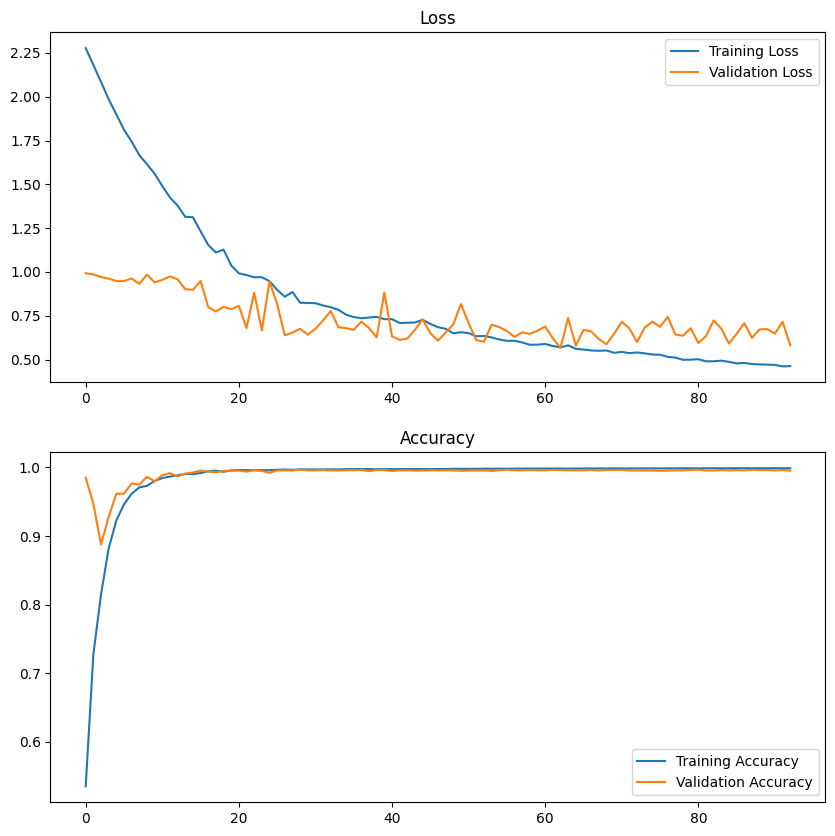

Validation Metrics: {'TPR': 0.4287601113319397, 'Accuracy': 0.9962148666381836, 'Dice': 0.30971241742372513, 'Loss': 0.5662480741739273}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.8925368785858154, 'Accuracy': 0.9983112215995789, 'Dice': 0.7363299819139334, 'Loss': 0.12321925163269043}


------------------------------------------------------------------------------------------------------------------


In [46]:
model = train_model(model, train_loader, val_loader, loss_function, optimizer, device, num_epochs, patience, l1_lambda)

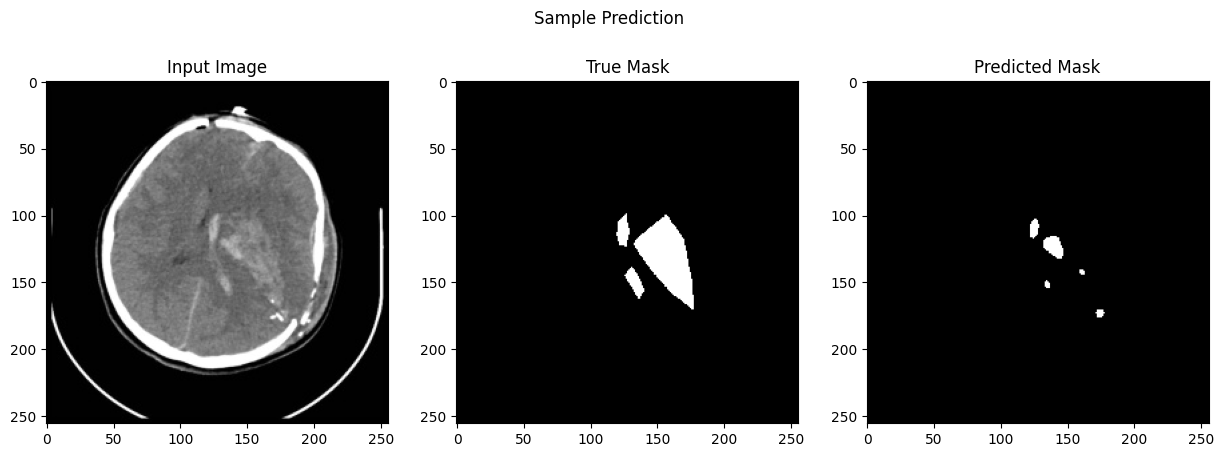

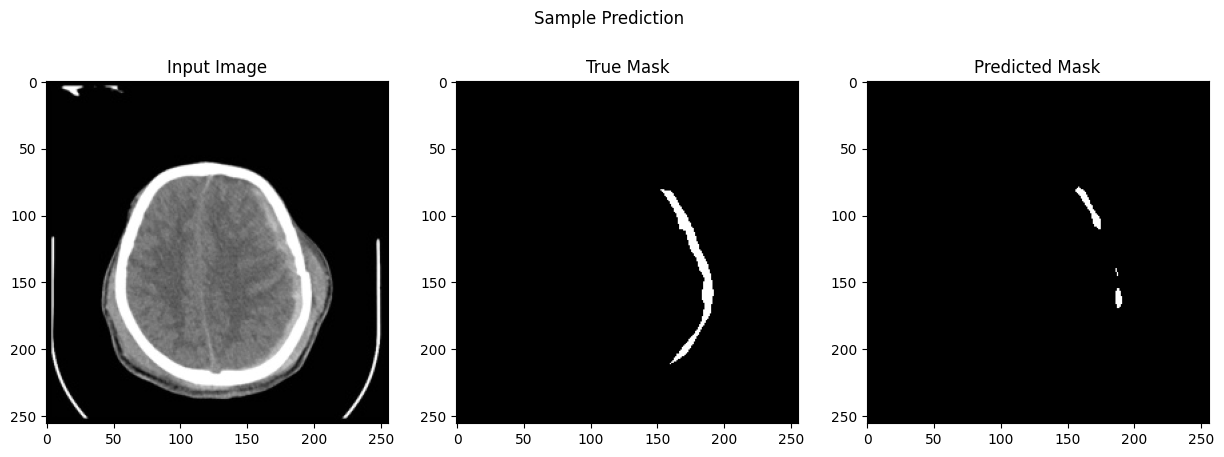

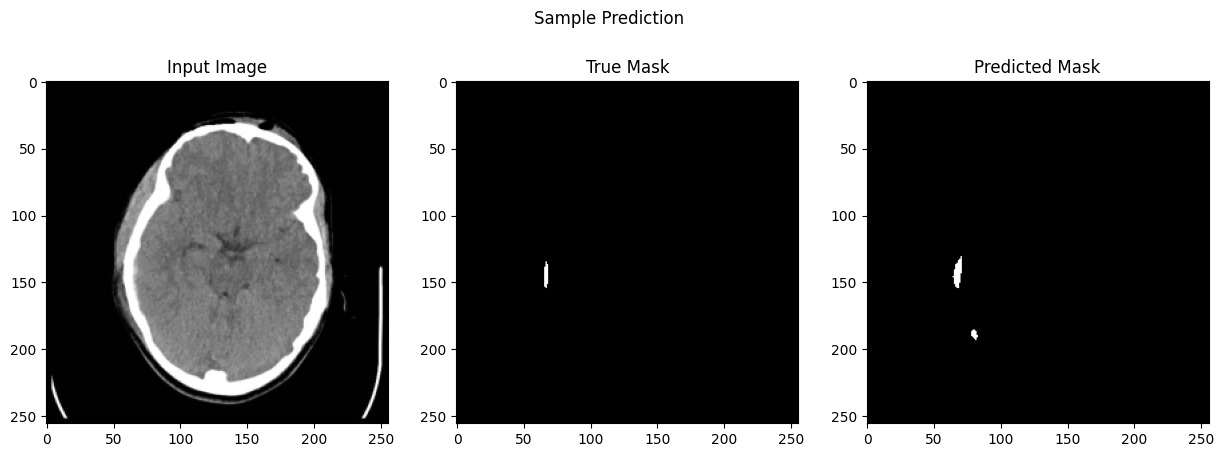

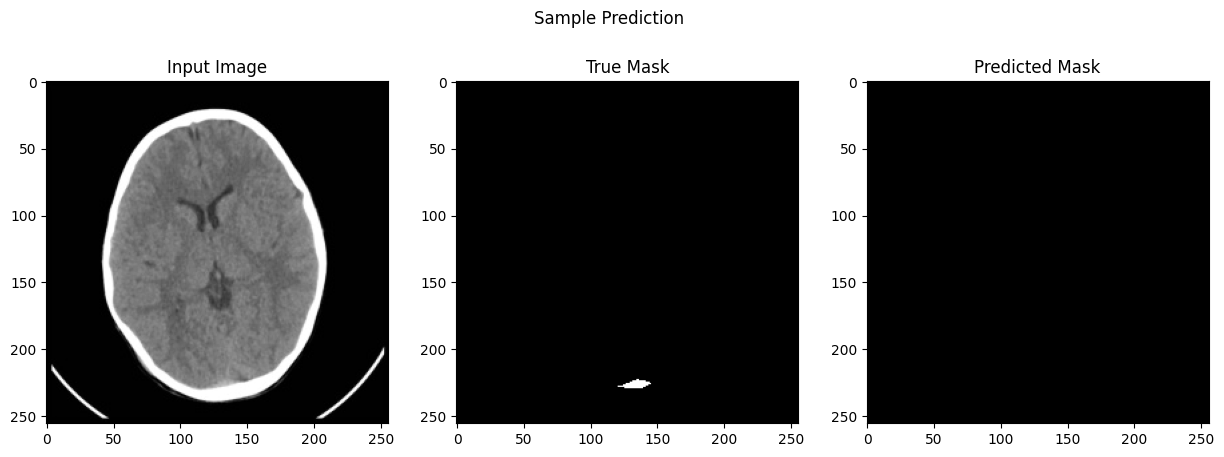

{'TPR': 0.2872893512248993,
 'Accuracy': 0.9905426502227783,
 'Dice': 0.3138207718729973,
 'Loss': 0.6008331775665283}

In [47]:
calculate_metrics(model, test_loader, loss_function, True, device)

# Q4

In [48]:
!pip install monai segmentation-models-pytorch -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [49]:
import os
import cv2
import numpy as np
import pandas as pd

# torch libraries
import torch
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torchvision.models as models

In [50]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
], p=1.0)

def augment_data(image, mask):
    augmented = augmentation(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [51]:
# modify the function to return classification labels
def file_to_tensor(directory_path, mask_path, augment=False, num_aug=1):
    file_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

    images = []
    y = []

    for file_path in file_paths:
        mask_file_name = os.path.basename(file_path).replace(".jpg", ".png")
        mask_file_path = os.path.join(mask_path, mask_file_name)

        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_file_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        if image.shape == (256, 256) and mask.shape == (256, 256):
            classification = 1
            if np.all(mask == 0): # check if mask is all 0
                classification = 0
            if augment:
                t = num_aug
                while t:
                    image_aug, mask_aug = augment_data(image, mask)
                    image_aug = image_aug.astype('float32') / 255.0
                    images.append(image_aug)
                    y.append(classification)
                    t -= 1

            image = image.astype('float32') / 255.0

            images.append(image)
            y.append(classification)

    images = np.array(images).reshape(-1, 1, 256, 256)
    y = np.array(y).reshape(-1, 1)

    images_tensor = torch.tensor(images, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    return images_tensor, y_tensor

In [52]:
class basicCNN_classifier(nn.Module):
    def __init__(self):
        super(basicCNN_classifier, self).__init__()

        # Encoder (same as basicCNN)
        self.encoder_conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(32)   # Batch Normalization
        self.relu1 = nn.ReLU()

        self.encoder_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(64)   # Batch Normalization
        self.relu2 = nn.ReLU()

        self.encoder_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.encoder_pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        self.relu3 = nn.ReLU()

        self.encoder_conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # Classifier
        self.fc1 = nn.Linear(256 * 32 * 32, 512)  
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.relu_fc1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 32)  
        self.bn_fc2 = nn.BatchNorm1d(32)
        self.relu_fc2 = nn.ReLU()

        self.fc3 = nn.Linear(32, 1)


    def forward(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = self.encoder_pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.encoder_conv2(x)
        x = self.encoder_pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.encoder_conv3(x)
        x = self.encoder_pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.encoder_conv4(x)
        x = self.relu4(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Classifier
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu_fc1(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = self.relu_fc2(x)

        x = self.fc3(x)
        return x


In [53]:
class ResNet50GrayscaleBinaryClassifier(nn.Module):
    def __init__(self):
        super(ResNet50GrayscaleBinaryClassifier, self).__init__()

        # Load the pre-trained ResNet50 model
        self.model = models.resnet50(pretrained=True)

        # Change the input channels to 1
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # final classifier
        self.model.fc = nn.Linear(2048, 256)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(256, 32)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.model(x)
        x = self.relu1(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        
        return x

In [54]:
#inspired by pytorch example and various blogs
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0.005, path='checkpoint.pt', trace_func=print):
        # Initialization of class variables
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_score = None
        self.last_score = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None: # check if the model just started training
            self.best_score = score
            self.save_checkpoint(val_loss, model) # save the model
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        self.last_score = val_loss

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.last_score == np.inf:
                self.trace_func(f'fist save with Validation loss --> {val_loss:.6f}).  Saving model ...')
            else:
                self.trace_func(f'Validation loss decreased ({-1*self.last_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss

In [55]:
# plot training
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    # Convert tensors to CPU and then to numpy arrays
    train_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in train_losses]
    val_losses = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in val_losses]
    train_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in train_accuracies]
    val_accuracies = [acc.cpu().numpy() if torch.is_tensor(acc) else acc for acc in val_accuracies]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot training and validation loss
    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].legend()

    # Plot training and validation accuracy
    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].legend()

    plt.show()

In [56]:
# true positive rate
def true_positive_rate(y_true, y_pred, device):
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    tp = torch.sum((y_true == 1) & (y_pred == 1))
    fn = torch.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn)

# accuracy

def accuracy(y_true, y_pred, device):
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    tp = torch.sum((y_true == 1) & (y_pred == 1))
    tn = torch.sum((y_true == 0) & (y_pred == 0))
    fp = torch.sum((y_true == 0) & (y_pred == 1))
    fn = torch.sum((y_true == 1) & (y_pred == 0))
    return (tp + tn) / (tp + tn + fp + fn)

# Precision
def precision(y_true, y_pred, device):
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    tp = torch.sum((y_true == 1) & (y_pred == 1))
    fp = torch.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp)

# F1 Score

def f1_score(y_true, y_pred, device):
    prec = precision(y_true, y_pred, device)
    tpr = true_positive_rate(y_true, y_pred, device)
    return 2 * (prec * tpr) / (prec + tpr)


In [77]:
# calculate metrics
def calculate_metrics(model, data_loader,loss_function, plot_image = False, device = 'cpu'):
    model.eval()

    commulative_tpr = 0
    commulative_accuracy = 0
    commulative_precision = 0
    commulative_f1 = 0
    commulative_loss = 0

    total_valid_samples = 0

    # Iterate over the data and calculate metrics
    with torch.no_grad():
        for images, y in data_loader:
            images, y = images.to(device), y.to(device)
            outputs = model(images)

            loss = loss_function(outputs, y)

            output_sig = nn.functional.sigmoid(outputs)

            preds = (output_sig > 0.5).float()

            if plot_image:
                j = random.randint(0, images.shape[0] - 1)

                plot_sample(images[j].cpu(), y[j].cpu(), preds[j].cpu(), "Sample Prediction")

            tpr = true_positive_rate(y, preds, device)
            acc = accuracy(y, preds, device)
            prec = precision(y, preds, device)
            f1 = f1_score(y, preds, device)

            commulative_tpr += tpr
            commulative_accuracy += acc
            commulative_precision += prec
            commulative_f1 += f1
            commulative_loss += loss.item()

            total_valid_samples += 1
        
        if total_valid_samples == 0:
            print("No valid samples to calculate metrics")
            return {}
        
        avg_tpr = commulative_tpr / total_valid_samples
        avg_accuracy = commulative_accuracy / total_valid_samples
        avg_precision = commulative_precision / total_valid_samples
        avg_f1 = commulative_f1 / total_valid_samples
        avg_loss = commulative_loss / total_valid_samples

        return {
            "TPR": avg_tpr.item(),
            "Accuracy": avg_accuracy.item(),
            "Precision": avg_precision.item(),
            "F1": avg_f1.item(),
            "Loss": avg_loss
        }

In [78]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=100, patience=10, l1_lambda=0.0):
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='checkpoint.pt')

    # Move the model to the specified device (CPU or GPU)
    model.to(device)

    # Initialize lists to store loss and accuracy values for plotting
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    # Main training loop
    for epoch in range(num_epochs):
        # Initialize variables for tracking loss and accuracy
        running_loss, running_accuracy = 0.0, 0.0
        model.train()  # Set model to training mode

        # Training phase
        for batch_idx, (images, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)):
            images, y = images.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = loss_fn(outputs, y)

            if l1_lambda > 0:
                l1_loss = 0
                for param in model.parameters():
                    l1_loss += torch.norm(param, 1)
                loss += l1_lambda * l1_loss

            output_sig = nn.functional.sigmoid(outputs)  # Apply sigmoid activation
            preds = (output_sig > 0.5).float()
            running_accuracy += accuracy(y, preds, device)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss and accuracy across all training batches
        train_loss = running_loss / len(train_loader)
        train_accuracy = running_accuracy / len(train_loader)

        # Validation phase
        val_metrics = calculate_metrics(model, val_loader, loss_fn, False, device)
        val_loss = val_metrics['Loss']
        val_accuracy = val_metrics['Accuracy']

        # Update lists for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Check for early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    # Plot the training and validation loss and accuracy
    plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

    # Calculate metrics on the validation set
    val_metrics = calculate_metrics(model, val_loader, loss_fn, False, device)
    print(f"Validation Metrics: {val_metrics}")
    print("\n")
    print("------------------------------------------------------------------------------------------------------------------")
    print(f"Train Metrics: {calculate_metrics(model, train_loader, loss_fn, False, device)}")
    print("\n")
    print("------------------------------------------------------------------------------------------------------------------")

    return model

In [79]:
# Modify the function to read the labels from a CSV file
def file_to_tensor_2(directory_path, label_path, augment=False, num_aug=1):
    df = pd.read_csv(label_path)  # has a file_name column and label column
    images = []
    y = []

    for _, row in df.iterrows():
        file_name = row['file_name']
        label = row['label']
        
        file_path = os.path.join(directory_path, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # Read the image in grayscale
        
        if image is None:
            print(f"Warning: Unable to read image {file_path}")
            continue
        
        if image.shape != (256, 256):
            print(f"Warning: Image {file_path} is not 256x256, resizing")
            image = cv2.resize(image, (256, 256))
        
        image = image.astype('float32') / 255.0
        images.append(image)
        y.append(label)
        
        if augment:
            for _ in range(num_aug):
                aug_image = augment_data(image)
                images.append(aug_image)
                y.append(label)
    
    images = np.array(images).reshape(-1, 1, 256, 256)
    y = np.array(y).reshape(-1, 1)
    images_tensor = torch.tensor(images, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    return images_tensor, y_tensor

## A

In [80]:
dataset1 = "/kaggle/input/aimiassigmnet2/Dataset1"

train_files_dir = os.path.join(dataset1, "TrainFiles")
train_mask_dir = os.path.join(dataset1, "TrainMask")
val_files_dir = os.path.join(dataset1, "ValFiles")
val_mask_dir = os.path.join(dataset1, "ValMask")
test_files_dir = os.path.join(dataset1, "TestFiles")
test_mask_dir = os.path.join(dataset1, "TestMask")

train_dataset_tensor, train_y_tensor = file_to_tensor(train_files_dir, train_mask_dir, augment=True, num_aug= 2)
val_dataset_tensor, val_y_tensor = file_to_tensor(val_files_dir, val_mask_dir, augment=False)
test_dataset_tensor, test_y_tensor = file_to_tensor(test_files_dir, test_mask_dir, augment=False)

print(train_dataset_tensor.shape, train_y_tensor.shape)
print(val_dataset_tensor.shape, val_y_tensor.shape)
print(test_dataset_tensor.shape, test_y_tensor.shape)

torch.Size([1197, 1, 256, 256]) torch.Size([1197, 1])
torch.Size([100, 1, 256, 256]) torch.Size([100, 1])
torch.Size([100, 1, 256, 256]) torch.Size([100, 1])


In [81]:
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(train_dataset_tensor, train_y_tensor)
val_dataset = TensorDataset(val_dataset_tensor, val_y_tensor)
test_dataset = TensorDataset(test_dataset_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [82]:
model = basicCNN_classifier()
#model = ResNet50GrayscaleBinaryClassifier()
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay =0.05)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 1000
patience = 30

l1_lambda = 0.0001

Epoch 1/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 6.3480, Train Accuracy: 0.8273, Val Loss: 0.7035, Val Accuracy: 0.6161
fist save with Validation loss --> 0.703491).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 2.0463, Train Accuracy: 0.8656, Val Loss: 0.7193, Val Accuracy: 0.6161
EarlyStopping counter: 1 out of 30


Epoch 3/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 1.4713, Train Accuracy: 0.8963, Val Loss: 0.6468, Val Accuracy: 0.4911
Validation loss decreased (-0.719283 --> 0.646822).  Saving model ...


Epoch 4/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 1.0649, Train Accuracy: 0.9119, Val Loss: 0.7853, Val Accuracy: 0.6607
EarlyStopping counter: 1 out of 30


Epoch 5/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.8711, Train Accuracy: 0.9348, Val Loss: 0.6210, Val Accuracy: 0.5625
Validation loss decreased (-0.785272 --> 0.621039).  Saving model ...


Epoch 6/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.7819, Train Accuracy: 0.9463, Val Loss: 0.5984, Val Accuracy: 0.6696
Validation loss decreased (-0.621039 --> 0.598362).  Saving model ...


Epoch 7/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.7672, Train Accuracy: 0.9467, Val Loss: 0.7159, Val Accuracy: 0.5982
EarlyStopping counter: 1 out of 30


Epoch 8/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.6295, Train Accuracy: 0.9633, Val Loss: 0.8892, Val Accuracy: 0.5714
EarlyStopping counter: 2 out of 30


Epoch 9/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.5992, Train Accuracy: 0.9638, Val Loss: 0.8749, Val Accuracy: 0.5893
EarlyStopping counter: 3 out of 30


Epoch 10/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.5756, Train Accuracy: 0.9708, Val Loss: 0.9113, Val Accuracy: 0.5714
EarlyStopping counter: 4 out of 30


Epoch 11/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.5803, Train Accuracy: 0.9717, Val Loss: 0.7416, Val Accuracy: 0.5804
EarlyStopping counter: 5 out of 30


Epoch 12/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.5024, Train Accuracy: 0.9867, Val Loss: 0.8717, Val Accuracy: 0.5893
EarlyStopping counter: 6 out of 30


Epoch 13/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.6228, Train Accuracy: 0.9617, Val Loss: 0.6612, Val Accuracy: 0.5982
EarlyStopping counter: 7 out of 30


Epoch 14/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.5329, Train Accuracy: 0.9758, Val Loss: 0.7562, Val Accuracy: 0.5804
EarlyStopping counter: 8 out of 30


Epoch 15/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.4715, Train Accuracy: 0.9883, Val Loss: 0.8096, Val Accuracy: 0.5446
EarlyStopping counter: 9 out of 30


Epoch 16/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.4504, Train Accuracy: 0.9875, Val Loss: 0.6171, Val Accuracy: 0.7321
EarlyStopping counter: 10 out of 30


Epoch 17/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.5542, Train Accuracy: 0.9733, Val Loss: 1.1552, Val Accuracy: 0.5268
EarlyStopping counter: 11 out of 30


Epoch 18/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.4705, Train Accuracy: 0.9840, Val Loss: 0.8312, Val Accuracy: 0.5804
EarlyStopping counter: 12 out of 30


Epoch 19/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.4616, Train Accuracy: 0.9850, Val Loss: 1.0610, Val Accuracy: 0.5536
EarlyStopping counter: 13 out of 30


Epoch 20/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.4715, Train Accuracy: 0.9765, Val Loss: 1.0101, Val Accuracy: 0.6250
EarlyStopping counter: 14 out of 30


Epoch 21/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.4982, Train Accuracy: 0.9867, Val Loss: 0.9790, Val Accuracy: 0.5625
EarlyStopping counter: 15 out of 30


Epoch 22/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.4056, Train Accuracy: 0.9890, Val Loss: 1.1912, Val Accuracy: 0.5804
EarlyStopping counter: 16 out of 30


Epoch 23/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.4223, Train Accuracy: 0.9858, Val Loss: 0.9325, Val Accuracy: 0.6161
EarlyStopping counter: 17 out of 30


Epoch 24/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.4831, Train Accuracy: 0.9783, Val Loss: 0.7851, Val Accuracy: 0.5714
EarlyStopping counter: 18 out of 30


Epoch 25/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.4844, Train Accuracy: 0.9800, Val Loss: 0.9109, Val Accuracy: 0.5536
EarlyStopping counter: 19 out of 30


Epoch 26/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.4031, Train Accuracy: 0.9925, Val Loss: 0.8374, Val Accuracy: 0.6339
EarlyStopping counter: 20 out of 30


Epoch 27/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.3814, Train Accuracy: 0.9948, Val Loss: 0.6460, Val Accuracy: 0.7143
EarlyStopping counter: 21 out of 30


Epoch 28/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.4351, Train Accuracy: 0.9873, Val Loss: 0.8880, Val Accuracy: 0.5982
EarlyStopping counter: 22 out of 30


Epoch 29/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.4781, Train Accuracy: 0.9775, Val Loss: 0.7097, Val Accuracy: 0.5982
EarlyStopping counter: 23 out of 30


Epoch 30/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.3999, Train Accuracy: 0.9933, Val Loss: 0.9942, Val Accuracy: 0.5625
EarlyStopping counter: 24 out of 30


Epoch 31/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.3530, Train Accuracy: 0.9925, Val Loss: 1.1256, Val Accuracy: 0.5625
EarlyStopping counter: 25 out of 30


Epoch 32/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.3577, Train Accuracy: 0.9931, Val Loss: 0.7456, Val Accuracy: 0.5982
EarlyStopping counter: 26 out of 30


Epoch 33/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.3685, Train Accuracy: 0.9950, Val Loss: 0.9564, Val Accuracy: 0.6339
EarlyStopping counter: 27 out of 30


Epoch 34/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.4743, Train Accuracy: 0.9767, Val Loss: 1.1258, Val Accuracy: 0.5357
EarlyStopping counter: 28 out of 30


Epoch 35/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.4582, Train Accuracy: 0.9892, Val Loss: 0.9241, Val Accuracy: 0.5625
EarlyStopping counter: 29 out of 30


Epoch 36/1000 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.4115, Train Accuracy: 0.9892, Val Loss: 1.0620, Val Accuracy: 0.6071
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2041193897.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


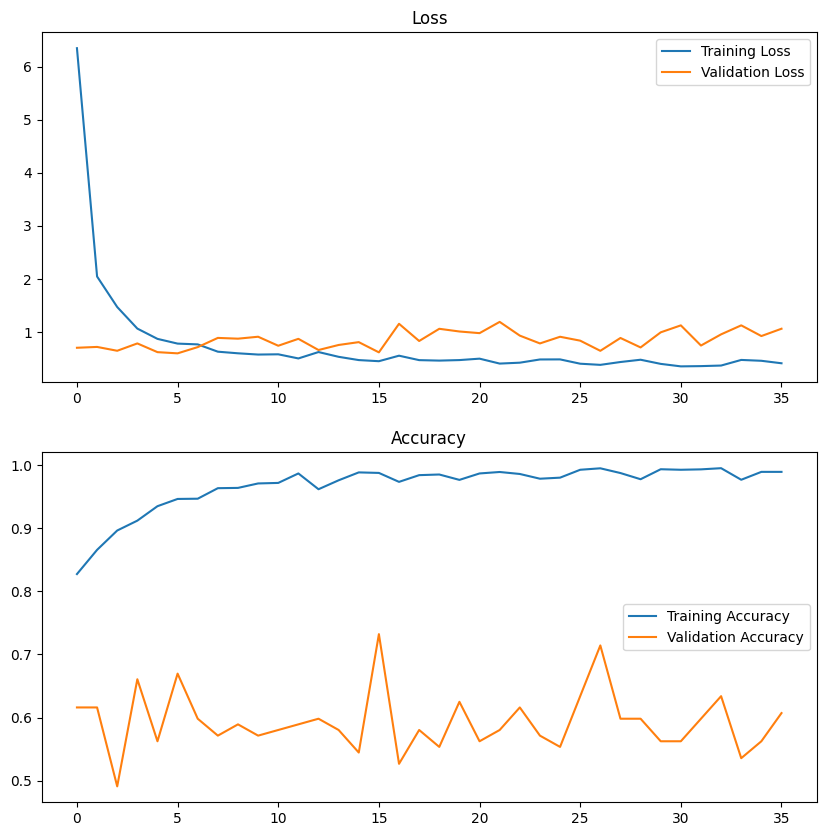

Validation Metrics: {'TPR': 1.0, 'Accuracy': 0.6696428656578064, 'Precision': 0.605822741985321, 'F1': 0.7497333288192749, 'Loss': 0.5983623734542302}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 0.9905287027359009, 'Accuracy': 0.9373077750205994, 'Precision': 0.9001235365867615, 'F1': 0.9398671984672546, 'Loss': 0.33829676985740664}


------------------------------------------------------------------------------------------------------------------


In [83]:
model = train_model(model, train_loader, val_loader, loss_function, optimizer, device, num_epochs, patience, l1_lambda)

In [84]:
calculate_metrics(model, test_loader, loss_function, False, device)

{'TPR': 1.0,
 'Accuracy': 0.7767857313156128,
 'Precision': 0.6911144852638245,
 'F1': 0.8147929310798645,
 'Loss': 0.46208953857421875}

In [85]:
train_path = "/kaggle/input/aimiassigmnet2/Dataset2/Train"
train_csv = "/kaggle/input/aimiassigmnet2/Dataset2/Train.csv"
test_path = "/kaggle/input/aimiassigmnet2/Dataset2/Test"
test_csv = "/kaggle/input/aimiassigmnet2/Dataset2/Test.csv"

test_image, test_y = file_to_tensor_2(test_path, test_csv, augment=False, num_aug=1)
train_image, train_y = file_to_tensor_2(train_path, train_csv, augment=False, num_aug=1)

In [86]:
train_dataset2 = TensorDataset(train_image, train_y)
test_dataset2 = TensorDataset(test_image, test_y)

train_loader_2 = DataLoader(train_dataset2, batch_size=16, shuffle=True)
test_loader_2 = DataLoader(test_dataset2, batch_size=16, shuffle=False)

In [87]:
# test the model on the dataset 2
calculate_metrics(model, test_loader_2, loss_function, False, device)

{'TPR': 0.5062500238418579,
 'Accuracy': 0.515625,
 'Precision': 0.495039701461792,
 'F1': 0.49457013607025146,
 'Loss': 0.7445204704999924}

In [88]:
# test the model on dataset 2
calculate_metrics(model, train_loader_2, loss_function, False, device)

{'TPR': 0.46461647748947144,
 'Accuracy': 0.5520833730697632,
 'Precision': 0.546759307384491,
 'F1': nan,
 'Loss': 0.7601907849311829}

In [89]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay =0.005)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 1000
patience = 30

l1_lambda = 0.00001

Epoch 1/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/1000], Train Loss: 0.8091, Train Accuracy: 0.6667, Val Loss: 1.5274, Val Accuracy: 0.6146
fist save with Validation loss --> 1.527360).  Saving model ...


Epoch 2/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/1000], Train Loss: 0.6127, Train Accuracy: 0.8854, Val Loss: 0.7153, Val Accuracy: 0.7292
Validation loss decreased (-1.527360 --> 0.715336).  Saving model ...


Epoch 3/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/1000], Train Loss: 0.5669, Train Accuracy: 0.9375, Val Loss: 0.5727, Val Accuracy: 0.7344
Validation loss decreased (-0.715336 --> 0.572737).  Saving model ...


Epoch 4/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/1000], Train Loss: 0.5401, Train Accuracy: 0.9792, Val Loss: 0.5461, Val Accuracy: 0.7240
Validation loss decreased (-0.572737 --> 0.546123).  Saving model ...


Epoch 5/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/1000], Train Loss: 0.4819, Train Accuracy: 0.9896, Val Loss: 0.5757, Val Accuracy: 0.6406
EarlyStopping counter: 1 out of 30


Epoch 6/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/1000], Train Loss: 0.4778, Train Accuracy: 1.0000, Val Loss: 0.5672, Val Accuracy: 0.6875
EarlyStopping counter: 2 out of 30


Epoch 7/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/1000], Train Loss: 0.4741, Train Accuracy: 0.9792, Val Loss: 0.5231, Val Accuracy: 0.7396
Validation loss decreased (-0.567191 --> 0.523096).  Saving model ...


Epoch 8/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/1000], Train Loss: 0.4303, Train Accuracy: 0.9896, Val Loss: 0.5099, Val Accuracy: 0.7708
Validation loss decreased (-0.523096 --> 0.509905).  Saving model ...


Epoch 9/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/1000], Train Loss: 0.4601, Train Accuracy: 0.9792, Val Loss: 0.5291, Val Accuracy: 0.7083
EarlyStopping counter: 1 out of 30


Epoch 10/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/1000], Train Loss: 0.4101, Train Accuracy: 1.0000, Val Loss: 0.5171, Val Accuracy: 0.7760
EarlyStopping counter: 2 out of 30


Epoch 11/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/1000], Train Loss: 0.3853, Train Accuracy: 1.0000, Val Loss: 0.4938, Val Accuracy: 0.7240
Validation loss decreased (-0.517098 --> 0.493800).  Saving model ...


Epoch 12/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/1000], Train Loss: 0.3605, Train Accuracy: 1.0000, Val Loss: 0.5122, Val Accuracy: 0.7188
EarlyStopping counter: 1 out of 30


Epoch 13/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/1000], Train Loss: 0.3662, Train Accuracy: 0.9896, Val Loss: 0.4884, Val Accuracy: 0.7552
Validation loss decreased (-0.512234 --> 0.488381).  Saving model ...


Epoch 14/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/1000], Train Loss: 0.3279, Train Accuracy: 1.0000, Val Loss: 0.4892, Val Accuracy: 0.7552
EarlyStopping counter: 1 out of 30


Epoch 15/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/1000], Train Loss: 0.3043, Train Accuracy: 1.0000, Val Loss: 0.5012, Val Accuracy: 0.7604
EarlyStopping counter: 2 out of 30


Epoch 16/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/1000], Train Loss: 0.2792, Train Accuracy: 1.0000, Val Loss: 0.5090, Val Accuracy: 0.7396
EarlyStopping counter: 3 out of 30


Epoch 17/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/1000], Train Loss: 0.2831, Train Accuracy: 1.0000, Val Loss: 0.4998, Val Accuracy: 0.7240
EarlyStopping counter: 4 out of 30


Epoch 18/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/1000], Train Loss: 0.2791, Train Accuracy: 0.9792, Val Loss: 0.5133, Val Accuracy: 0.7292
EarlyStopping counter: 5 out of 30


Epoch 19/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/1000], Train Loss: 0.2750, Train Accuracy: 1.0000, Val Loss: 0.5138, Val Accuracy: 0.7292
EarlyStopping counter: 6 out of 30


Epoch 20/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/1000], Train Loss: 0.2665, Train Accuracy: 1.0000, Val Loss: 0.4872, Val Accuracy: 0.7760
EarlyStopping counter: 7 out of 30


Epoch 21/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/1000], Train Loss: 0.2553, Train Accuracy: 1.0000, Val Loss: 0.4834, Val Accuracy: 0.7656
EarlyStopping counter: 8 out of 30


Epoch 22/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/1000], Train Loss: 0.2678, Train Accuracy: 1.0000, Val Loss: 0.4806, Val Accuracy: 0.7969
Validation loss decreased (-0.483410 --> 0.480553).  Saving model ...


Epoch 23/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/1000], Train Loss: 0.2510, Train Accuracy: 1.0000, Val Loss: 0.4768, Val Accuracy: 0.7969
EarlyStopping counter: 1 out of 30


Epoch 24/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/1000], Train Loss: 0.2451, Train Accuracy: 1.0000, Val Loss: 0.4906, Val Accuracy: 0.7344
EarlyStopping counter: 2 out of 30


Epoch 25/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/1000], Train Loss: 0.2643, Train Accuracy: 1.0000, Val Loss: 0.4774, Val Accuracy: 0.8125
EarlyStopping counter: 3 out of 30


Epoch 26/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/1000], Train Loss: 0.2308, Train Accuracy: 1.0000, Val Loss: 0.4788, Val Accuracy: 0.7917
EarlyStopping counter: 4 out of 30


Epoch 27/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/1000], Train Loss: 0.2452, Train Accuracy: 1.0000, Val Loss: 0.4809, Val Accuracy: 0.7448
EarlyStopping counter: 5 out of 30


Epoch 28/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/1000], Train Loss: 0.3746, Train Accuracy: 0.9167, Val Loss: 0.4735, Val Accuracy: 0.7760
Validation loss decreased (-0.480881 --> 0.473473).  Saving model ...


Epoch 29/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/1000], Train Loss: 0.2539, Train Accuracy: 1.0000, Val Loss: 0.4948, Val Accuracy: 0.7292
EarlyStopping counter: 1 out of 30


Epoch 30/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/1000], Train Loss: 0.2961, Train Accuracy: 0.9688, Val Loss: 0.4841, Val Accuracy: 0.7500
EarlyStopping counter: 2 out of 30


Epoch 31/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/1000], Train Loss: 0.2761, Train Accuracy: 1.0000, Val Loss: 0.5108, Val Accuracy: 0.7240
EarlyStopping counter: 3 out of 30


Epoch 32/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/1000], Train Loss: 0.2773, Train Accuracy: 1.0000, Val Loss: 0.4846, Val Accuracy: 0.7448
EarlyStopping counter: 4 out of 30


Epoch 33/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/1000], Train Loss: 0.2647, Train Accuracy: 1.0000, Val Loss: 0.4698, Val Accuracy: 0.7448
EarlyStopping counter: 5 out of 30


Epoch 34/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/1000], Train Loss: 0.2513, Train Accuracy: 1.0000, Val Loss: 0.4703, Val Accuracy: 0.7552
EarlyStopping counter: 6 out of 30


Epoch 35/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/1000], Train Loss: 0.2415, Train Accuracy: 1.0000, Val Loss: 0.4900, Val Accuracy: 0.7031
EarlyStopping counter: 7 out of 30


Epoch 36/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/1000], Train Loss: 0.2469, Train Accuracy: 1.0000, Val Loss: 0.4587, Val Accuracy: 0.8125
Validation loss decreased (-0.490016 --> 0.458728).  Saving model ...


Epoch 37/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/1000], Train Loss: 0.2190, Train Accuracy: 1.0000, Val Loss: 0.4458, Val Accuracy: 0.7969
Validation loss decreased (-0.458728 --> 0.445824).  Saving model ...


Epoch 38/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/1000], Train Loss: 0.2454, Train Accuracy: 1.0000, Val Loss: 0.4474, Val Accuracy: 0.7760
EarlyStopping counter: 1 out of 30


Epoch 39/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/1000], Train Loss: 0.2525, Train Accuracy: 0.9792, Val Loss: 0.4732, Val Accuracy: 0.7656
EarlyStopping counter: 2 out of 30


Epoch 40/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/1000], Train Loss: 0.2517, Train Accuracy: 1.0000, Val Loss: 0.5031, Val Accuracy: 0.7135
EarlyStopping counter: 3 out of 30


Epoch 41/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/1000], Train Loss: 0.2371, Train Accuracy: 1.0000, Val Loss: 0.5722, Val Accuracy: 0.7604
EarlyStopping counter: 4 out of 30


Epoch 42/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/1000], Train Loss: 0.2293, Train Accuracy: 0.9896, Val Loss: 0.4882, Val Accuracy: 0.7240
EarlyStopping counter: 5 out of 30


Epoch 43/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/1000], Train Loss: 0.2166, Train Accuracy: 1.0000, Val Loss: 0.4949, Val Accuracy: 0.7240
EarlyStopping counter: 6 out of 30


Epoch 44/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/1000], Train Loss: 0.2150, Train Accuracy: 1.0000, Val Loss: 0.5005, Val Accuracy: 0.7552
EarlyStopping counter: 7 out of 30


Epoch 45/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/1000], Train Loss: 0.2031, Train Accuracy: 1.0000, Val Loss: 0.5203, Val Accuracy: 0.7083
EarlyStopping counter: 8 out of 30


Epoch 46/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/1000], Train Loss: 0.2158, Train Accuracy: 1.0000, Val Loss: 0.4865, Val Accuracy: 0.7760
EarlyStopping counter: 9 out of 30


Epoch 47/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/1000], Train Loss: 0.1989, Train Accuracy: 1.0000, Val Loss: 0.4686, Val Accuracy: 0.7760
EarlyStopping counter: 10 out of 30


Epoch 48/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/1000], Train Loss: 0.2513, Train Accuracy: 0.9792, Val Loss: 0.4608, Val Accuracy: 0.7969
EarlyStopping counter: 11 out of 30


Epoch 49/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/1000], Train Loss: 0.1982, Train Accuracy: 1.0000, Val Loss: 0.4767, Val Accuracy: 0.7969
EarlyStopping counter: 12 out of 30


Epoch 50/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/1000], Train Loss: 0.2085, Train Accuracy: 1.0000, Val Loss: 0.5297, Val Accuracy: 0.7031
EarlyStopping counter: 13 out of 30


Epoch 51/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [51/1000], Train Loss: 0.2051, Train Accuracy: 1.0000, Val Loss: 0.4804, Val Accuracy: 0.8281
EarlyStopping counter: 14 out of 30


Epoch 52/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [52/1000], Train Loss: 0.2195, Train Accuracy: 1.0000, Val Loss: 0.4714, Val Accuracy: 0.7552
EarlyStopping counter: 15 out of 30


Epoch 53/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [53/1000], Train Loss: 0.1962, Train Accuracy: 1.0000, Val Loss: 0.4849, Val Accuracy: 0.7656
EarlyStopping counter: 16 out of 30


Epoch 54/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [54/1000], Train Loss: 0.1986, Train Accuracy: 1.0000, Val Loss: 0.4870, Val Accuracy: 0.7448
EarlyStopping counter: 17 out of 30


Epoch 55/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [55/1000], Train Loss: 0.1768, Train Accuracy: 1.0000, Val Loss: 0.4731, Val Accuracy: 0.7760
EarlyStopping counter: 18 out of 30


Epoch 56/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [56/1000], Train Loss: 0.1744, Train Accuracy: 1.0000, Val Loss: 0.4714, Val Accuracy: 0.7917
EarlyStopping counter: 19 out of 30


Epoch 57/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [57/1000], Train Loss: 0.1994, Train Accuracy: 1.0000, Val Loss: 0.4697, Val Accuracy: 0.7760
EarlyStopping counter: 20 out of 30


Epoch 58/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [58/1000], Train Loss: 0.1771, Train Accuracy: 1.0000, Val Loss: 0.4597, Val Accuracy: 0.7760
EarlyStopping counter: 21 out of 30


Epoch 59/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [59/1000], Train Loss: 0.1887, Train Accuracy: 1.0000, Val Loss: 0.4564, Val Accuracy: 0.7760
EarlyStopping counter: 22 out of 30


Epoch 60/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [60/1000], Train Loss: 0.1609, Train Accuracy: 1.0000, Val Loss: 0.4537, Val Accuracy: 0.7760
EarlyStopping counter: 23 out of 30


Epoch 61/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [61/1000], Train Loss: 0.1671, Train Accuracy: 1.0000, Val Loss: 0.4512, Val Accuracy: 0.7760
EarlyStopping counter: 24 out of 30


Epoch 62/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [62/1000], Train Loss: 0.1499, Train Accuracy: 1.0000, Val Loss: 0.4515, Val Accuracy: 0.7760
EarlyStopping counter: 25 out of 30


Epoch 63/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [63/1000], Train Loss: 0.1544, Train Accuracy: 1.0000, Val Loss: 0.4561, Val Accuracy: 0.7760
EarlyStopping counter: 26 out of 30


Epoch 64/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [64/1000], Train Loss: 0.1615, Train Accuracy: 1.0000, Val Loss: 0.4635, Val Accuracy: 0.7760
EarlyStopping counter: 27 out of 30


Epoch 65/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [65/1000], Train Loss: 0.1732, Train Accuracy: 1.0000, Val Loss: 0.4646, Val Accuracy: 0.7760
EarlyStopping counter: 28 out of 30


Epoch 66/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [66/1000], Train Loss: 0.1443, Train Accuracy: 1.0000, Val Loss: 0.4652, Val Accuracy: 0.7760
EarlyStopping counter: 29 out of 30


Epoch 67/1000 Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [67/1000], Train Loss: 0.1497, Train Accuracy: 1.0000, Val Loss: 0.4628, Val Accuracy: 0.7760
EarlyStopping counter: 30 out of 30
Early stopping


/tmp/ipykernel_30/2041193897.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


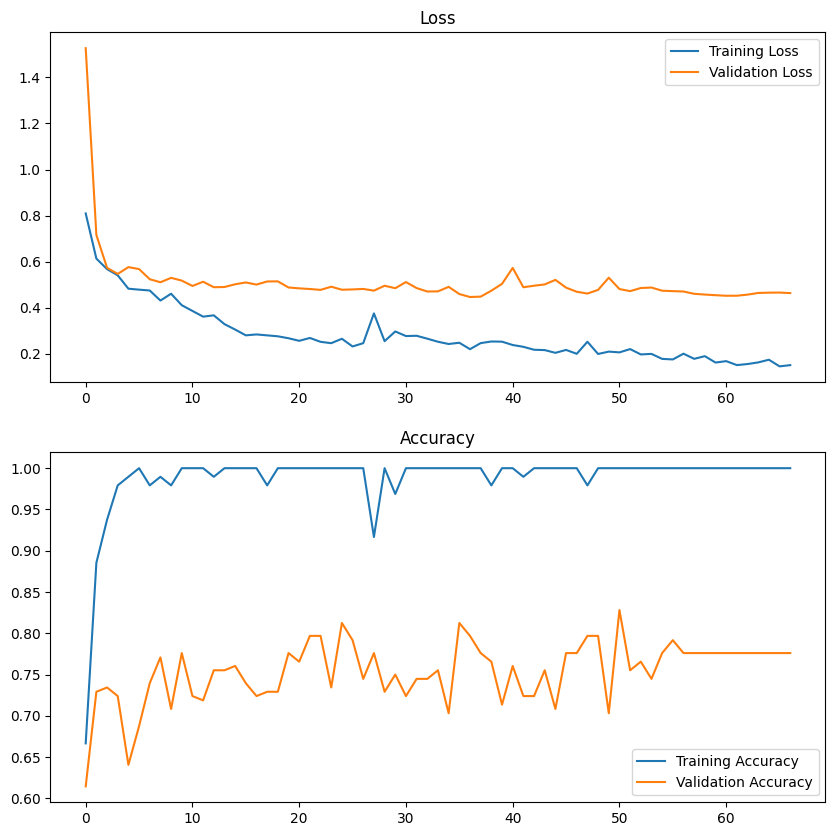

Validation Metrics: {'TPR': 0.824999988079071, 'Accuracy': 0.796875, 'Precision': 0.7619047164916992, 'F1': 0.7896613478660583, 'Loss': 0.44582419097423553}


------------------------------------------------------------------------------------------------------------------
Train Metrics: {'TPR': 1.0, 'Accuracy': 1.0, 'Precision': 1.0, 'F1': 1.0, 'Loss': 0.12936975558598837}


------------------------------------------------------------------------------------------------------------------


In [90]:
# Train the model on dataset 2
model = train_model(model, train_loader_2, test_loader_2, loss_function, optimizer, device, num_epochs, patience, l1_lambda)

In [91]:
# Calculate metrics on dataset 2
calculate_metrics(model, test_loader_2, loss_function, False, device)

{'TPR': 0.824999988079071,
 'Accuracy': 0.796875,
 'Precision': 0.7619047164916992,
 'F1': 0.7896613478660583,
 'Loss': 0.44582419097423553}

In [92]:
# Calculate metrics on dataset 1
calculate_metrics(model, test_loader, loss_function, False, device)

{'TPR': 0.8115646839141846,
 'Accuracy': 0.5714285969734192,
 'Precision': 0.5444139838218689,
 'F1': 0.6484568119049072,
 'Loss': 0.9204163466181073}

## 4b

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os



In [94]:
# Define a gradient reversal layer
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambd * grad_output, None

In [95]:
class basicCNN_DANN(nn.Module):
    def __init__(self):
        super(basicCNN_DANN, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(32)   # Batch Normalization
        self.relu1 = nn.ReLU()

        self.encoder_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(64)   # Batch Normalization
        self.relu2 = nn.ReLU()

        self.encoder_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.encoder_pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        self.relu3 = nn.ReLU()

        self.encoder_conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # Classifier
        self.fc1 = nn.Linear(256 * 32 * 32, 512)  # Assuming input image size is 256x256
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.relu_fc1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 32)  
        self.bn_fc2 = nn.BatchNorm1d(32)
        self.relu_fc2 = nn.ReLU()

        self.fc3 = nn.Linear(32, 1)

        # Domain Classifier
        self.fc4 = nn.Linear(256 * 32 * 32, 512)  # Assuming input image size is 256x256
        self.bn_fc4 = nn.BatchNorm1d(512)
        self.relu_fc4 = nn.ReLU()

        self.fc5 = nn.Linear(512, 32)  
        self.bn_fc5 = nn.BatchNorm1d(32)
        self.relu_fc5 = nn.ReLU()

        self.fc6 = nn.Linear(32, 1)

    def forward(self, x, lambd):
        # Encoder
        x = self.encoder_conv1(x)
        x = self.encoder_pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.encoder_conv2(x)
        x = self.encoder_pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.encoder_conv3(x)
        x = self.encoder_pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.encoder_conv4(x)
        x = self.relu4(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Classifier
        x_clf = self.fc1(x)
        x_clf = self.bn_fc1(x_clf)
        x_clf = self.relu_fc1(x_clf)

        x_clf = self.fc2(x_clf)
        x_clf = self.bn_fc2(x_clf)
        x_clf = self.relu_fc2(x_clf)

        x_clf = self.fc3(x_clf)

        # Domain Classifier
        x_d = GradReverse.apply(x, lambd)

        x_d = self.fc4(x_d)
        x_d = self.bn_fc4(x_d)
        x_d = self.relu_fc4(x_d)

        x_d = self.fc5(x_d)
        x_d = self.bn_fc5(x_d)
        x_d = self.relu_fc5(x_d)

        x_d = self.fc6(x_d)

        return x_clf, x_d

In [106]:
# calculate metrics
def calculate_metrics(model, data_loader,loss_function, plot_image = False, device = 'cpu'):
    model.eval()

    commulative_tpr = 0
    commulative_accuracy = 0
    commulative_precision = 0
    commulative_f1 = 0
    commulative_loss = 0

    total_valid_samples = 0
    invalid_samples = 0

    # Iterate over the data and calculate metrics
    with torch.no_grad():
        for images, y in data_loader:
            images, y = images.to(device), y.to(device)
            epoch = 1
            num_epochs = 1
            len_dataloader = len(data_loader)
            p = float(1 + epoch * len_dataloader) / num_epochs / len_dataloader
            lambd = 2. / (1. + np.exp(-10 * p)) - 1
            
            outputs, class_output = model(images, lambd)
            #print(outputs.size(), y.size())
            loss = loss_function(outputs, y)

            output_sig = nn.functional.sigmoid(outputs)

            preds = (output_sig > 0.5).float()

            # plot has disabled for now, will not be accessed in the current question
            if plot_image:
                j = random.randint(0, images.shape[0] - 1)

                plot_sample(images[j].cpu(), y[j].cpu(), preds[j].cpu(), "Sample Prediction")


            tpr = true_positive_rate(y, preds, device)
            acc = accuracy(y, preds, device)
            prec = precision(y, preds, device)
            f1 = f1_score(y, preds, device)

            commulative_tpr += tpr
            commulative_accuracy += acc
            commulative_precision += prec
            commulative_f1 += f1
            commulative_loss += loss.item()

            total_valid_samples += 1
        
        if total_valid_samples == 0:
            print("No valid samples to calculate metrics")
            return {}
        
        avg_tpr = commulative_tpr / total_valid_samples
        avg_accuracy = commulative_accuracy / total_valid_samples
        avg_precision = commulative_precision / total_valid_samples
        avg_f1 = commulative_f1 / total_valid_samples
        avg_loss = commulative_loss / total_valid_samples

        return {
            "TPR": avg_tpr.item(),
            "Accuracy": avg_accuracy.item(),
            "Precision": avg_precision.item(),
            "F1": avg_f1.item(),
            "Loss": avg_loss
        }

In [107]:
def train_dann_model(model, source_train_loader, target_train_loader, 
                     source_val_loader, target_val_loader, class_criterion, domain_criterion, optimizer, 
                     device, num_epochs=50, patience=5, l1_lambda=0.0, clip_value=1.0):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_val_loss = float('inf')
    model.to(device)

    train_losses = []
    train_class_accuracies = []
    train_domain_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_class = 0
        correct_domain = 0
        total_samples = 0
        
        len_dataloader = min(len(source_train_loader), len(target_train_loader))
        source_iter = iter(source_train_loader) # create a iterator
        target_iter = iter(target_train_loader) # create a iterator
        
        for i in tqdm(range(len_dataloader), desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
            p = float(i + epoch * len_dataloader) / num_epochs / len_dataloader # followed from original implementation
            lambd = 2. / (1. + np.exp(-10 * p)) - 1 # followed from original implementation
            
            source_data, source_labels = next(source_iter)
            source_data, source_labels = source_data.to(device), source_labels.to(device) 
            
            target_data, target_labels = next(target_iter)
            target_data, target_labels = target_data.to(device), target_labels.to(device) 
            source_domain_labels = torch.zeros(source_data.size(0)).reshape(-1, 1).float().to(device) # source domain label is 0
            target_domain_labels = torch.ones(target_data.size(0)).reshape(-1, 1).float().to(device) # target domain label is 1
            
            optimizer.zero_grad()
            
            # train on source data
            source_class_outputs, source_domain_outputs = model(source_data, lambd)
            source_class_loss = class_criterion(source_class_outputs, source_labels)
            source_domain_loss = domain_criterion(source_domain_outputs, source_domain_labels)
            
            # train on target data
            target_class_outputs, target_domain_outputs = model(target_data, lambd)
            target_class_loss = class_criterion(target_class_outputs, target_labels)
            target_domain_loss = domain_criterion(target_domain_outputs, target_domain_labels)
            
            loss = source_class_loss + target_class_loss + source_domain_loss + target_domain_loss # total loss
            
            #L1 regularization
            if l1_lambda > 0.0:
                l1_reg = sum(param.abs().sum() for param in model.parameters())
                loss += l1_lambda * l1_reg
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()

            running_loss += loss.item()
            
            pred_target = (target_class_outputs > 0).float()
            pred_source = (source_class_outputs > 0).float()
            
            total_samples += source_labels.size(0) + target_labels.size(0)
            correct_class += (pred_source == source_labels).sum().item()
            correct_class += (pred_target == target_labels).sum().item()
            
            correct_domain += (target_domain_outputs > 0).sum().item() + (source_domain_outputs < 0).sum().item()
            
        avg_train_loss = running_loss / total_samples
        train_class_accuracy = correct_class / total_samples
        train_domain_accuracy = correct_domain / total_samples
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for source_val_data, source_val_labels in source_val_loader:
                source_val_data, source_val_labels = source_val_data.to(device), source_val_labels.to(device)
                source_val_class_outputs, _ = model(source_val_data, lambd)
                source_val_loss = class_criterion(source_val_class_outputs, source_val_labels)
                val_loss += source_val_loss.item()
                pred_source_val = (source_val_class_outputs > 0).float()
                correct_val += (pred_source_val == source_val_labels).sum().item()
                total_val += source_val_labels.size(0)

            for target_val_data, target_val_labels in target_val_loader:
                target_val_data, target_val_labels = target_val_data.to(device), target_val_labels.to(device)
                target_val_class_outputs, _ = model(target_val_data, lambd)
                target_val_loss = class_criterion(target_val_class_outputs, target_val_labels)
                val_loss += target_val_loss.item()
                pred_target_val = (target_val_class_outputs > 0).float()
                correct_val += (pred_target_val == target_val_labels).sum().item()
                total_val += target_val_labels.size(0)
        
        avg_val_loss = val_loss / total_val
        val_accuracy = correct_val / total_val
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, "
              f"Train Class Accuracy: {train_class_accuracy:.4f}, "
              f"Train Domain Accuracy: {train_domain_accuracy:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

        train_losses.append(avg_train_loss)
        train_class_accuracies.append(train_class_accuracy)
        train_domain_accuracies.append(train_domain_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    print("Training complete. Best model loaded.")
    
    plot_training(train_losses, val_losses, train_class_accuracies, val_accuracies)

    return model, {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_class_accuracies": train_class_accuracies,
        "train_domain_accuracies": train_domain_accuracies,
        "val_accuracies": val_accuracies
    }

In [117]:
model = basicCNN_DANN()
#model = ResNet50GrayscaleBinaryClassifier()

class_criterion = nn.BCEWithLogitsLoss()
domain_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay = 0.05)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 20 
patience = 30 # higher patience than num_epochs to prevent early stopping from happening 

Epoch 1/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1/20], Training Loss: 0.0953, Validation Loss: 0.0509, Train Class Accuracy: 0.6179, Train Domain Accuracy: 0.5660, Val Accuracy: 0.5068
fist save with Validation loss --> 0.050917).  Saving model ...


Epoch 2/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/20], Training Loss: 0.0765, Validation Loss: 0.0490, Train Class Accuracy: 0.7783, Train Domain Accuracy: 0.5377, Val Accuracy: 0.5068
EarlyStopping counter: 1 out of 30


Epoch 3/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/20], Training Loss: 0.0772, Validation Loss: 0.0494, Train Class Accuracy: 0.8019, Train Domain Accuracy: 0.6179, Val Accuracy: 0.4932
EarlyStopping counter: 2 out of 30


Epoch 4/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/20], Training Loss: 0.0737, Validation Loss: 0.0584, Train Class Accuracy: 0.8538, Train Domain Accuracy: 0.5519, Val Accuracy: 0.4932
EarlyStopping counter: 3 out of 30


Epoch 5/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/20], Training Loss: 0.0743, Validation Loss: 0.0587, Train Class Accuracy: 0.7972, Train Domain Accuracy: 0.5708, Val Accuracy: 0.4662
EarlyStopping counter: 4 out of 30


Epoch 6/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/20], Training Loss: 0.0753, Validation Loss: 0.0628, Train Class Accuracy: 0.8302, Train Domain Accuracy: 0.5472, Val Accuracy: 0.5000
EarlyStopping counter: 5 out of 30


Epoch 7/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/20], Training Loss: 0.0740, Validation Loss: 0.0480, Train Class Accuracy: 0.8208, Train Domain Accuracy: 0.5189, Val Accuracy: 0.5405
EarlyStopping counter: 6 out of 30


Epoch 8/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/20], Training Loss: 0.0718, Validation Loss: 0.0580, Train Class Accuracy: 0.8443, Train Domain Accuracy: 0.5142, Val Accuracy: 0.5135
EarlyStopping counter: 7 out of 30


Epoch 9/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/20], Training Loss: 0.0730, Validation Loss: 0.0583, Train Class Accuracy: 0.8019, Train Domain Accuracy: 0.6274, Val Accuracy: 0.4527
EarlyStopping counter: 8 out of 30


Epoch 10/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/20], Training Loss: 0.0693, Validation Loss: 0.0543, Train Class Accuracy: 0.8491, Train Domain Accuracy: 0.5708, Val Accuracy: 0.4932
EarlyStopping counter: 9 out of 30


Epoch 11/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/20], Training Loss: 0.0711, Validation Loss: 0.0516, Train Class Accuracy: 0.8396, Train Domain Accuracy: 0.5566, Val Accuracy: 0.5608
EarlyStopping counter: 10 out of 30


Epoch 12/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/20], Training Loss: 0.0679, Validation Loss: 0.0494, Train Class Accuracy: 0.8632, Train Domain Accuracy: 0.5802, Val Accuracy: 0.5270
EarlyStopping counter: 11 out of 30


Epoch 13/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/20], Training Loss: 0.0683, Validation Loss: 0.0502, Train Class Accuracy: 0.8726, Train Domain Accuracy: 0.5425, Val Accuracy: 0.4932
EarlyStopping counter: 12 out of 30


Epoch 14/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/20], Training Loss: 0.0783, Validation Loss: 0.0488, Train Class Accuracy: 0.8019, Train Domain Accuracy: 0.5613, Val Accuracy: 0.4932
EarlyStopping counter: 13 out of 30


Epoch 15/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/20], Training Loss: 0.0726, Validation Loss: 0.0548, Train Class Accuracy: 0.8255, Train Domain Accuracy: 0.5896, Val Accuracy: 0.5473
EarlyStopping counter: 14 out of 30


Epoch 16/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16/20], Training Loss: 0.0695, Validation Loss: 0.0458, Train Class Accuracy: 0.8726, Train Domain Accuracy: 0.5849, Val Accuracy: 0.6419
Validation loss decreased (-0.054766 --> 0.045802).  Saving model ...


Epoch 17/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17/20], Training Loss: 0.0700, Validation Loss: 0.0733, Train Class Accuracy: 0.8726, Train Domain Accuracy: 0.5330, Val Accuracy: 0.5135
EarlyStopping counter: 1 out of 30


Epoch 18/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18/20], Training Loss: 0.0718, Validation Loss: 0.0524, Train Class Accuracy: 0.8491, Train Domain Accuracy: 0.5236, Val Accuracy: 0.5000
EarlyStopping counter: 2 out of 30


Epoch 19/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19/20], Training Loss: 0.0743, Validation Loss: 0.0578, Train Class Accuracy: 0.7877, Train Domain Accuracy: 0.5472, Val Accuracy: 0.4459
EarlyStopping counter: 3 out of 30


Epoch 20/20 Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20/20], Training Loss: 0.0680, Validation Loss: 0.0630, Train Class Accuracy: 0.8679, Train Domain Accuracy: 0.5849, Val Accuracy: 0.5068
EarlyStopping counter: 4 out of 30


/tmp/ipykernel_30/1351792718.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


Training complete. Best model loaded.


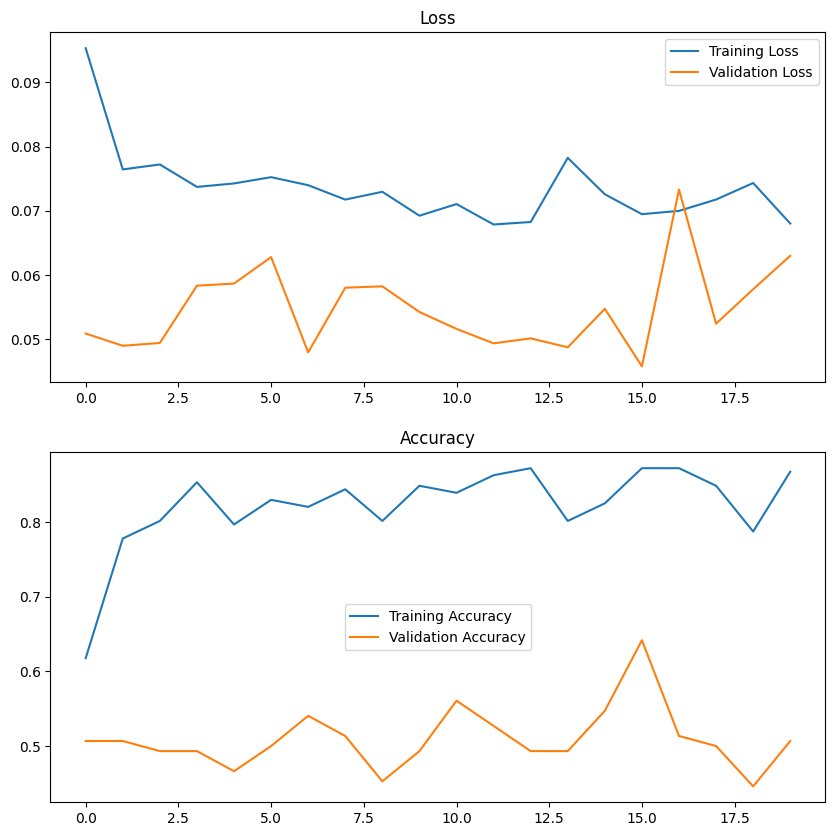

In [118]:
# Train the model
model, metrics = train_dann_model(model, train_loader, test_loader, train_loader_2, test_loader_2, class_criterion, domain_criterion, optimizer, device, num_epochs, patience, l1_lambda)

In [121]:
# Calculate metrics on the test set of dataset 1
calculate_metrics(model, test_loader, class_criterion, False, device)

{'TPR': 1.0,
 'Accuracy': 0.6964285969734192,
 'Precision': 0.6324611902236938,
 'F1': 0.7703510522842407,
 'Loss': 0.4215467231614249}

In [122]:
# Calculate metrics on the test set of dataset 2
calculate_metrics(model, test_loader_2, class_criterion, False, device)

{'TPR': 0.731249988079071,
 'Accuracy': 0.6614583134651184,
 'Precision': 0.6489447951316833,
 'F1': 0.668749988079071,
 'Loss': 0.6464438885450363}